# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

In [2]:
#importing some useful packages
import os, sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

('This image is:', <type 'numpy.ndarray'>, 'with dimesions:', (540, 960, 3))


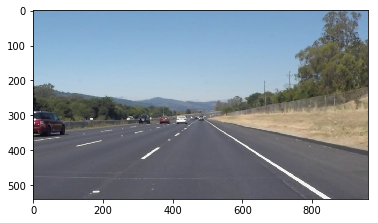

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image) 

In [7]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, alpha=0.8, beta=1., gamma=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * alpha + img * beta + gamma
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, alpha, img, beta, gamma)

In [8]:
import os
os.listdir("test_images/")

['whiteCarLaneSwitch.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteCurve.jpg']

## Test on Videos


We have tested our solution on two videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [11]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a-b)**2)) 

def frange(start, end, jump):
    ret = []
    while start < end:
        ret.append(round(start, 1))
        start += jump
    return np.array(ret)

def findYellowRoadline(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # define range of yellow color in HSV
    lower_yellow = np.array([20,75,100], dtype=np.uint8)
    upper_yellow = np.array([30,255,255], dtype=np.uint8)

    # Threshold the HSV image to get only blue colors
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    mask = np.dstack((mask, mask, mask)) 

    masked_image = cv2.bitwise_and(image, mask)

    return masked_image, hsv

def findWhiteRoadline(image):
    # Define our color criteria
    red_threshold = 200
    green_threshold = 200
    blue_threshold = 200
    rgb_threshold = [red_threshold, green_threshold, blue_threshold]    

    # everything BLACK, other than road-lines
    color_select= np.copy(image)

    # Mask pixels below the threshold
    # Select all the NON road-line pixels
    nonroad_pixels_by_color_thresholds = (image[:,:,0] < rgb_threshold[0]) | (image[:,:,1] < rgb_threshold[1]) | (image[:,:,2] < rgb_threshold[2])
    color_select[nonroad_pixels_by_color_thresholds] = [0,0,0]
    # plt.imshow(color_select)
    # plt.show()
    return color_select

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # print("num lines detected = ",len(lines))
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def sanitize_endpoints(image, point1, point2, roi_vertices):
    x1,y1 = point1
    x2,y2 = point2
    if(y1>y2):
        upper_point = (x2,y2)
        lower_point = (x1,y1)
    else:
        upper_point = (x1,y1)
        lower_point = (x2,y2)

    # reassign points
    x1,y1 = upper_point
    x2,y2 = lower_point

    ysize = image.shape[0]
    xsize = image.shape[1]

    slope_inv = (x2-x1)*1.0/(y2-y1)

    # check for vertical lines
    if(x1 == x2):
        lower_point = (x1, ysize-1)

    # extend lower_point to the end of frame
    if(y2 < ysize-1):
        y = ysize-1
        x = int(x2 + slope_inv*(y-y2))
        lower_point = (x,y)

    # extend upper_point upwards till the containing roadlines reaches ROI boundary
    # step 1: extend lines till the top of frame
    # print("upper_point = ",upper_point)
    if(y1>0):
        y = 0
        x = int(x1 + slope_inv*(y-y1))
        upper_point = (x,y)
    # print("upper_point = ",upper_point)

    return upper_point, lower_point

def draw_two_lanes(image, lines, vertices, color=[0, 255, 0], thickness=2):
    w_img = image.copy()
    img = image.copy()
    
    slopes_pos = []
    slopes_neg = []    

    # find nearest to camera point on left and right lanes
    xmax_pos = -10000
    ymax_pos = -10000
    xmin_pos = 10000
    ymin_pos = 10000

    xmax_neg = -10000
    ymax_neg = -10000
    xmin_neg = 10000
    ymin_neg = 10000

    # print("num lines detected = ",len(lines))
    temp_img = img.copy()
    for line in lines:
        for x1,y1,x2,y2 in line:

            s = ((y2-y1)*1.0)/(x2-x1)
            if abs(s)<0.2:
                continue
            
            cv2.line(temp_img, (x1,y1), (x2,y2), [0, 0, 255], thickness)

            if s>=0:
                slopes_pos.append(s)
                xmax_pos = max(xmax_pos, max(x1, x2))
                ymax_pos = max(ymax_pos, max(y1, y2))
                xmin_pos = min(xmin_pos, min(x1, x2))
                ymin_pos = min(ymin_pos, min(y1, y2))
            else:                
                slopes_neg.append(s)    
                xmax_neg = max(xmax_neg, max(x1, x2))
                ymax_neg = max(ymax_neg, max(y1, y2))
                xmin_neg = min(xmin_neg, min(x1, x2))
                ymin_neg = min(ymin_neg, min(y1, y2))

            print("slope = ",s)
            # print("line length = ",euclidean_distance(np.array([x1,y1]),np.array([x2,y2])))
        # plt.hist(slopes_np, bins=frange(-1, 1.01, 0.2))
    # plt.imshow(temp_img)
    # plt.show()

    # cv2.line(temp_img, (xmin_pos, ymin_pos), (xmax_pos, ymax_pos), [0, 0, 255], thickness)
    # cv2.line(temp_img, (xmin_neg, ymax_neg), (xmax_neg, ymin_neg), [0, 0, 255], thickness)
#    plt.imshow(temp_img)
#    plt.show()    
    # find mean slope for left and right lane

    lane_image = np.zeros(img.shape, dtype=np.uint8)

    # Left lane or +ve slope
    if(len(slopes_pos)>0):
        # find mean slope for left lane
        slope_left = sum(slopes_pos)*1.0/len(slopes_pos)
        upper_point, lower_point = sanitize_endpoints(img, (xmin_pos, ymin_pos), (xmax_pos, ymax_pos), vertices)
        print ("left lower_point = ", lower_point)
        print ("left upper_point = ", upper_point)
        cv2.line(img, upper_point, lower_point, color, thickness)
        cv2.line(lane_image, upper_point, lower_point, color, thickness)

    # Right lane or -ve slope
    if(len(slopes_neg)>0):
        # find mean slope for right lane
        slope_right = sum(slopes_neg)*1.0/len(slopes_neg)
        upper_point, lower_point = sanitize_endpoints(img, (xmin_neg, ymax_neg), (xmax_neg, ymin_neg), vertices)
        print ("right lower_point = ", lower_point)
        print ("right upper_point = ", upper_point)        
        cv2.line(img, upper_point, lower_point, color, thickness)
        cv2.line(lane_image, upper_point, lower_point, color, thickness)

    #defining a blank mask to start with
    mask = np.zeros_like(img)      
    ysize = img.shape[0]
    xsize = img.shape[1]    
    # bring y-coord lower so that roads do not cross each other
    vertices = np.array([[(0,ysize), (490, 310+10), (xsize,ysize)]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, (255,255,255))
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(lane_image, mask)
    # plt.imshow(masked_image)
    # plt.show()

    wt_img = weighted_img(masked_image, w_img)
    # plt.imshow(wt_img)
    # plt.show()

    return wt_img

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, alpha=0.8, beta=1., gamma=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * alpha + img * beta + gamma
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, alpha, img, beta, gamma)

def getRoadLines(image):
    # convert RGB -> Gray
    gray = grayscale(image)

    # apply smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)
    # plt.imshow(blur_gray) 
    # plt.show()

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    # plt.imshow(edges) 
    # plt.show()

    # find region of interest
    imshape = image.shape
    ysize = image.shape[0]
    xsize = image.shape[1]
    vertices = np.array([[(0,ysize), (490, 310), (xsize,ysize)]], dtype=np.int32)
    # vertices = np.array([[(0,imshape[0]),(470, 300), (imshape[1],imshape[0])]], dtype=np.int32)
    # vertices = np.array([[(0,imshape[0]),(450, 300), (490, 300), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    # plt.imshow(masked_edges) 
    # plt.show()

    # find hough lines: To get long lines, try to decrease the threashold, increase minLineLength and maxLineGap. 
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40 #minimum number of pixels making up a line
    max_line_gap = 20    # maximum gap in pixels between connectable line segments
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    
    # line_image = np.zeros((*masked_edges.shape, 3), dtype=np.uint8)
    # draw_lines(line_image, lines)
    # draw_two_lanes(line_image, lines)

    # draw ROI on line_image
    # cv2.polylines(line_image, vertices, 1, (0,255,0))
    # draw_two_lanes(image, lines, thickness=10)

    # Create a "color" binary image to combine with line image
    # color_edges = np.dstack((edges, edges, edges)) 
    # line_edges = weighted_img(line_image, color_edges)

    # return line_image, line_edges
    return lines, vertices

def process_image(image):
    color_select_white = findWhiteRoadline(image)
    color_select_yellow, hsv = findYellowRoadline(image)

    # find road lines in this image
    lines, roi_vertices = getRoadLines(image)
    final_image = draw_two_lanes(image, lines, roi_vertices, thickness=5)
    return final_image



Let's try the one with the solid white lane on the right first ...

In [12]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

('slope = ', 0.64532019704433496)
('slope = ', 0.60212201591511938)
('slope = ', -0.7570093457943925)
('slope = ', 0.63953488372093026)
('slope = ', -0.70886075949367089)
('slope = ', -0.69767441860465118)
('slope = ', 0.65853658536585369)
('slope = ', -0.70454545454545459)
('slope = ', -0.65217391304347827)
('slope = ', 0.59523809523809523)
('slope = ', -0.7441860465116279)
('slope = ', -0.72727272727272729)
('slope = ', 0.62068965517241381)
('slope = ', 0.59999999999999998)
('slope = ', 0.65000000000000002)
('left lower_point = ', (870, 539))
('left upper_point = ', (-21, 0))
('right lower_point = ', (152, 539))
('right upper_point = ', (901, 0))
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  1%|          | 2/222 [00:00<00:13, 16.67it/s]

('slope = ', 0.64532019704433496)
('slope = ', 0.60212201591511938)
('slope = ', -0.7570093457943925)
('slope = ', 0.63953488372093026)
('slope = ', -0.70886075949367089)
('slope = ', -0.69767441860465118)
('slope = ', 0.65853658536585369)
('slope = ', -0.70454545454545459)
('slope = ', -0.65217391304347827)
('slope = ', 0.59523809523809523)
('slope = ', -0.7441860465116279)
('slope = ', -0.72727272727272729)
('slope = ', 0.62068965517241381)
('slope = ', 0.59999999999999998)
('slope = ', 0.65000000000000002)
('left lower_point = ', (870, 539))
('left upper_point = ', (-21, 0))
('right lower_point = ', (152, 539))
('right upper_point = ', (901, 0))
('slope = ', 0.60252365930599372)
('slope = ', -0.70370370370370372)
('slope = ', 0.625)
('slope = ', -0.75630252100840334)
('slope = ', 0.63025210084033612)
('slope = ', 0.60135135135135132)
('slope = ', -0.68965517241379315)
('slope = ', -0.70833333333333337)
('slope = ', -0.72881355932203384)
('slope = ', -0.66666666666666663)
('slope = '

  2%|▏         | 5/222 [00:00<00:12, 17.77it/s]

('slope = ', 0.60053619302949057)
('slope = ', 0.62686567164179108)
('slope = ', 0.59999999999999998)
('slope = ', 0.64150943396226412)
('slope = ', 0.65909090909090906)
('slope = ', -0.75)
('slope = ', 0.61038961038961037)
('slope = ', -0.72131147540983609)
('slope = ', -0.75342465753424659)
('slope = ', 0.59090909090909094)
('slope = ', -0.72093023255813948)
('slope = ', 0.71111111111111114)
('slope = ', 0.60919540229885061)
('left lower_point = ', (871, 539))
('left upper_point = ', (-25, 0))
('right lower_point = ', (144, 539))
('right upper_point = ', (918, 0))
('slope = ', 0.62745098039215685)
('slope = ', 0.60101010101010099)
('slope = ', 0.60158311345646442)
('slope = ', -0.69444444444444442)
('slope = ', 0.61702127659574468)
('slope = ', -0.72941176470588232)
('slope = ', 0.61290322580645162)
('slope = ', -0.72093023255813948)
('slope = ', -0.72222222222222221)
('slope = ', -0.73170731707317072)
('slope = ', 0.58333333333333337)
('left lower_point = ', (871, 539))
('left upper

  4%|▎         | 8/222 [00:00<00:11, 18.46it/s]

('slope = ', 0.62770562770562766)
('slope = ', 0.60064935064935066)
('slope = ', 0.61290322580645162)
('slope = ', -0.69565217391304346)
('slope = ', 0.58620689655172409)
('slope = ', 0.62790697674418605)
('slope = ', -0.76190476190476186)
('slope = ', 0.61038961038961037)
('slope = ', 0.59745762711864403)
('slope = ', -0.609375)
('slope = ', 0.61038961038961037)
('slope = ', 0.58536585365853655)
('slope = ', 0.59999999999999998)
('slope = ', 0.58695652173913049)


  5%|▌         | 12/222 [00:00<00:11, 18.19it/s]

('left lower_point = ', (872, 539))
('left upper_point = ', (-30, 0))
('right lower_point = ', (140, 539))
('right upper_point = ', (934, 0))
('slope = ', 0.61702127659574468)
('slope = ', 0.63888888888888884)
('slope = ', 0.58394160583941601)
('slope = ', 0.628)
('slope = ', 0.58695652173913049)
('slope = ', 0.69318181818181823)
('slope = ', -0.78431372549019607)
('slope = ', -0.67241379310344829)
('slope = ', -0.58333333333333337)
('slope = ', -0.70422535211267601)
('slope = ', 0.47619047619047616)
('slope = ', 0.55555555555555558)
('slope = ', 0.62698412698412698)
('slope = ', 0.5714285714285714)
('slope = ', 0.63636363636363635)
('slope = ', 0.56862745098039214)
('slope = ', -0.73584905660377353)
('slope = ', -0.72222222222222221)
('slope = ', -0.71153846153846156)
('left lower_point = ', (861, 539))
('left upper_point = ', (-20, 0))
('right lower_point = ', (144, 539))
('right upper_point = ', (929, 0))
('slope = ', 0.60273972602739723)
('slope = ', 0.62376237623762376)
('slope = 

  8%|▊         | 17/222 [00:00<00:10, 19.68it/s]

('slope = ', 0.625)
('slope = ', 0.64925373134328357)
('slope = ', -0.70909090909090911)
('slope = ', 0.624)
('slope = ', -0.72413793103448276)
('slope = ', -0.7232142857142857)
('slope = ', 0.63076923076923075)
('slope = ', 0.58620689655172409)
('slope = ', -0.74137931034482762)
('slope = ', 0.63636363636363635)
('slope = ', 0.6428571428571429)
('slope = ', 0.61538461538461542)
('slope = ', -0.7303370786516854)
('slope = ', -0.70175438596491224)
('slope = ', 0.66153846153846152)
('slope = ', -0.73913043478260865)
('slope = ', -0.70491803278688525)
('slope = ', -0.70149253731343286)
('slope = ', 0.63636363636363635)
('slope = ', 0.5714285714285714)
('slope = ', 0.63076923076923075)
('slope = ', 0.61194029850746268)
('left lower_point = ', (856, 539))
('left upper_point = ', (-25, 0))
('right lower_point = ', (150, 539))
('right upper_point = ', (923, 0))
('slope = ', 0.62461538461538457)
('slope = ', 0.65137614678899081)
('slope = ', -0.69696969696969702)
('slope = ', 0.653631284916201

 10%|▉         | 22/222 [00:01<00:09, 20.38it/s]

('slope = ', 0.62611275964391688)
('slope = ', 0.64971751412429379)
('slope = ', 0.65934065934065933)
('slope = ', 0.64000000000000001)
('slope = ', 0.63793103448275867)
('slope = ', -0.64444444444444449)
('slope = ', -0.69090909090909092)
('slope = ', -0.83018867924528306)
('slope = ', 0.61290322580645162)
('slope = ', 0.66666666666666663)
('slope = ', 0.6428571428571429)
('slope = ', 0.62427745664739887)
('slope = ', 0.63829787234042556)
('left lower_point = ', (857, 539))
('left upper_point = ', (-9, 0))
('right lower_point = ', (120, 539))
('right upper_point = ', (956, 0))
('slope = ', 0.65497076023391809)
('slope = ', 0.6264044943820225)
('slope = ', 0.62574850299401197)
('slope = ', 0.65238095238095239)
('slope = ', 0.63793103448275867)
('slope = ', -0.63636363636363635)
('slope = ', -0.69999999999999996)
('left lower_point = ', (856, 539))
('left upper_point = ', (-12, 0))
('right lower_point = ', (129, 539))
('right upper_point = ', (947, 0))
('slope = ', 0.65248226950354615)


 11%|█         | 24/222 [00:01<00:10, 19.08it/s]

('slope = ', 0.62603878116343492)
('slope = ', 0.65269461077844315)
('slope = ', -0.66000000000000003)
('slope = ', 0.65000000000000002)
('slope = ', -0.71875)
('slope = ', -0.67796610169491522)
('slope = ', -0.74603174603174605)
('slope = ', -0.70422535211267601)
('slope = ', -0.70454545454545459)
('slope = ', 0.65853658536585369)
('slope = ', 0.640625)
('slope = ', 0.64000000000000001)
('slope = ', 0.65217391304347827)
('slope = ', 0.6376811594202898)
('slope = ', -0.6785714285714286)
('slope = ', -0.70588235294117652)
('slope = ', 0.64000000000000001)
('left lower_point = ', (854, 539))
('left upper_point = ', (-17, 0))
('right lower_point = ', (158, 539))
('right upper_point = ', (911, 0))
('slope = ', 0.6262626262626263)
('slope = ', 0.61038961038961037)
('slope = ', 0.65296803652968038)
('slope = ', -0.67045454545454541)
('slope = ', 0.65284974093264247)
('slope = ', -0.74509803921568629)
('slope = ', -0.70129870129870131)
('slope = ', 0.65909090909090906)
('slope = ', -0.7313432

 14%|█▎        | 30/222 [00:01<00:09, 19.90it/s]

('slope = ', 0.65263157894736845)
('slope = ', 0.6264044943820225)
('slope = ', -0.72164948453608246)
('slope = ', -0.69306930693069302)
('slope = ', 0.65467625899280579)
('slope = ', -0.77586206896551724)
('slope = ', -0.7142857142857143)
('slope = ', -0.7857142857142857)
('slope = ', -0.70833333333333337)
('slope = ', 0.64646464646464652)
('slope = ', 0.65454545454545454)
('slope = ', 0.61538461538461542)
('slope = ', 0.62578616352201255)
('left lower_point = ', (856, 539))
('left upper_point = ', (-17, 0))
('right lower_point = ', (143, 539))
('right upper_point = ', (925, 0))
('slope = ', 0.65086206896551724)
('slope = ', 0.62464985994397759)
('slope = ', -0.67164179104477617)
('slope = ', 0.63043478260869568)
('slope = ', -0.72131147540983609)
('slope = ', 0.63793103448275867)
('slope = ', -0.77777777777777779)
('slope = ', -0.72222222222222221)
('slope = ', -0.660377358490566)
('slope = ', 0.64814814814814814)
('slope = ', 0.6428571428571429)
('slope = ', -0.69999999999999996)
('

 16%|█▌        | 35/222 [00:01<00:09, 20.59it/s]

('slope = ', 0.65094339622641506)
('slope = ', 0.62429378531073443)
('slope = ', 0.62264150943396224)
('slope = ', -0.77027027027027029)
('slope = ', 0.63492063492063489)
('slope = ', -0.75)
('slope = ', 0.65158371040723984)
('slope = ', -0.83076923076923082)
('left lower_point = ', (858, 539))
('left upper_point = ', (-15, 0))
('right lower_point = ', (160, 539))
('right upper_point = ', (897, 0))
('slope = ', 0.65068493150684936)
('slope = ', 0.62447257383966248)
('slope = ', 0.62427745664739887)
('slope = ', 0.65191740412979349)
('slope = ', -0.70731707317073167)
('slope = ', 0.56818181818181823)
('slope = ', 0.56862745098039214)
('slope = ', -0.72499999999999998)
('slope = ', -0.70731707317073167)
('slope = ', -0.72727272727272729)
('slope = ', 0.53125)
('slope = ', 0.61702127659574468)
('left lower_point = ', (858, 539))
('left upper_point = ', (-15, 0))
('right lower_point = ', (145, 539))
('right upper_point = ', (920, 0))
('slope = ', 0.66233766233766234)
('slope = ', 0.6515679

 17%|█▋        | 38/222 [00:01<00:08, 20.96it/s]

('slope = ', 0.65037593984962405)
('slope = ', 0.625)
('slope = ', -0.73170731707317072)
('slope = ', 0.65625)
('slope = ', -0.72499999999999998)
('slope = ', -0.7021276595744681)
('slope = ', 0.61363636363636365)
('slope = ', 0.640625)
('slope = ', -0.72499999999999998)
('slope = ', 0.54761904761904767)
('slope = ', -0.7142857142857143)
('slope = ', 0.625)
('left lower_point = ', (854, 539))
('left upper_point = ', (-17, 0))
('right lower_point = ', (142, 539))
('right upper_point = ', (968, 0))
('slope = ', 0.64885496183206104)
('slope = ', 0.62456140350877198)
('slope = ', 0.65753424657534243)
('slope = ', -0.77192982456140347)
('slope = ', -0.67741935483870963)
('slope = ', -0.77500000000000002)
('slope = ', 0.61904761904761907)
('slope = ', -0.6607142857142857)
('slope = ', 0.63636363636363635)
('slope = ', 0.62962962962962965)
('slope = ', -0.72307692307692306)
('slope = ', 0.63829787234042556)
('slope = ', -0.72727272727272729)
('slope = ', -0.78048780487804881)
('slope = ', 0.6

 20%|█▉        | 44/222 [00:02<00:08, 21.56it/s]

('slope = ', 0.62454873646209386)
('slope = ', 0.67164179104477617)
('slope = ', 0.6875)
('slope = ', 0.63265306122448983)
('slope = ', 0.65714285714285714)
('slope = ', 0.62666666666666671)
('slope = ', -0.66666666666666663)
('slope = ', 0.59999999999999998)
('slope = ', -0.69841269841269837)
('slope = ', 0.70731707317073167)
('slope = ', -0.75409836065573765)
('slope = ', -0.75)
('slope = ', 0.66666666666666663)
('slope = ', -0.69811320754716977)
('slope = ', 0.64885496183206104)
('slope = ', 0.64000000000000001)
('left lower_point = ', (855, 539))
('left upper_point = ', (-6, 0))
('right lower_point = ', (141, 539))
('right upper_point = ', (925, 0))
('slope = ', 0.62548262548262545)
('slope = ', 0.66666666666666663)
('slope = ', 0.67256637168141598)
('slope = ', 0.63013698630136983)
('slope = ', -0.75384615384615383)
('slope = ', -0.77777777777777779)
('slope = ', 0.61904761904761907)
('slope = ', -0.75)
('slope = ', -0.70909090909090911)
('slope = ', 0.68627450980392157)
('slope =

 21%|██        | 47/222 [00:02<00:08, 21.38it/s]

('slope = ', 0.62450592885375489)
('slope = ', 0.67266187050359716)
('slope = ', 0.62878787878787878)
('slope = ', -0.68518518518518523)
('slope = ', -0.79591836734693877)
('slope = ', 0.67231638418079098)
('slope = ', 0.60869565217391308)
('slope = ', 0.63414634146341464)
('slope = ', 0.68292682926829273)
('left lower_point = ', (856, 539))
('left upper_point = ', (-7, 0))
('right lower_point = ', (140, 539))
('right upper_point = ', (935, 0))
('slope = ', 0.62790697674418605)
('slope = ', 0.67136150234741787)
('slope = ', 0.62886597938144329)
('slope = ', -0.70149253731343286)
('slope = ', -0.77192982456140347)
('slope = ', 0.65000000000000002)
('slope = ', 0.66949152542372881)
('slope = ', 0.60869565217391308)
('slope = ', -0.69491525423728817)
('slope = ', 0.6875)
('slope = ', 0.62765957446808507)
('slope = ', 0.56097560975609762)
('left lower_point = ', (855, 539))
('left upper_point = ', (-12, 0))
('right lower_point = ', (138, 539))
('right upper_point = ', (925, 0))
('slope = '

 23%|██▎       | 52/222 [00:02<00:09, 18.13it/s]

('slope = ', 0.62893081761006286)
('slope = ', 0.67320261437908502)
('slope = ', -0.75193798449612403)
('slope = ', -0.69718309859154926)
('slope = ', 0.61403508771929827)
('slope = ', 0.64197530864197527)
('slope = ', 0.66000000000000003)
('slope = ', 0.67330677290836649)
('slope = ', -0.71111111111111114)
('slope = ', -0.75)
('slope = ', -0.68181818181818177)
('left lower_point = ', (848, 539))
('left upper_point = ', (10, 0))
('right lower_point = ', (140, 539))
('right upper_point = ', (922, 0))
('slope = ', 0.6278195488721805)
('slope = ', 0.67229729729729726)
('slope = ', 0.67128027681660896)
('slope = ', -0.68627450980392157)
('slope = ', -0.73469387755102045)
('slope = ', 0.62745098039215685)
('slope = ', -0.75471698113207553)
('slope = ', -0.69911504424778759)
('slope = ', -0.75)
('slope = ', -0.69117647058823528)
('slope = ', -0.72549019607843135)
('slope = ', 0.61538461538461542)
('slope = ', -0.69999999999999996)
('slope = ', 0.61194029850746268)
('slope = ', 0.613636363636

 25%|██▌       | 56/222 [00:02<00:09, 17.95it/s]

('slope = ', 0.67289719626168221)
('slope = ', 0.62698412698412698)
('slope = ', 0.61194029850746268)
('slope = ', 0.6690647482014388)
('slope = ', 0.59523809523809523)
('slope = ', -0.69230769230769229)
('slope = ', 0.61194029850746268)
('slope = ', -0.72857142857142854)
('slope = ', 0.5957446808510638)
('slope = ', 0.63157894736842102)
('slope = ', 0.61538461538461542)
('left lower_point = ', (852, 539))
('left upper_point = ', (5, 0))
('right lower_point = ', (141, 539))
('right upper_point = ', (912, 0))
('slope = ', 0.62551440329218111)
('slope = ', 0.6718146718146718)
('slope = ', -0.62790697674418605)
('slope = ', 0.61904761904761907)
('slope = ', 0.62704918032786883)
('slope = ', -0.77586206896551724)
('slope = ', 0.65909090909090906)
('slope = ', 0.67142857142857137)
('slope = ', 0.68518518518518523)
('left lower_point = ', (854, 539))
('left upper_point = ', (-6, 0))
('right lower_point = ', (139, 539))
('right upper_point = ', (928, 0))
('slope = ', 0.62745098039215685)
('sl

 27%|██▋       | 60/222 [00:03<00:09, 16.57it/s]

('slope = ', 0.62390670553935856)
('slope = ', 0.6542553191489362)
('slope = ', -0.71153846153846156)
('slope = ', 0.6333333333333333)
('slope = ', -0.67346938775510201)
('slope = ', 0.6283783783783784)
('slope = ', -0.65909090909090906)
('slope = ', 0.59999999999999998)
('slope = ', 0.64000000000000001)
('slope = ', 0.63235294117647056)
('slope = ', -0.69999999999999996)
('left lower_point = ', (852, 539))
('left upper_point = ', (-7, 0))
('right lower_point = ', (130, 539))
('right upper_point = ', (951, 0))
('slope = ', 0.62456140350877198)
('slope = ', 0.66666666666666663)
('slope = ', 0.67094017094017089)
('slope = ', -0.64000000000000001)
('slope = ', -0.6811594202898551)
('slope = ', -0.75)
('slope = ', 0.59999999999999998)
('slope = ', 0.69047619047619047)
('slope = ', 0.68292682926829273)
('slope = ', -0.66666666666666663)
('slope = ', 0.67307692307692313)
('slope = ', 0.6271186440677966)
('slope = ', 0.71641791044776115)
('slope = ', -0.67692307692307696)
('left lower_point =

 29%|██▉       | 64/222 [00:03<00:10, 15.27it/s]

('slope = ', 0.67164179104477617)
('slope = ', 0.6333333333333333)
('slope = ', 0.64953271028037385)
('slope = ', -0.6690647482014388)
('slope = ', -0.72222222222222221)
('slope = ', 0.61194029850746268)
('slope = ', -0.59722222222222221)
('slope = ', 0.69387755102040816)
('slope = ', -0.67307692307692313)
('slope = ', -0.75)
('slope = ', -0.6875)
('slope = ', 0.66000000000000003)
('slope = ', 0.66666666666666663)
('slope = ', -0.78048780487804881)
('slope = ', 0.66000000000000003)
('slope = ', 0.6607142857142857)
('left lower_point = ', (844, 539))
('left upper_point = ', (2, 0))
('right lower_point = ', (131, 539))
('right upper_point = ', (948, 0))
('slope = ', 0.6737160120845922)
('slope = ', 0.64563106796116509)
('slope = ', -0.67567567567567566)
('slope = ', -0.70297029702970293)
('slope = ', 0.66666666666666663)
('slope = ', -0.7142857142857143)
('slope = ', 0.67123287671232879)
('slope = ', -0.80434782608695654)
('slope = ', 0.66101694915254239)
('slope = ', 0.66666666666666663

 30%|██▉       | 66/222 [00:03<00:11, 13.80it/s]

('slope = ', 0.64761904761904765)
('slope = ', 0.67482517482517479)
('slope = ', 0.66666666666666663)
('slope = ', 0.59649122807017541)
('slope = ', 0.59523809523809523)
('slope = ', 0.67295597484276726)
('slope = ', -0.69512195121951215)
('slope = ', 0.647887323943662)
('slope = ', -0.65151515151515149)
('slope = ', -0.68000000000000005)
('slope = ', -0.66176470588235292)
('slope = ', -0.6607142857142857)
('slope = ', 0.66666666666666663)
('slope = ', 0.64516129032258063)
('slope = ', 0.6470588235294118)
('left lower_point = ', (842, 539))
('left upper_point = ', (-5, 0))
('right lower_point = ', (109, 539))
('right upper_point = ', (983, 0))
('slope = ', 0.64971751412429379)
('slope = ', 0.6737160120845922)
('slope = ', 0.67261904761904767)
('slope = ', 0.64743589743589747)
('slope = ', -0.64835164835164838)
('slope = ', -0.66666666666666663)
('slope = ', 0.66000000000000003)
('slope = ', -0.75384615384615383)
('slope = ', 0.64893617021276595)
('slope = ', -0.72499999999999998)
('lef

 32%|███▏      | 70/222 [00:03<00:10, 14.75it/s]

('slope = ', 0.6731517509727627)
('slope = ', 0.625)
('slope = ', -0.68888888888888888)
('slope = ', 0.71739130434782605)
('slope = ', 0.64429530201342278)
('slope = ', 0.64000000000000001)
('slope = ', 0.6875)
('slope = ', 0.65957446808510634)
('slope = ', 0.65957446808510634)
('slope = ', -0.66666666666666663)
('slope = ', 0.68518518518518523)
('slope = ', 0.66129032258064513)
('slope = ', 0.6428571428571429)
('slope = ', 0.51111111111111107)
('slope = ', 0.61538461538461542)
('left lower_point = ', (846, 539))
('left upper_point = ', (-8, 0))
('right lower_point = ', (121, 539))
('right upper_point = ', (955, 0))
('slope = ', 0.67267267267267272)
('slope = ', 0.64772727272727271)
('slope = ', 0.6428571428571429)
('slope = ', -0.69767441860465118)
('slope = ', 0.6607142857142857)
('slope = ', -0.65853658536585369)
('slope = ', -0.67346938775510201)
('slope = ', 0.63636363636363635)
('slope = ', 0.65957446808510634)
('slope = ', 0.68888888888888888)
('slope = ', 0.66101694915254239)
(

 33%|███▎      | 74/222 [00:04<00:09, 16.20it/s]

('slope = ', 0.63013698630136983)
('slope = ', 0.67462686567164176)
('slope = ', -0.62790697674418605)
('slope = ', -0.70370370370370372)
('slope = ', 0.67272727272727273)
('slope = ', 0.68292682926829273)
('slope = ', -0.625)
('slope = ', 0.60759493670886078)
('slope = ', -0.64000000000000001)
('slope = ', -0.61904761904761907)
('slope = ', 0.67619047619047623)
('slope = ', -0.67142857142857137)
('slope = ', 0.63291139240506333)
('slope = ', -0.69491525423728817)
('left lower_point = ', (843, 539))
('left upper_point = ', (-2, 0))
('right lower_point = ', (124, 539))
('right upper_point = ', (945, 0))
('slope = ', 0.64935064935064934)
('slope = ', 0.67540983606557381)
('slope = ', -0.69607843137254899)
('slope = ', 0.6470588235294118)
('slope = ', -0.6454545454545455)
('slope = ', 0.67272727272727273)
('slope = ', 0.66216216216216217)
('slope = ', -0.66666666666666663)
('slope = ', -0.69523809523809521)
('slope = ', -0.65714285714285714)
('slope = ', 0.66666666666666663)
('slope = ', 

 36%|███▌      | 79/222 [00:04<00:08, 16.83it/s]

('slope = ', 0.6495726495726496)
('slope = ', 0.6767676767676768)
('slope = ', -0.64367816091954022)
('slope = ', -0.69999999999999996)
('slope = ', -0.65116279069767447)
('slope = ', 0.66666666666666663)
('slope = ', -0.6964285714285714)
('slope = ', -0.64864864864864868)
('slope = ', 0.66666666666666663)
('slope = ', -0.67307692307692313)
('slope = ', 0.65306122448979587)
('slope = ', 0.67708333333333337)
('slope = ', 0.65909090909090906)
('left lower_point = ', (842, 539))
('left upper_point = ', (-6, 0))
('right lower_point = ', (120, 539))
('right upper_point = ', (957, 0))
('slope = ', 0.67567567567567566)
('slope = ', 0.64485981308411211)
('slope = ', 0.64963503649635035)
('slope = ', 0.68000000000000005)
('slope = ', -0.65517241379310343)
('slope = ', 0.61194029850746268)
('slope = ', -0.67213114754098358)
('slope = ', 0.66666666666666663)
('slope = ', 0.61904761904761907)
('slope = ', -0.67741935483870963)
('slope = ', 0.66666666666666663)
('slope = ', -0.6097560975609756)
('s

 37%|███▋      | 83/222 [00:04<00:07, 17.87it/s]

('slope = ', 0.65172413793103445)
('slope = ', 0.69875776397515532)
('slope = ', -0.60869565217391308)
('slope = ', 0.65957446808510634)
('slope = ', -0.625)
('slope = ', 0.65340909090909094)
('slope = ', 0.72222222222222221)
('slope = ', 0.69230769230769229)
('slope = ', 0.71153846153846156)
('slope = ', 0.69047619047619047)
('left lower_point = ', (835, 539))
('left upper_point = ', (9, 0))
('right lower_point = ', (104, 539))
('right upper_point = ', (980, 0))
('slope = ', 0.69938650306748462)
('slope = ', 0.66923076923076918)
('slope = ', 0.69473684210526321)
('slope = ', -0.70454545454545459)
('slope = ', 0.66000000000000003)
('slope = ', 0.68888888888888888)
('slope = ', -0.67391304347826086)
('slope = ', 0.68181818181818177)
('slope = ', -0.66666666666666663)
('slope = ', 0.7142857142857143)
('slope = ', 0.68627450980392157)
('slope = ', -0.6470588235294118)
('slope = ', -0.66666666666666663)
('slope = ', 0.71153846153846156)
('slope = ', 0.69696969696969702)
('slope = ', 0.7777

 39%|███▉      | 87/222 [00:04<00:07, 18.25it/s]

('slope = ', 0.6542553191489362)
('slope = ', 0.69753086419753085)
('slope = ', -0.64634146341463417)
('slope = ', -0.67500000000000004)
('slope = ', -0.63157894736842102)
('slope = ', -0.66666666666666663)
('slope = ', 0.65957446808510634)
('slope = ', 0.6875)
('slope = ', -0.52500000000000002)
('slope = ', 0.7021276595744681)
('slope = ', 0.63265306122448983)
('slope = ', -0.59999999999999998)
('slope = ', 0.65492957746478875)
('left lower_point = ', (824, 539))
('left upper_point = ', (26, 0))
('right lower_point = ', (116, 539))
('right upper_point = ', (959, 0))
('slope = ', 0.69753086419753085)
('slope = ', 0.67096774193548392)
('slope = ', -0.625)
('slope = ', 0.67375886524822692)
('slope = ', -0.67619047619047623)
('slope = ', -0.61538461538461542)
('slope = ', 0.68181818181818177)
('slope = ', -0.5957446808510638)
('slope = ', -0.59999999999999998)
('slope = ', 0.67142857142857137)
('slope = ', -0.66666666666666663)
('slope = ', -0.65116279069767447)
('slope = ', 0.70588235294

 41%|████      | 91/222 [00:04<00:07, 17.93it/s]

('slope = ', 0.67391304347826086)
('slope = ', 0.70070422535211263)
('slope = ', 0.66666666666666663)
('slope = ', -0.651685393258427)
('slope = ', -0.68888888888888888)
('slope = ', 0.61224489795918369)
('slope = ', 0.6875)
('slope = ', 0.70078740157480313)
('slope = ', -0.7068965517241379)
('slope = ', 0.69090909090909092)
('slope = ', -0.53061224489795922)
('slope = ', 0.62857142857142856)
('slope = ', -0.51111111111111107)
('slope = ', 0.68292682926829273)
('slope = ', -0.69491525423728817)
('slope = ', -0.61538461538461542)
('left lower_point = ', (831, 539))
('left upper_point = ', (14, 0))
('right lower_point = ', (118, 539))
('right upper_point = ', (956, 0))
('slope = ', 0.65333333333333332)
('slope = ', 0.70220588235294112)
('slope = ', 0.70292887029288698)
('slope = ', -0.66176470588235292)
('slope = ', 0.67619047619047623)
('slope = ', -0.625)
('slope = ', 0.59090909090909094)
('slope = ', -0.66666666666666663)
('slope = ', 0.65000000000000002)
('slope = ', 0.68518518518518

 42%|████▏     | 93/222 [00:05<00:07, 16.95it/s]

('slope = ', 0.6742424242424242)
('slope = ', 0.72300469483568075)
('slope = ', 0.67692307692307696)
('slope = ', -0.63414634146341464)
('slope = ', 0.67901234567901236)
('slope = ', 0.69230769230769229)
('slope = ', 0.74509803921568629)
('slope = ', -0.67241379310344829)
('slope = ', -0.72093023255813948)
('slope = ', -0.65000000000000002)
('slope = ', 0.74358974358974361)
('slope = ', 0.72727272727272729)
('left lower_point = ', (829, 539))
('left upper_point = ', (32, 0))
('right lower_point = ', (114, 539))
('right upper_point = ', (972, 0))
('slope = ', 0.67615658362989328)
('slope = ', 0.71999999999999997)
('slope = ', 0.72727272727272729)
('slope = ', 0.68656716417910446)
('slope = ', -0.66666666666666663)
('slope = ', -0.66666666666666663)
('slope = ', -0.640625)
('slope = ', 0.66000000000000003)
('slope = ', 0.74468085106382975)
('slope = ', 0.68181818181818177)
('slope = ', 0.71739130434782605)
('left lower_point = ', (828, 539))
('left upper_point = ', (31, 0))
('right lower

 44%|████▍     | 98/222 [00:05<00:06, 18.37it/s]

('slope = ', 0.7232142857142857)
('slope = ', 0.67375886524822692)
('slope = ', -0.67073170731707321)
('slope = ', -0.69047619047619047)
('slope = ', 0.7142857142857143)
('slope = ', 0.73809523809523814)
('slope = ', -0.69444444444444442)
('slope = ', -0.59183673469387754)
('slope = ', 0.71999999999999997)
('slope = ', 0.68181818181818177)
('slope = ', 0.68292682926829273)
('slope = ', 0.65909090909090906)
('slope = ', 0.72571428571428576)
('slope = ', -0.62903225806451613)
('slope = ', 0.54166666666666663)
('slope = ', -0.62264150943396224)
('left lower_point = ', (812, 539))
('left upper_point = ', (46, 0))
('right lower_point = ', (121, 539))
('right upper_point = ', (955, 0))
('slope = ', 0.70833333333333337)
('slope = ', 0.67901234567901236)
('slope = ', -0.66990291262135926)
('slope = ', 0.67164179104477617)
('slope = ', -0.66249999999999998)
('slope = ', 0.70930232558139539)
('slope = ', 0.6875)
('slope = ', 0.65853658536585369)
('slope = ', -0.67307692307692313)
('slope = ', 0.

 46%|████▋     | 103/222 [00:05<00:06, 17.37it/s]

('slope = ', 0.72363636363636363)
('slope = ', 0.67839195979899503)
('slope = ', -0.66666666666666663)
('slope = ', -0.62)
('slope = ', -0.74137931034482762)
('slope = ', 0.70833333333333337)
('slope = ', 0.65000000000000002)
('slope = ', -0.61194029850746268)
('slope = ', 0.7258883248730964)
('slope = ', -0.67441860465116277)
('slope = ', -0.6428571428571429)
('slope = ', 0.65957446808510634)
('slope = ', -0.70731707317073167)
('slope = ', -0.78846153846153844)
('left lower_point = ', (812, 539))
('left upper_point = ', (74, 0))
('right lower_point = ', (115, 539))
('right upper_point = ', (969, 0))
('slope = ', 0.70588235294117652)
('slope = ', 0.67537313432835822)
('slope = ', 0.69999999999999996)
('slope = ', 0.65000000000000002)
('slope = ', 0.69090909090909092)
('slope = ', 0.67777777777777781)
('slope = ', -0.60784313725490191)
('slope = ', 0.63461538461538458)
('slope = ', -0.69512195121951215)
('slope = ', 0.66666666666666663)
('slope = ', 0.68888888888888888)
('slope = ', 0.7

 48%|████▊     | 107/222 [00:05<00:06, 17.28it/s]

('slope = ', 0.67647058823529416)
('slope = ', 0.70204081632653059)
('slope = ', 0.65789473684210531)
('slope = ', 0.65420560747663548)
('slope = ', -0.64444444444444449)
('slope = ', -0.72916666666666663)
('slope = ', -0.71999999999999997)
('slope = ', 0.6271186440677966)
('slope = ', 0.65116279069767447)
('slope = ', 0.58823529411764708)
('slope = ', -0.7068965517241379)
('slope = ', -0.65909090909090906)
('slope = ', 0.6875)
('slope = ', 0.56521739130434778)
('slope = ', -0.73469387755102045)
('slope = ', 0.56818181818181823)
('slope = ', 0.64000000000000001)
('slope = ', 0.6875)
('left lower_point = ', (836, 539))
('left upper_point = ', (12, 0))
('right lower_point = ', (126, 539))
('right upper_point = ', (955, 0))
('slope = ', 0.67479674796747968)
('slope = ', 0.7021276595744681)
('slope = ', 0.68918918918918914)
('slope = ', 0.63265306122448983)
('slope = ', -0.64814814814814814)
('slope = ', 0.67796610169491522)
('slope = ', -0.72222222222222221)
('slope = ', 0.650000000000000

 50%|█████     | 111/222 [00:06<00:06, 16.05it/s]

('slope = ', 0.67295597484276726)
('slope = ', -0.67391304347826086)
('slope = ', 0.70108695652173914)
('slope = ', -0.67647058823529416)
('slope = ', 0.6875)
('slope = ', 0.67333333333333334)
('slope = ', -0.66666666666666663)
('slope = ', 0.67532467532467533)
('slope = ', -0.59999999999999998)
('slope = ', 0.68656716417910446)
('slope = ', -0.7142857142857143)
('slope = ', -0.72549019607843135)
('slope = ', 0.70085470085470081)
('slope = ', 0.68354430379746833)
('slope = ', -0.72857142857142854)
('left lower_point = ', (838, 539))
('left upper_point = ', (22, 0))
('right lower_point = ', (132, 539))
('right upper_point = ', (947, 0))
('slope = ', 0.7009803921568627)
('slope = ', 0.65346534653465349)
('slope = ', 0.67207792207792205)
('slope = ', -0.69811320754716977)
('slope = ', -0.64335664335664333)
('slope = ', -0.67213114754098358)
('slope = ', -0.71739130434782605)
('slope = ', -0.72916666666666663)
('slope = ', 0.70063694267515919)
('slope = ', -0.59999999999999998)
('slope = '

 52%|█████▏    | 115/222 [00:06<00:07, 15.26it/s]

('slope = ', 0.69784172661870503)
('slope = ', 0.67256637168141598)
('slope = ', -0.66101694915254239)
('slope = ', 0.66666666666666663)
('slope = ', -0.65573770491803274)
('slope = ', -0.66666666666666663)
('slope = ', 0.68888888888888888)
('slope = ', -0.62222222222222223)
('slope = ', -0.69047619047619047)
('slope = ', 0.71739130434782605)
('slope = ', 0.76190476190476186)
('slope = ', 0.70085470085470081)
('slope = ', -0.71186440677966101)
('left lower_point = ', (835, 539))
('left upper_point = ', (25, 0))
('right lower_point = ', (131, 539))
('right upper_point = ', (947, 0))
('slope = ', 0.6518518518518519)
('slope = ', 0.697508896797153)
('slope = ', 0.6518518518518519)
('slope = ', -0.58750000000000002)
('slope = ', 0.65193370165745856)
('slope = ', -0.64761904761904765)
('slope = ', 0.63793103448275867)
('slope = ', 0.65957446808510634)
('slope = ', 0.6428571428571429)
('left lower_point = ', (842, 539))
('left upper_point = ', (26, 0))
('right lower_point = ', (128, 539))
('

 54%|█████▍    | 120/222 [00:06<00:06, 16.95it/s]

('slope = ', 0.67685589519650657)
('slope = ', 0.64880952380952384)
('slope = ', 0.6811594202898551)
('slope = ', -0.69999999999999996)
('slope = ', -0.671875)
('slope = ', -0.65909090909090906)
('slope = ', -0.70731707317073167)
('slope = ', 0.66666666666666663)
('slope = ', 0.65000000000000002)
('slope = ', 0.66666666666666663)
('slope = ', 0.65441176470588236)
('slope = ', 0.66666666666666663)
('slope = ', -0.66666666666666663)
('slope = ', -0.64516129032258063)
('left lower_point = ', (846, 539))
('left upper_point = ', (11, 0))
('right lower_point = ', (123, 539))
('right upper_point = ', (964, 0))
('slope = ', 0.64473684210526316)
('slope = ', 0.68027210884353739)
('slope = ', 0.63636363636363635)
('slope = ', 0.6705882352941176)
('slope = ', 0.6901408450704225)
('slope = ', -0.7021276595744681)
('slope = ', -0.65454545454545454)
('slope = ', 0.66265060240963858)
('slope = ', -0.61538461538461542)
('slope = ', -0.70588235294117652)
('slope = ', 0.65909090909090906)
('slope = ', -

 55%|█████▍    | 122/222 [00:06<00:06, 16.52it/s]

('slope = ', 0.64516129032258063)
('slope = ', 0.67655786350148372)
('slope = ', -0.70526315789473681)
('slope = ', 0.64220183486238536)
('slope = ', -0.67326732673267331)
('slope = ', 0.66153846153846152)
('slope = ', -0.70370370370370372)
('slope = ', -0.67142857142857137)
('slope = ', -0.69696969696969702)
('slope = ', 0.67441860465116277)
('slope = ', -0.61194029850746268)
('slope = ', 0.69090909090909092)
('slope = ', 0.67500000000000004)
('slope = ', -0.625)
('slope = ', -0.59090909090909094)
('slope = ', -0.68518518518518523)
('left lower_point = ', (850, 539))
('left upper_point = ', (2, 0))
('right lower_point = ', (134, 539))
('right upper_point = ', (954, 0))
('slope = ', 0.62827225130890052)
('slope = ', 0.67462686567164176)
('slope = ', -0.72115384615384615)
('slope = ', -0.67407407407407405)
('slope = ', 0.67346938775510201)
('slope = ', 0.62827225130890052)
('slope = ', -0.6901408450704225)
('slope = ', 0.62790697674418605)
('slope = ', 0.68888888888888888)
('slope = ', 

 57%|█████▋    | 126/222 [00:07<00:06, 15.52it/s]

('slope = ', -0.64646464646464652)
('slope = ', 0.62820512820512819)
('slope = ', -0.70114942528735635)
('slope = ', 0.6262626262626263)
('slope = ', 0.67346938775510201)
('slope = ', -0.62365591397849462)
('slope = ', 0.65957446808510634)
('slope = ', 0.66666666666666663)
('slope = ', -0.64406779661016944)
('slope = ', -0.6470588235294118)
('slope = ', 0.61290322580645162)
('slope = ', 0.62962962962962965)
('left lower_point = ', (852, 539))
('left upper_point = ', (2, 0))
('right lower_point = ', (128, 539))
('right upper_point = ', (963, 0))
('slope = ', 0.67251461988304095)
('slope = ', 0.62553191489361704)
('slope = ', -0.65116279069767447)
('slope = ', 0.62773722627737227)
('slope = ', 0.6588235294117647)
('slope = ', -0.62222222222222223)
('slope = ', -0.71739130434782605)
('slope = ', 0.66666666666666663)
('slope = ', 0.6428571428571429)
('slope = ', -0.66153846153846152)
('slope = ', 0.63414634146341464)
('slope = ', -0.67105263157894735)
('slope = ', -0.625)
('slope = ', -0.6

 59%|█████▊    | 130/222 [00:07<00:05, 16.00it/s]

('slope = ', 0.62395543175487467)
('slope = ', 0.64942528735632188)
('slope = ', -0.69672131147540983)
('slope = ', -0.66666666666666663)
('slope = ', -0.65573770491803274)
('slope = ', 0.65000000000000002)
('slope = ', -0.5714285714285714)
('slope = ', 0.62365591397849462)
('slope = ', 0.6333333333333333)
('slope = ', -0.70175438596491224)
('left lower_point = ', (859, 539))
('left upper_point = ', (-18, 0))
('right lower_point = ', (136, 539))
('right upper_point = ', (948, 0))
('slope = ', 0.62395543175487467)
('slope = ', 0.64965986394557829)
('slope = ', 0.65202702702702697)
('slope = ', -0.66666666666666663)
('slope = ', -0.66666666666666663)
('slope = ', -0.67123287671232879)
('slope = ', -0.61904761904761907)
('slope = ', -0.67241379310344829)
('slope = ', -0.68852459016393441)
('slope = ', -0.70833333333333337)
('slope = ', 0.62411347517730498)
('slope = ', 0.640625)
('slope = ', -0.5957446808510638)
('left lower_point = ', (860, 539))
('left upper_point = ', (-17, 0))
('right

 60%|██████    | 134/222 [00:07<00:05, 16.18it/s]

('slope = ', 0.64896755162241893)
('slope = ', 0.62068965517241381)
('slope = ', 0.62356321839080464)
('slope = ', -0.67105263157894735)
('slope = ', -0.75)
('slope = ', -0.69811320754716977)
('slope = ', -0.68253968253968256)
('slope = ', -0.66000000000000003)
('slope = ', 0.59999999999999998)
('slope = ', 0.63829787234042556)
('slope = ', -0.64935064935064934)
('slope = ', -0.73999999999999999)
('slope = ', 0.63235294117647056)
('slope = ', 0.40000000000000002)
('slope = ', -0.703125)
('left lower_point = ', (859, 539))
('left upper_point = ', (-16, 0))
('right lower_point = ', (144, 539))
('right upper_point = ', (949, 0))
('slope = ', 0.62314540059347179)
('slope = ', 0.65283018867924525)
('slope = ', 0.65116279069767447)
('slope = ', -0.75)
('slope = ', -0.72631578947368425)
('slope = ', -0.67213114754098358)
('slope = ', -0.72043010752688175)
('slope = ', -0.70408163265306123)
('slope = ', -0.69444444444444442)
('slope = ', 0.63793103448275867)
('slope = ', -0.71739130434782605)


 63%|██████▎   | 139/222 [00:07<00:04, 17.91it/s]

('slope = ', 0.62416107382550334)
('slope = ', 0.65068493150684936)
('slope = ', -0.72727272727272729)
('slope = ', -0.7021276595744681)
('slope = ', 0.6404494382022472)
('slope = ', -0.69117647058823528)
('slope = ', 0.57731958762886593)
('slope = ', -0.71698113207547165)
('slope = ', 0.6428571428571429)
('slope = ', 0.60344827586206895)
('slope = ', 0.65000000000000002)
('slope = ', -0.72222222222222221)
('slope = ', 0.64000000000000001)
('slope = ', -0.70769230769230773)
('slope = ', 0.6495726495726496)
('slope = ', -0.65000000000000002)
('left lower_point = ', (863, 539))
('left upper_point = ', (-15, 0))
('right lower_point = ', (142, 539))
('right upper_point = ', (934, 0))
('slope = ', 0.64912280701754388)
('slope = ', 0.62390670553935856)
('slope = ', -0.72340425531914898)
('slope = ', -0.69811320754716977)
('slope = ', -0.70370370370370372)
('slope = ', -0.71186440677966101)
('slope = ', 0.6470588235294118)
('slope = ', -0.62295081967213117)
('slope = ', 0.64830508474576276)
(

 64%|██████▍   | 143/222 [00:08<00:04, 16.68it/s]

('slope = ', 0.65034965034965031)
('slope = ', 0.62235649546827798)
('slope = ', -0.70454545454545459)
('slope = ', 0.63235294117647056)
('slope = ', -0.72881355932203384)
('slope = ', 0.62886597938144329)
('slope = ', -0.73999999999999999)
('slope = ', -0.76056338028169013)
('slope = ', 0.65853658536585369)
('slope = ', 0.63636363636363635)
('slope = ', 0.66129032258064513)
('slope = ', -0.69565217391304346)
('slope = ', -0.70129870129870131)
('slope = ', 0.6607142857142857)
('left lower_point = ', (861, 539))
('left upper_point = ', (-18, 0))
('right lower_point = ', (154, 539))
('right upper_point = ', (921, 0))
('slope = ', 0.625)
('slope = ', 0.64841498559077815)
('slope = ', 0.65024630541871919)
('slope = ', 0.63793103448275867)
('slope = ', -0.6811594202898551)
('slope = ', 0.63461538461538458)
('slope = ', 0.65000000000000002)
('slope = ', -0.6875)
('slope = ', -0.69565217391304346)
('slope = ', 0.61904761904761907)
('slope = ', 0.64516129032258063)
('slope = ', 0.6081081081081

 66%|██████▌   | 147/222 [00:08<00:04, 17.53it/s]

('slope = ', 0.62215909090909094)
('slope = ', 0.65073529411764708)
('slope = ', -0.72093023255813948)
('slope = ', -0.78260869565217395)
('slope = ', -0.69811320754716977)
('slope = ', -0.72602739726027399)
('slope = ', 0.62857142857142856)
('slope = ', 0.63492063492063489)
('slope = ', -0.7441860465116279)
('slope = ', 0.76744186046511631)
('slope = ', 0.63793103448275867)
('slope = ', -0.72580645161290325)
('slope = ', -0.71951219512195119)
('slope = ', 0.61290322580645162)
('slope = ', 0.6506024096385542)
('slope = ', 0.64406779661016944)
('left lower_point = ', (859, 539))
('left upper_point = ', (-19, 0))
('right lower_point = ', (152, 539))
('right upper_point = ', (930, 0))
('slope = ', 0.625)
('slope = ', 0.65131578947368418)
('slope = ', -0.7558139534883721)
('slope = ', -0.69892473118279574)
('slope = ', 0.62389380530973448)
('slope = ', 0.63265306122448983)
('slope = ', -0.66176470588235292)
('slope = ', -0.75409836065573765)
('slope = ', -0.70175438596491224)
('slope = ', 

 68%|██████▊   | 151/222 [00:08<00:04, 17.16it/s]

('slope = ', 0.60425531914893615)
('slope = ', 0.64779874213836475)
('slope = ', -0.7021276595744681)
('slope = ', -0.75)
('slope = ', -0.77611940298507465)
('slope = ', 0.58333333333333337)
('slope = ', 0.60509554140127386)
('slope = ', 0.65151515151515149)
('slope = ', -0.72972972972972971)
('slope = ', -0.69811320754716977)
('slope = ', 0.58139534883720934)
('slope = ', 0.6470588235294118)
('slope = ', -0.70149253731343286)
('left lower_point = ', (868, 539))
('left upper_point = ', (-10, 0))
('right lower_point = ', (150, 539))
('right upper_point = ', (926, 0))
('slope = ', 0.64601769911504425)
('slope = ', 0.60465116279069764)
('slope = ', -0.76086956521739135)
('slope = ', 0.59999999999999998)
('slope = ', -0.6987951807228916)
('slope = ', 0.61538461538461542)
('slope = ', 0.61111111111111116)
('slope = ', -0.69354838709677424)
('slope = ', -0.67272727272727273)
('slope = ', -0.72499999999999998)
('slope = ', -0.73913043478260865)
('slope = ', 0.60487804878048779)
('slope = ', -

 69%|██████▉   | 154/222 [00:08<00:03, 18.07it/s]

('slope = ', 0.60406091370558379)
('slope = ', 0.64609053497942381)
('slope = ', 0.60389610389610393)
('slope = ', -0.70588235294117652)
('slope = ', -0.74576271186440679)
('slope = ', 0.64754098360655743)
('slope = ', -0.73170731707317072)
('slope = ', 0.68181818181818177)
('slope = ', 0.65853658536585369)
('slope = ', 0.609375)
('left lower_point = ', (869, 539))
('left upper_point = ', (-18, 0))
('right lower_point = ', (153, 539))
('right upper_point = ', (925, 0))
('slope = ', 0.64664310954063609)
('slope = ', 0.62172284644194753)
('slope = ', 0.6476510067114094)
('slope = ', 0.62083333333333335)
('slope = ', -0.70175438596491224)
('slope = ', -0.75862068965517238)
('slope = ', -0.70731707317073167)
('slope = ', -0.65116279069767447)
('slope = ', 0.63636363636363635)
('slope = ', 0.46938775510204084)
('slope = ', -0.65306122448979587)
('slope = ', -0.73809523809523814)
('left lower_point = ', (847, 539))
('left upper_point = ', (-7, 0))
('right lower_point = ', (155, 539))
('right

 72%|███████▏  | 159/222 [00:08<00:03, 18.40it/s]

('slope = ', 0.64684014869888473)
('slope = ', 0.625)
('slope = ', 0.60093896713615025)
('slope = ', -0.72043010752688175)
('slope = ', 0.60499999999999998)
('slope = ', -0.74725274725274726)
('slope = ', 0.63829787234042556)
('slope = ', 0.64772727272727271)
('slope = ', -0.7528089887640449)
('slope = ', -0.67213114754098358)
('slope = ', -0.6875)
('slope = ', -0.72222222222222221)
('slope = ', 0.63793103448275867)
('left lower_point = ', (851, 539))
('left upper_point = ', (3, 0))
('right lower_point = ', (156, 539))
('right upper_point = ', (917, 0))
('slope = ', 0.60076045627376429)
('slope = ', 0.63076923076923075)
('slope = ', -0.72357723577235777)
('slope = ', 0.58750000000000002)
('slope = ', 0.62992125984251968)
('slope = ', -0.75423728813559321)
('slope = ', 0.60273972602739723)
('slope = ', -0.71153846153846156)
('slope = ', -0.75630252100840334)
('slope = ', -0.72131147540983609)
('slope = ', 0.57446808510638303)
('slope = ', 0.61224489795918369)
('slope = ', -0.70731707317

 74%|███████▍  | 164/222 [00:09<00:03, 17.96it/s]

('slope = ', 0.62337662337662336)
('slope = ', 0.59745762711864403)
('slope = ', -0.77551020408163263)
('slope = ', 0.62453531598513012)
('slope = ', -0.69999999999999996)
('slope = ', 0.61290322580645162)
('slope = ', 0.51470588235294112)
('slope = ', -0.76744186046511631)
('slope = ', -0.75)
('slope = ', 0.64516129032258063)
('slope = ', -0.80000000000000004)
('slope = ', 0.59999999999999998)
('slope = ', 0.61250000000000004)
('slope = ', 0.2857142857142857)
('slope = ', -0.69999999999999996)
('slope = ', -0.75641025641025639)
('slope = ', 0.48780487804878048)
('slope = ', -0.90697674418604646)
('left lower_point = ', (882, 539))
('left upper_point = ', (-56, 0))
('right lower_point = ', (159, 539))
('right upper_point = ', (919, 0))
('slope = ', 0.59999999999999998)
('slope = ', 0.62408759124087587)
('slope = ', 0.53061224489795922)
('slope = ', 0.53448275862068961)
('slope = ', 0.61250000000000004)
('slope = ', -0.7816091954022989)
('slope = ', -0.72340425531914898)
('slope = ', 0.

 76%|███████▌  | 168/222 [00:09<00:03, 17.46it/s]

('slope = ', 0.57614213197969544)
('slope = ', 0.60204081632653061)
('slope = ', 0.59829059829059827)
('slope = ', -0.75)
('slope = ', -0.77419354838709675)
('slope = ', 0.58823529411764708)
('slope = ', 0.57499999999999996)
('slope = ', -0.72463768115942029)
('slope = ', 0.59999999999999998)
('slope = ', -0.65853658536585369)
('slope = ', 0.60416666666666663)
('slope = ', 0.58904109589041098)
('left lower_point = ', (888, 539))
('left upper_point = ', (-46, 0))
('right lower_point = ', (159, 539))
('right upper_point = ', (919, 0))
('slope = ', 0.57692307692307687)
('slope = ', 0.60212201591511938)
('slope = ', 0.5757575757575758)
('slope = ', -0.76190476190476186)
('slope = ', -0.77272727272727271)
('slope = ', -0.81395348837209303)
('slope = ', 0.60370370370370374)
('slope = ', -0.79069767441860461)
('slope = ', -0.77419354838709675)
('slope = ', 0.59322033898305082)
('slope = ', -0.78000000000000003)
('slope = ', -0.80327868852459017)
('slope = ', 0.41463414634146339)
('slope = ', 

 77%|███████▋  | 170/222 [00:09<00:03, 15.83it/s]

('slope = ', 0.61016949152542377)
('slope = ', 0.5780346820809249)
('slope = ', 0.58333333333333337)
('slope = ', 0.58904109589041098)
('slope = ', -0.7558139534883721)
('slope = ', -0.8392857142857143)
('slope = ', -0.78048780487804881)
('slope = ', -0.77419354838709675)
('slope = ', 0.58333333333333337)
('slope = ', 0.55555555555555558)
('slope = ', 0.57499999999999996)
('slope = ', -0.75)
('slope = ', -0.77777777777777779)
('slope = ', 0.61250000000000004)
('slope = ', 0.58620689655172409)
('slope = ', 0.57446808510638303)
('slope = ', -0.77777777777777779)
('slope = ', 0.57746478873239437)
('slope = ', 0.57647058823529407)
('left lower_point = ', (885, 539))
('left upper_point = ', (-47, 0))
('right lower_point = ', (173, 539))
('right upper_point = ', (899, 0))
('slope = ', 0.60109289617486339)
('slope = ', 0.57879656160458448)
('slope = ', -0.80733944954128445)
('slope = ', -0.73043478260869565)
('slope = ', 0.60431654676258995)
('slope = ', -0.79629629629629628)
('slope = ', -0.

 79%|███████▉  | 175/222 [00:09<00:03, 14.59it/s]

('slope = ', 0.57703927492447127)
('slope = ', 0.60312500000000002)
('slope = ', -0.73469387755102045)
('slope = ', -0.81395348837209303)
('slope = ', -0.7831325301204819)
('slope = ', 0.58024691358024694)
('slope = ', -0.78378378378378377)
('slope = ', 0.56000000000000005)
('slope = ', 0.60784313725490191)
('slope = ', -0.79069767441860461)
('slope = ', -0.77631578947368418)
('slope = ', 0.51764705882352946)
('slope = ', -0.75471698113207553)
('slope = ', -0.72340425531914898)
('slope = ', 0.59999999999999998)
('left lower_point = ', (884, 539))
('left upper_point = ', (-63, 0))
('right lower_point = ', (175, 539))
('right upper_point = ', (896, 0))
('slope = ', 0.60317460317460314)
('slope = ', 0.57784431137724546)
('slope = ', 0.58108108108108103)
('slope = ', -0.77777777777777779)
('slope = ', 0.58208955223880599)
('slope = ', -0.80519480519480524)
('slope = ', -0.71999999999999997)
('slope = ', 0.59090909090909094)
('slope = ', 0.58823529411764708)
('slope = ', 0.60256410256410253

 80%|███████▉  | 177/222 [00:10<00:02, 15.64it/s]

('slope = ', 0.60260586319218246)
('slope = ', 0.57861635220125784)
('slope = ', 0.58823529411764708)
('slope = ', 0.5535714285714286)
('slope = ', -0.81000000000000005)
('slope = ', -0.76595744680851063)
('slope = ', -0.68421052631578949)
('slope = ', 0.60227272727272729)
('slope = ', -0.76000000000000001)
('slope = ', 0.57792207792207795)
('slope = ', -0.75)
('slope = ', 0.58139534883720934)
('slope = ', -0.81132075471698117)
('slope = ', 0.51219512195121952)
('slope = ', 0.51162790697674421)
('slope = ', -0.79545454545454541)
('left lower_point = ', (885, 539))
('left upper_point = ', (-66, 0))
('right lower_point = ', (172, 539))
('right upper_point = ', (899, 0))
('slope = ', 0.601123595505618)
('slope = ', 0.57911392405063289)
('slope = ', 0.58823529411764708)
('slope = ', -0.77611940298507465)
('slope = ', -0.75438596491228072)
('slope = ', 0.5855855855855856)
('slope = ', 0.56000000000000005)
('slope = ', -0.76923076923076927)
('slope = ', -0.80000000000000004)
('slope = ', 0.5

 82%|████████▏ | 181/222 [00:10<00:02, 15.18it/s]


('slope = ', 0.57499999999999996)
('slope = ', 0.62195121951219512)
('slope = ', 0.55932203389830504)
('slope = ', -0.76923076923076927)
('left lower_point = ', (887, 539))
('left upper_point = ', (-63, 0))
('right lower_point = ', (179, 539))
('right upper_point = ', (887, 0))
('slope = ', 0.57728706624605675)
('slope = ', 0.60447761194029848)
('slope = ', -0.78125)
('slope = ', -0.82539682539682535)
('slope = ', 0.58510638297872342)
('slope = ', 0.58666666666666667)
('slope = ', 0.60606060606060608)
('slope = ', -0.87096774193548387)
('slope = ', 0.57446808510638303)
('slope = ', 0.55555555555555558)
('slope = ', -0.67213114754098358)
('slope = ', -0.8571428571428571)
('slope = ', -0.75)
('slope = ', -0.90243902439024393)
('slope = ', 0.53448275862068961)
('slope = ', 0.57777777777777772)
('slope = ', 0.51578947368421058)
('slope = ', 0.6179775280898876)
('slope = ', 0.5714285714285714)
('left lower_point = ', (889, 539))
('left upper_point = ', (-64, 0))
('right lower_point = ', (1

 83%|████████▎ | 185/222 [00:10<00:02, 15.10it/s]

('slope = ', 0.6071428571428571)
('slope = ', 0.57735849056603772)
('slope = ', -0.82978723404255317)
('slope = ', 0.57831325301204817)
('slope = ', -0.76136363636363635)
('slope = ', 0.60122699386503065)
('slope = ', 0.58333333333333337)
('slope = ', 0.57627118644067798)
('slope = ', -0.75294117647058822)
('slope = ', 0.57627118644067798)
('slope = ', 0.56818181818181823)
('slope = ', 0.56896551724137934)
('slope = ', 0.58730158730158732)
('slope = ', -0.8571428571428571)
('slope = ', -0.74193548387096775)
('slope = ', -0.77941176470588236)
('slope = ', 0.59523809523809523)
('slope = ', -0.76923076923076927)
('slope = ', -0.77551020408163263)
('left lower_point = ', (879, 539))
('left upper_point = ', (-35, 0))
('right lower_point = ', (186, 539))
('right upper_point = ', (877, 0))
('slope = ', 0.57657657657657657)
('slope = ', -0.77906976744186052)
('slope = ', 0.60512820512820509)
('slope = ', 0.61111111111111116)
('slope = ', -0.81818181818181823)
('slope = ', 0.63461538461538458)


 86%|████████▌ | 190/222 [00:10<00:01, 16.67it/s]

('slope = ', 0.58064516129032262)
('slope = ', 0.60465116279069764)
('slope = ', 0.58252427184466016)
('slope = ', 0.55384615384615388)
('slope = ', 0.59183673469387754)
('slope = ', -0.83950617283950613)
('slope = ', -0.810126582278481)
('slope = ', 0.5714285714285714)
('slope = ', 0.5901639344262295)
('slope = ', -0.74647887323943662)
('slope = ', 0.54761904761904767)
('slope = ', -0.80701754385964908)
('slope = ', -0.81666666666666665)
('slope = ', 0.54838709677419351)
('slope = ', 0.55555555555555558)
('left lower_point = ', (887, 539))
('left upper_point = ', (-46, 0))
('right lower_point = ', (170, 539))
('right upper_point = ', (899, 0))
('slope = ', 0.57526881720430112)
('slope = ', 0.60408163265306125)
('slope = ', 0.60162601626016265)
('slope = ', -0.81052631578947365)
('slope = ', -0.77419354838709675)
('slope = ', 0.57761732851985559)
('slope = ', -0.7846153846153846)
('slope = ', -0.82608695652173914)
('slope = ', -0.77966101694915257)
('slope = ', 0.58490566037735847)
('l

 87%|████████▋ | 194/222 [00:11<00:01, 15.92it/s]

('slope = ', 0.55555555555555558)
('slope = ', 0.58128078817733986)
('slope = ', -0.81666666666666665)
('slope = ', -0.73134328358208955)
('slope = ', 0.57754010695187163)
('slope = ', 0.52941176470588236)
('slope = ', -0.78260869565217395)
('slope = ', 0.54716981132075471)
('slope = ', -0.74603174603174605)
('slope = ', 0.54166666666666663)
('slope = ', 0.50632911392405067)
('slope = ', 0.56578947368421051)
('slope = ', -0.72222222222222221)
('slope = ', 0.5714285714285714)
('slope = ', 0.51428571428571423)
('slope = ', -0.80000000000000004)
('left lower_point = ', (904, 539))
('left upper_point = ', (-82, 0))
('right lower_point = ', (176, 539))
('right upper_point = ', (887, 0))
('slope = ', 0.57333333333333336)
('slope = ', 0.59740259740259738)
('slope = ', 0.59183673469387754)
('slope = ', -0.7831325301204819)
('slope = ', -0.81999999999999995)
('slope = ', -0.8666666666666667)
('slope = ', 0.57377049180327866)
('slope = ', 0.59493670886075944)
('slope = ', -0.67567567567567566)
(

 88%|████████▊ | 196/222 [00:11<00:01, 16.33it/s]

('slope = ', 0.56153846153846154)
('slope = ', 0.57725947521865895)
('slope = ', -0.75862068965517238)
('slope = ', -0.82051282051282048)
('slope = ', 0.57720588235294112)
('slope = ', 0.58441558441558439)
('slope = ', -0.67346938775510201)
('slope = ', 0.58823529411764708)
('slope = ', 0.57446808510638303)
('slope = ', -0.83582089552238803)
('slope = ', 0.57499999999999996)
('slope = ', 0.5)
('slope = ', 0.58333333333333337)
('slope = ', -0.74509803921568629)
('slope = ', -0.78846153846153844)
('slope = ', -0.80000000000000004)
('slope = ', -0.81034482758620685)
('slope = ', 0.56818181818181823)
('left lower_point = ', (886, 539))
('left upper_point = ', (-67, 0))
('right lower_point = ', (177, 539))
('right upper_point = ', (907, 0))
('slope = ', 0.56000000000000005)
('slope = ', 0.57681159420289851)
('slope = ', 0.59813084112149528)
('slope = ', -0.83720930232558144)
('slope = ', -0.74509803921568629)
('slope = ', 0.57462686567164178)
('slope = ', -0.86363636363636365)
('slope = ', 

 90%|█████████ | 200/222 [00:11<00:01, 14.47it/s]

('slope = ', 0.57467532467532467)
('slope = ', 0.60061919504643968)
('slope = ', -0.83561643835616439)
('slope = ', 0.57037037037037042)
('slope = ', 0.59259259259259256)
('slope = ', -0.78378378378378377)
('slope = ', 0.57603686635944695)
('slope = ', -0.57999999999999996)
('slope = ', 0.59999999999999998)
('slope = ', 0.58904109589041098)
('slope = ', -0.77777777777777779)
('slope = ', 0.48148148148148145)
('slope = ', 0.58119658119658124)
('slope = ', -0.74626865671641796)
('slope = ', 0.60869565217391308)
('left lower_point = ', (890, 539))
('left upper_point = ', (-60, 0))
('right lower_point = ', (158, 539))
('right upper_point = ', (926, 0))
('slope = ', 0.59813084112149528)
('slope = ', 0.57627118644067798)
('slope = ', -0.796875)
('slope = ', 0.59825327510917026)
('slope = ', 0.58823529411764708)
('slope = ', 0.58620689655172409)
('slope = ', -0.83333333333333337)
('slope = ', 0.50666666666666671)
('slope = ', 0.63492063492063489)
('slope = ', 0.5892857142857143)
('slope = ', 

 92%|█████████▏| 204/222 [00:11<00:01, 15.01it/s]

('slope = ', 0.55752212389380529)
('slope = ', 0.57281553398058249)
('slope = ', 0.59659090909090906)
('slope = ', -0.73134328358208955)
('slope = ', -0.76190476190476186)
('slope = ', 0.58823529411764708)
('slope = ', 0.56666666666666665)
('slope = ', 0.59183673469387754)
('slope = ', -0.84313725490196079)
('slope = ', -0.72727272727272729)
('slope = ', 0.5368421052631579)
('slope = ', -0.81395348837209303)
('slope = ', -0.76595744680851063)
('slope = ', -0.71111111111111114)
('slope = ', -0.80952380952380953)
('slope = ', 0.58823529411764708)
('slope = ', 0.55855855855855852)
('left lower_point = ', (877, 539))
('left upper_point = ', (-49, 0))
('right lower_point = ', (171, 539))
('right upper_point = ', (897, 0))
('slope = ', 0.55769230769230771)
('slope = ', 0.59715639810426535)
('slope = ', 0.58730158730158732)
('slope = ', -0.72727272727272729)
('slope = ', -0.82978723404255317)
('slope = ', 0.59808612440191389)
('slope = ', 0.58620689655172409)
('slope = ', 0.58333333333333337)

 94%|█████████▎| 208/222 [00:12<00:00, 14.71it/s]

('slope = ', 0.55487804878048785)
('slope = ', 0.55590062111801242)
('slope = ', 0.580952380952381)
('slope = ', -0.74576271186440679)
('slope = ', 0.57936507936507942)
('slope = ', -0.80373831775700932)
('slope = ', -0.77777777777777779)
('slope = ', 0.56862745098039214)
('slope = ', -0.70731707317073167)
('slope = ', -0.76470588235294112)
('slope = ', 0.36734693877551022)
('slope = ', 0.56666666666666665)
('slope = ', -0.82926829268292679)
('slope = ', 0.53125)
('slope = ', 0.58333333333333337)
('slope = ', 0.57499999999999996)
('slope = ', 0.56923076923076921)
('left lower_point = ', (901, 539))
('left upper_point = ', (-71, 0))
('right lower_point = ', (177, 539))
('right upper_point = ', (885, 0))
('slope = ', 0.58115183246073299)
('slope = ', 0.55405405405405406)
('slope = ', 0.5617977528089888)
('slope = ', -0.77647058823529413)
('slope = ', -0.77966101694915257)
('slope = ', -0.83333333333333337)
('slope = ', 0.57936507936507942)
('slope = ', -0.85365853658536583)
('slope = ', 

 95%|█████████▌| 212/222 [00:12<00:00, 15.89it/s]

('slope = ', 0.55361596009975067)
('slope = ', 0.57721518987341769)
('slope = ', -0.6966292134831461)
('slope = ', -0.75294117647058822)
('slope = ', -0.86206896551724133)
('slope = ', 0.56666666666666665)
('slope = ', -0.9285714285714286)
('slope = ', 0.59523809523809523)
('slope = ', -0.90476190476190477)
('slope = ', 0.56578947368421051)
('left lower_point = ', (906, 539))
('left upper_point = ', (-75, 0))
('right lower_point = ', (166, 539))
('right upper_point = ', (904, 0))
('slope = ', 0.5390625)
('slope = ', 0.5757575757575758)
('slope = ', 0.56756756756756754)
('slope = ', 0.56578947368421051)
('slope = ', -0.70666666666666667)
('slope = ', 0.56603773584905659)
('slope = ', -0.77333333333333332)
('slope = ', 0.57291666666666663)
('slope = ', -0.8045977011494253)
('slope = ', -0.80952380952380953)
('slope = ', 0.58536585365853655)
('slope = ', 0.5368421052631579)
('slope = ', -0.76190476190476186)
('slope = ', -0.83720930232558144)
('left lower_point = ', (907, 539))
('left upp

 97%|█████████▋| 216/222 [00:12<00:00, 16.78it/s]

('slope = ', 0.57731958762886593)
('slope = ', 0.55231143552311435)
('slope = ', 0.57544757033248084)
('slope = ', 0.55501222493887525)
('slope = ', -0.71830985915492962)
('slope = ', -0.76744186046511631)
('slope = ', -0.77777777777777779)
('slope = ', -0.76744186046511631)
('slope = ', -0.80645161290322576)
('left lower_point = ', (900, 539))
('left upper_point = ', (-76, 0))
('right lower_point = ', (166, 539))
('right upper_point = ', (912, 0))
('slope = ', 0.55474452554744524)
('slope = ', 0.57840616966580982)
('slope = ', 0.5536585365853659)
('slope = ', -0.72727272727272729)
('slope = ', -0.81632653061224492)
('slope = ', -0.71794871794871795)
('slope = ', -0.75714285714285712)
('slope = ', -0.74509803921568629)
('slope = ', -0.75342465753424659)
('slope = ', 0.57499999999999996)
('slope = ', -0.83333333333333337)
('slope = ', 0.56716417910447758)
('slope = ', -0.72340425531914898)
('slope = ', -0.79166666666666663)
('slope = ', 0.55789473684210522)
('left lower_point = ', (900,

100%|█████████▉| 221/222 [00:12<00:00, 17.19it/s]

('slope = ', 0.55282555282555279)
('slope = ', 0.57758620689655171)
('slope = ', -0.76190476190476186)
('slope = ', -0.81333333333333335)
('slope = ', -0.7441860465116279)
('slope = ', -0.79545454545454541)
('slope = ', 0.56470588235294117)
('slope = ', -0.76744186046511631)
('slope = ', -0.75510204081632648)
('slope = ', -0.73134328358208955)
('slope = ', 0.55000000000000004)
('slope = ', -0.81395348837209303)
('slope = ', 0.56470588235294117)
('slope = ', -0.77083333333333337)
('slope = ', 0.5636363636363636)
('slope = ', -0.81395348837209303)
('left lower_point = ', (898, 539))
('left upper_point = ', (-74, 0))
('right lower_point = ', (180, 539))
('right upper_point = ', (885, 0))
('slope = ', 0.57800511508951402)
('slope = ', 0.55590062111801242)
('slope = ', 0.57746478873239437)
('slope = ', -0.83653846153846156)
('slope = ', -0.7857142857142857)
('slope = ', 0.53488372093023251)
('slope = ', 0.54545454545454541)
('slope = ', 0.56521739130434778)
('slope = ', -0.85106382978723405

[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 12.2 s, sys: 756 ms, total: 12.9 s
Wall time: 13.4 s


In [13]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

('slope = ', -0.64516129032258063)
('slope = ', -0.60322580645161294)
('slope = ', 0.69696969696969702)
('slope = ', -0.64444444444444449)
('slope = ', 0.64220183486238536)
('slope = ', -0.6026200873362445)
('slope = ', -0.67500000000000004)
('slope = ', -0.65853658536585369)
('slope = ', 0.69090909090909092)
('slope = ', 0.75)
('slope = ', -0.64864864864864868)
('slope = ', -0.69767441860465118)
('slope = ', -0.59183673469387754)
('slope = ', 0.71186440677966101)
('slope = ', 0.65853658536585369)
('slope = ', 0.66666666666666663)
('slope = ', 0.65517241379310343)
('slope = ', 0.69230769230769229)
('slope = ', 0.62222222222222223)
('slope = ', 0.59999999999999998)
('left lower_point = ', (836, 539))
('left upper_point = ', (35, 0))
('right lower_point = ', (105, 539))
('right upper_point = ', (991, 0))
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


  0%|          | 2/682 [00:00<00:44, 15.11it/s]

('slope = ', -0.64516129032258063)
('slope = ', -0.60322580645161294)
('slope = ', 0.69696969696969702)
('slope = ', -0.64444444444444449)
('slope = ', 0.64220183486238536)
('slope = ', -0.6026200873362445)
('slope = ', -0.67500000000000004)
('slope = ', -0.65853658536585369)
('slope = ', 0.69090909090909092)
('slope = ', 0.75)
('slope = ', -0.64864864864864868)
('slope = ', -0.69767441860465118)
('slope = ', -0.59183673469387754)
('slope = ', 0.71186440677966101)
('slope = ', 0.65853658536585369)
('slope = ', 0.66666666666666663)
('slope = ', 0.65517241379310343)
('slope = ', 0.69230769230769229)
('slope = ', 0.62222222222222223)
('slope = ', 0.59999999999999998)
('left lower_point = ', (836, 539))
('left upper_point = ', (35, 0))
('right lower_point = ', (105, 539))
('right upper_point = ', (991, 0))
('slope = ', -0.61805555555555558)
('slope = ', -0.66101694915254239)
('slope = ', 0.65068493150684936)
('slope = ', 0.6962962962962963)
('slope = ', -0.6607142857142857)
('slope = ', -0

  1%|          | 6/682 [00:00<00:44, 15.07it/s]

('slope = ', -0.65094339622641506)
('slope = ', -0.62051282051282053)
('slope = ', -0.62222222222222223)
('slope = ', 0.64772727272727271)
('slope = ', 0.69565217391304346)
('slope = ', 0.72368421052631582)
('slope = ', 0.67901234567901236)
('slope = ', 0.6811594202898551)
('slope = ', -0.6470588235294118)
('slope = ', 0.6428571428571429)
('slope = ', -0.66176470588235292)
('slope = ', -0.63636363636363635)
('slope = ', 0.69117647058823528)
('slope = ', 0.67500000000000004)
('left lower_point = ', (841, 539))
('left upper_point = ', (25, 0))
('right lower_point = ', (111, 539))
('right upper_point = ', (982, 0))
('slope = ', -0.62454873646209386)
('slope = ', -0.64601769911504425)
('slope = ', 0.65591397849462363)
('slope = ', -0.64935064935064934)
('slope = ', -0.65853658536585369)
('slope = ', -0.62337662337662336)
('slope = ', 0.70588235294117652)
('slope = ', 0.66666666666666663)
('slope = ', 0.70129870129870131)
('slope = ', 0.64912280701754388)
('slope = ', -0.63636363636363635)


  1%|▏         | 10/682 [00:00<00:42, 15.72it/s]

('slope = ', -0.65000000000000002)
('left lower_point = ', (825, 539))
('left upper_point = ', (52, 0))
('right lower_point = ', (120, 539))
('right upper_point = ', (971, 0))
('slope = ', -0.625)
('slope = ', -0.65250965250965254)
('slope = ', 0.65671641791044777)
('slope = ', -0.6518518518518519)
('slope = ', -0.63513513513513509)
('slope = ', 0.68333333333333335)
('slope = ', -0.64000000000000001)
('slope = ', 0.67241379310344829)
('slope = ', -0.61194029850746268)
('left lower_point = ', (837, 539))
('left upper_point = ', (34, 0))
('right lower_point = ', (118, 539))
('right upper_point = ', (973, 0))
('slope = ', -0.62452107279693492)
('slope = ', -0.67010309278350511)
('slope = ', -0.67226890756302526)
('slope = ', 0.71999999999999997)
('slope = ', -0.68852459016393441)
('slope = ', 0.67346938775510201)
('slope = ', 0.70731707317073167)
('slope = ', 0.647887323943662)
('slope = ', -0.67289719626168221)
('slope = ', 0.67213114754098358)
('slope = ', -0.66666666666666663)
('slope 

  2%|▏         | 15/682 [00:00<00:37, 17.95it/s]

('slope = ', -0.64335664335664333)
('slope = ', -0.65492957746478875)
('slope = ', -0.6619718309859155)
('slope = ', 0.64935064935064934)
('slope = ', 0.66666666666666663)
('slope = ', 0.60377358490566035)
('slope = ', -0.64827586206896548)
('slope = ', -0.61194029850746268)
('slope = ', -0.64000000000000001)
('slope = ', -0.65909090909090906)
('slope = ', 0.64383561643835618)
('slope = ', -0.61702127659574468)
('slope = ', -0.63414634146341464)
('slope = ', -0.56818181818181823)
('slope = ', -0.65909090909090906)
('slope = ', 0.64150943396226412)
('slope = ', -0.65384615384615385)
('slope = ', 0.66101694915254239)
('slope = ', 0.66666666666666663)
('slope = ', -0.65116279069767447)
('slope = ', -0.66000000000000003)
('left lower_point = ', (847, 539))
('left upper_point = ', (22, 0))
('right lower_point = ', (128, 539))
('right upper_point = ', (954, 0))
('slope = ', -0.6768707482993197)
('slope = ', -0.64953271028037385)
('slope = ', 0.67105263157894735)
('slope = ', 0.71875)
('slope

  2%|▏         | 17/682 [00:00<00:36, 18.44it/s]

('slope = ', -0.70129870129870131)
('slope = ', -0.67136150234741787)
('slope = ', 0.67469879518072284)
('slope = ', 0.6292134831460674)
('slope = ', 0.60176991150442483)
('slope = ', -0.69135802469135799)
('slope = ', -0.67142857142857137)
('slope = ', -0.66666666666666663)
('slope = ', 0.72916666666666663)
('slope = ', 0.59322033898305082)
('slope = ', 0.67307692307692313)
('slope = ', 0.59183673469387754)
('slope = ', 0.60655737704918034)
('slope = ', 0.67391304347826086)
('slope = ', 0.72549019607843135)
('slope = ', 0.72916666666666663)
('slope = ', -0.7142857142857143)
('slope = ', -0.7441860465116279)
('slope = ', -0.69387755102040816)
('slope = ', -0.69999999999999996)
('left lower_point = ', (861, 539))
('left upper_point = ', (0, 0))
('right lower_point = ', (132, 539))
('right upper_point = ', (944, 0))
('slope = ', -0.70048309178743962)
('slope = ', -0.64903846153846156)
('slope = ', 0.60273972602739723)
('slope = ', 0.65625)
('slope = ', -0.72413793103448276)
('slope = ', 

  3%|▎         | 21/682 [00:01<00:45, 14.58it/s]

('slope = ', -0.70342205323193918)
('slope = ', -0.67313915857605178)
('slope = ', 0.66666666666666663)
('slope = ', 0.65517241379310343)
('slope = ', -0.70454545454545459)
('slope = ', 0.67796610169491522)
('slope = ', 0.63043478260869568)
('slope = ', -0.67441860465116277)
('slope = ', -0.8125)
('left lower_point = ', (855, 539))
('left upper_point = ', (6, 0))
('right lower_point = ', (136, 539))
('right upper_point = ', (936, 0))
('slope = ', -0.67213114754098358)
('slope = ', -0.70300751879699253)
('slope = ', -0.70909090909090911)
('slope = ', 0.65000000000000002)
('slope = ', 0.62790697674418605)
('slope = ', -0.70038910505836571)
('slope = ', 0.66666666666666663)
('slope = ', 0.64814814814814814)
('slope = ', 0.67924528301886788)
('slope = ', 0.65079365079365081)
('slope = ', -0.67204301075268813)
('slope = ', 0.65151515151515149)
('slope = ', -0.68518518518518523)
('left lower_point = ', (856, 539))
('left upper_point = ', (8, 0))
('right lower_point = ', (134, 539))
('right u

  4%|▎         | 25/682 [00:01<00:50, 12.92it/s]

('slope = ', -0.70037453183520604)
('slope = ', -0.67241379310344829)
('slope = ', 0.62295081967213117)
('slope = ', -0.66896551724137931)
('slope = ', 0.6785714285714286)
('slope = ', 0.59999999999999998)
('slope = ', 0.67346938775510201)
('slope = ', -0.80281690140845074)
('slope = ', 0.64814814814814814)
('slope = ', 0.6470588235294118)
('slope = ', -0.68181818181818177)
('slope = ', -0.70454545454545459)
('left lower_point = ', (861, 539))
('left upper_point = ', (-2, 0))
('right lower_point = ', (132, 539))
('right upper_point = ', (936, 0))
('slope = ', -0.70037453183520604)
('slope = ', -0.67460317460317465)
('slope = ', -0.6705882352941176)
('slope = ', 0.647887323943662)
('slope = ', 0.61643835616438358)
('slope = ', 0.64150943396226412)
('slope = ', -0.61702127659574468)
('slope = ', 0.67500000000000004)
('slope = ', -0.68518518518518523)
('slope = ', 0.6428571428571429)
('slope = ', -0.70238095238095233)
('slope = ', 0.65853658536585369)
('left lower_point = ', (860, 539))
(

  4%|▍         | 29/682 [00:01<00:45, 14.30it/s]

('slope = ', -0.67434210526315785)
('slope = ', -0.70258620689655171)
('slope = ', 0.62184873949579833)
('slope = ', 0.67692307692307696)
('slope = ', 0.65306122448979587)
('slope = ', -0.70355731225296447)
('slope = ', 0.62222222222222223)
('slope = ', -0.66949152542372881)
('slope = ', 0.62068965517241381)
('slope = ', 0.69767441860465118)
('slope = ', -0.67213114754098358)
('slope = ', 0.63265306122448983)
('slope = ', 0.63043478260869568)
('slope = ', 0.59836065573770492)
('left lower_point = ', (862, 539))
('left upper_point = ', (0, 0))
('right lower_point = ', (137, 539))
('right upper_point = ', (936, 0))
('slope = ', -0.67420814479638014)
('slope = ', 0.59876543209876543)
('slope = ', -0.72448979591836737)
('slope = ', 0.64000000000000001)
('slope = ', 0.6283783783783784)
('slope = ', -0.72592592592592597)
('slope = ', -0.73999999999999999)
('slope = ', -0.67647058823529416)
('slope = ', -0.66129032258064513)
('slope = ', 0.61971830985915488)
('slope = ', 0.61016949152542377)


  5%|▍         | 33/682 [00:02<00:40, 16.17it/s]

('slope = ', -0.67741935483870963)
('slope = ', -0.72983870967741937)
('slope = ', 0.6097560975609756)
('slope = ', 0.60869565217391308)
('slope = ', -0.69047619047619047)
('slope = ', 0.625)
('slope = ', -0.67469879518072284)
('slope = ', 0.66666666666666663)
('slope = ', -0.78260869565217395)
('slope = ', -0.70676691729323304)
('slope = ', 0.61363636363636365)
('slope = ', 0.65853658536585369)
('left lower_point = ', (877, 539))
('left upper_point = ', (-17, 0))
('right lower_point = ', (141, 539))
('right upper_point = ', (942, 0))
('slope = ', -0.69230769230769229)
('slope = ', -0.70796460176991149)
('slope = ', -0.71186440677966101)
('slope = ', -0.74242424242424243)
('slope = ', -0.69444444444444442)
('slope = ', -0.6785714285714286)
('slope = ', 0.59259259259259256)
('slope = ', -0.79729729729729726)
('slope = ', -0.78333333333333333)
('slope = ', -0.77500000000000002)
('slope = ', -0.71212121212121215)
('slope = ', -0.78181818181818186)
('left lower_point = ', (880, 539))
('lef

  5%|▌         | 36/682 [00:02<00:37, 17.36it/s]

('slope = ', -0.7303370786516854)
('slope = ', -0.6785714285714286)
('slope = ', 0.59183673469387754)
('slope = ', -0.65853658536585369)
('slope = ', 0.65217391304347827)
('slope = ', 0.58333333333333337)
('slope = ', -0.80000000000000004)
('slope = ', -0.68253968253968256)
('slope = ', 0.65853658536585369)
('slope = ', -0.65000000000000002)
('slope = ', -0.75471698113207553)
('slope = ', -0.71698113207547165)
('slope = ', 0.60465116279069764)
('slope = ', -0.68224299065420557)
('left lower_point = ', (897, 539))
('left upper_point = ', (-90, 0))
('right lower_point = ', (144, 539))
('right upper_point = ', (915, 0))
('slope = ', -0.76315789473684215)
('slope = ', -0.72916666666666663)
('slope = ', -0.72661870503597126)
('slope = ', 0.65000000000000002)
('slope = ', 0.58333333333333337)
('slope = ', 0.62264150943396224)
('slope = ', -0.71621621621621623)
('slope = ', -0.72916666666666663)
('slope = ', -0.73154362416107388)
('slope = ', 0.59999999999999998)
('slope = ', 0.58620689655172

  6%|▌         | 41/682 [00:02<00:35, 18.02it/s]

('slope = ', -0.75268817204301075)
('slope = ', -0.71999999999999997)
('slope = ', -0.77419354838709675)
('slope = ', 0.625)
('slope = ', -0.75619834710743805)
('slope = ', 0.578125)
('slope = ', 0.61764705882352944)
('slope = ', 0.5714285714285714)
('slope = ', -0.74193548387096775)
('slope = ', 0.62857142857142856)
('slope = ', 0.66666666666666663)
('slope = ', -0.72839506172839508)
('slope = ', 0.51162790697674421)
('slope = ', -0.75336322869955152)
('slope = ', 0.58490566037735847)
('left lower_point = ', (877, 539))
('left upper_point = ', (-18, 0))
('right lower_point = ', (148, 539))
('right upper_point = ', (889, 0))
('slope = ', -0.70243902439024386)
('slope = ', -0.75510204081632648)
('slope = ', 0.59420289855072461)
('slope = ', 0.62686567164179108)
('slope = ', -0.75336322869955152)
('slope = ', -0.6875)
('slope = ', 0.6071428571428571)
('slope = ', 0.61333333333333329)
('slope = ', 0.61904761904761907)
('slope = ', -0.71698113207547165)
('slope = ', 0.63829787234042556)
('

  6%|▋         | 43/682 [00:02<00:38, 16.47it/s]

('slope = ', -0.79365079365079361)
('slope = ', 0.59999999999999998)
('left lower_point = ', (884, 539))
('left upper_point = ', (-26, 0))
('right lower_point = ', (144, 539))
('right upper_point = ', (911, 0))
('slope = ', -0.70769230769230773)
('slope = ', -0.75409836065573765)
('slope = ', -0.70334928229665072)
('slope = ', -0.75806451612903225)
('slope = ', 0.60256410256410253)
('slope = ', 0.65000000000000002)
('slope = ', 0.66666666666666663)
('slope = ', -0.65306122448979587)
('slope = ', -0.74698795180722888)
('slope = ', -0.70135746606334837)
('slope = ', 0.6029411764705882)
('slope = ', 0.69047619047619047)
('left lower_point = ', (875, 539))
('left upper_point = ', (-16, 0))
('right lower_point = ', (143, 539))
('right upper_point = ', (909, 0))
('slope = ', -0.75369458128078815)
('slope = ', -0.70243902439024386)
('slope = ', -0.71698113207547165)
('slope = ', -0.7441860465116279)
('slope = ', 0.64444444444444449)
('slope = ', -0.69999999999999996)
('slope = ', -0.75)
('lef

  7%|▋         | 47/682 [00:02<00:43, 14.64it/s]

('slope = ', -0.70443349753694584)
('slope = ', -0.76249999999999996)
('slope = ', -0.73275862068965514)
('slope = ', -0.73913043478260865)
('slope = ', -0.70833333333333337)
('slope = ', 0.60377358490566035)
('slope = ', 0.625)
('slope = ', -0.7142857142857143)
('slope = ', 0.63829787234042556)
('slope = ', 0.64000000000000001)
('slope = ', -0.76086956521739135)
('slope = ', 0.60377358490566035)
('slope = ', -0.71698113207547165)
('slope = ', -0.73333333333333328)
('left lower_point = ', (865, 539))
('left upper_point = ', (0, 0))
('right lower_point = ', (145, 539))
('right upper_point = ', (909, 0))
('slope = ', -0.7528089887640449)
('slope = ', -0.70129870129870131)
('slope = ', 0.61363636363636365)
('slope = ', 0.63414634146341464)
('slope = ', 0.62264150943396224)
('slope = ', -0.71212121212121215)
('slope = ', 0.66666666666666663)
('slope = ', 0.65454545454545454)
('slope = ', 0.61363636363636365)
('slope = ', -0.75)
('slope = ', -0.76470588235294112)
('slope = ', 0.595238095238

  7%|▋         | 49/682 [00:03<00:42, 14.85it/s]

('slope = ', -0.75590551181102361)
('slope = ', -0.72677595628415304)
('slope = ', -0.72727272727272729)
('slope = ', 0.59090909090909094)
('slope = ', 0.56140350877192979)
('slope = ', 0.6428571428571429)
('slope = ', -0.75257731958762886)
('slope = ', -0.73913043478260865)
('slope = ', 0.61333333333333329)
('slope = ', 0.55813953488372092)
('slope = ', 0.61016949152542377)
('slope = ', -0.68888888888888888)
('left lower_point = ', (869, 539))
('left upper_point = ', (-9, 0))
('right lower_point = ', (146, 539))
('right upper_point = ', (899, 0))
('slope = ', -0.75486381322957197)
('slope = ', -0.72121212121212119)
('slope = ', -0.72448979591836737)
('slope = ', 0.67164179104477617)
('slope = ', 0.64000000000000001)
('slope = ', 0.58181818181818179)
('slope = ', 0.55555555555555558)
('slope = ', -0.73913043478260865)
('slope = ', -0.75510204081632648)
('slope = ', 0.66666666666666663)
('slope = ', 0.64912280701754388)
('slope = ', -0.77358490566037741)
('slope = ', 0.58333333333333337

  8%|▊         | 53/682 [00:03<00:41, 15.20it/s]

('slope = ', -0.7528089887640449)
('slope = ', 0.62295081967213117)
('slope = ', -0.72058823529411764)
('slope = ', 0.58333333333333337)
('slope = ', -0.7466666666666667)
('slope = ', 0.57936507936507942)
('slope = ', -0.72151898734177211)
('slope = ', 0.59999999999999998)
('slope = ', 0.64444444444444449)
('slope = ', 0.62)
('slope = ', 0.57480314960629919)
('slope = ', -0.75409836065573765)
('slope = ', -0.75)
('slope = ', 0.62068965517241381)
('slope = ', 0.625)
('left lower_point = ', (875, 539))
('left upper_point = ', (-17, 0))
('right lower_point = ', (144, 539))
('right upper_point = ', (912, 0))
('slope = ', -0.75464684014869887)
('slope = ', 0.6211180124223602)
('slope = ', -0.70625000000000004)
('slope = ', 0.57446808510638303)
('slope = ', -0.72727272727272729)
('slope = ', -0.7567567567567568)
('slope = ', 0.56451612903225812)
('slope = ', 0.62121212121212122)
('slope = ', 0.65217391304347827)
('slope = ', 0.62264150943396224)
('slope = ', -0.70769230769230773)
('slope = '

  8%|▊         | 57/682 [00:03<00:40, 15.52it/s]

('slope = ', -0.75135135135135134)
('slope = ', -0.6964285714285714)
('slope = ', -0.72258064516129028)
('slope = ', 0.61224489795918369)
('slope = ', 0.63)
('slope = ', -0.75)
('slope = ', 0.56862745098039214)
('slope = ', -0.7142857142857143)
('slope = ', 0.65000000000000002)
('slope = ', 0.62)
('slope = ', 0.62222222222222223)
('slope = ', -0.7441860465116279)
('slope = ', -0.68518518518518523)
('left lower_point = ', (878, 539))
('left upper_point = ', (-27, 0))
('right lower_point = ', (142, 539))
('right upper_point = ', (918, 0))
('slope = ', -0.72832369942196529)
('slope = ', -0.68478260869565222)
('slope = ', -0.73404255319148937)
('slope = ', -0.66129032258064513)
('slope = ', -0.68518518518518523)
('slope = ', 0.61403508771929827)
('slope = ', 0.5714285714285714)
('slope = ', 0.65853658536585369)
('slope = ', -0.68085106382978722)
('slope = ', -0.66666666666666663)
('slope = ', 0.65909090909090906)
('slope = ', 0.63636363636363635)
('slope = ', -0.77500000000000002)
('left l

  9%|▉         | 61/682 [00:03<00:36, 17.07it/s]

('slope = ', -0.69999999999999996)
('slope = ', -0.75)
('slope = ', -0.75)
('slope = ', 0.64615384615384619)
('slope = ', 0.65217391304347827)
('slope = ', 0.6097560975609756)
('slope = ', 0.65217391304347827)
('slope = ', 0.61363636363636365)
('slope = ', 0.64000000000000001)
('slope = ', -0.73563218390804597)
('left lower_point = ', (860, 539))
('left upper_point = ', (-1, 0))
('right lower_point = ', (141, 539))
('right upper_point = ', (918, 0))
('slope = ', -0.69892473118279574)
('slope = ', -0.7483443708609272)
('slope = ', 0.65384615384615385)
('slope = ', -0.7142857142857143)
('slope = ', 0.59259259259259256)
('slope = ', 0.59740259740259738)
('slope = ', -0.76190476190476186)
('slope = ', 0.61702127659574468)
('slope = ', 0.60784313725490191)
('slope = ', -0.67796610169491522)
('slope = ', 0.62068965517241381)
('slope = ', 0.63013698630136983)
('slope = ', -0.70909090909090911)
('slope = ', 0.62222222222222223)
('slope = ', -0.69090909090909092)
('slope = ', 0.6181818181818181

 10%|▉         | 65/682 [00:04<00:35, 17.56it/s]

('slope = ', -0.69841269841269837)
('slope = ', 0.61855670103092786)
('slope = ', -0.74358974358974361)
('slope = ', 0.59615384615384615)
('slope = ', -0.74358974358974361)
('slope = ', -0.69930069930069927)
('slope = ', 0.62903225806451613)
('slope = ', -0.7142857142857143)
('slope = ', 0.58536585365853655)
('slope = ', 0.53658536585365857)
('slope = ', -0.71186440677966101)
('slope = ', -0.6964285714285714)
('slope = ', 0.59999999999999998)
('slope = ', -0.75)
('slope = ', -0.6785714285714286)
('slope = ', 0.63461538461538458)
('slope = ', 0.58823529411764708)
('slope = ', -0.69387755102040816)
('left lower_point = ', (867, 539))
('left upper_point = ', (-10, 0))
('right lower_point = ', (136, 539))
('right upper_point = ', (930, 0))
('slope = ', -0.69298245614035092)
('slope = ', -0.7289377289377289)
('slope = ', 0.6171875)
('slope = ', -0.71764705882352942)
('slope = ', 0.59848484848484851)
('slope = ', 0.59999999999999998)
('slope = ', -0.71153846153846156)
('slope = ', -0.7240143

 10%|█         | 70/682 [00:04<00:34, 17.59it/s]

('slope = ', -0.72695035460992907)
('slope = ', -0.69942196531791911)
('slope = ', 0.64210526315789473)
('slope = ', -0.70114942528735635)
('slope = ', -0.71153846153846156)
('slope = ', 0.57647058823529407)
('slope = ', 0.67816091954022983)
('slope = ', -0.72727272727272729)
('slope = ', 0.59999999999999998)
('slope = ', -0.70731707317073167)
('slope = ', 0.59999999999999998)
('slope = ', 0.59999999999999998)
('slope = ', 0.63013698630136983)
('slope = ', -0.70175438596491224)
('left lower_point = ', (870, 539))
('left upper_point = ', (-17, 0))
('right lower_point = ', (138, 539))
('right upper_point = ', (928, 0))
('slope = ', -0.72953736654804269)
('slope = ', -0.69911504424778759)
('slope = ', -0.69230769230769229)
('slope = ', 0.65384615384615385)
('slope = ', 0.67708333333333337)
('slope = ', -0.7269076305220884)
('slope = ', -0.70114942528735635)
('slope = ', 0.59523809523809523)
('left lower_point = ', (827, 539))
('left upper_point = ', (43, 0))
('right lower_point = ', (139,

 11%|█         | 74/682 [00:04<00:32, 18.56it/s]

('slope = ', -0.72597864768683273)
('slope = ', -0.69354838709677424)
('slope = ', -0.72164948453608246)
('slope = ', -0.70731707317073167)
('slope = ', 0.62857142857142856)
('slope = ', -0.726457399103139)
('slope = ', 0.65573770491803274)
('slope = ', 0.65000000000000002)
('slope = ', 0.56521739130434778)
('slope = ', -0.72368421052631582)
('slope = ', 0.56818181818181823)
('slope = ', -0.69999999999999996)
('slope = ', 0.64583333333333337)
('left lower_point = ', (856, 539))
('left upper_point = ', (1, 0))
('right lower_point = ', (138, 539))
('right upper_point = ', (929, 0))
('slope = ', -0.67729083665338641)
('slope = ', -0.72093023255813948)
('slope = ', -0.72641509433962259)
('slope = ', -0.67826086956521736)
('slope = ', 0.65957446808510634)
('slope = ', 0.60869565217391308)
('slope = ', 0.65000000000000002)
('slope = ', -0.72499999999999998)
('slope = ', -0.74509803921568629)
('slope = ', 0.64935064935064934)
('slope = ', 0.61818181818181817)
('slope = ', 0.62745098039215685)

 11%|█▏        | 77/682 [00:04<00:31, 19.12it/s]

('slope = ', -0.67772511848341233)
('slope = ', 0.66666666666666663)
('slope = ', -0.72670807453416153)
('slope = ', -0.67755102040816328)
('slope = ', 0.60439560439560436)
('slope = ', -0.71153846153846156)
('slope = ', -0.61363636363636365)
('slope = ', 0.65957446808510634)
('slope = ', 0.65277777777777779)
('slope = ', -0.74193548387096775)
('slope = ', 0.5955056179775281)
('slope = ', -0.58536585365853655)
('slope = ', 0.66666666666666663)
('slope = ', -0.71232876712328763)
('slope = ', 0.71764705882352942)
('slope = ', -0.7142857142857143)
('slope = ', 0.67441860465116277)
('slope = ', 0.69999999999999996)
('left lower_point = ', (857, 539))
('left upper_point = ', (0, 0))
('right lower_point = ', (138, 539))
('right upper_point = ', (933, 0))
('slope = ', -0.6766169154228856)
('slope = ', -0.734375)
('slope = ', -0.70414201183431957)
('slope = ', 0.64423076923076927)
('slope = ', 0.5982142857142857)
('slope = ', -0.72093023255813948)
('slope = ', -0.70229007633587781)
('slope = '

 12%|█▏        | 81/682 [00:04<00:32, 18.22it/s]


('slope = ', 0.59813084112149528)
('slope = ', 0.61111111111111116)
('slope = ', 0.72289156626506024)
('slope = ', 0.63095238095238093)
('slope = ', -0.726457399103139)
('slope = ', -0.68000000000000005)
('slope = ', 0.74509803921568629)
('slope = ', -0.67659574468085104)
('slope = ', 0.64406779661016944)
('slope = ', 0.6705882352941176)
('slope = ', 0.6470588235294118)
('left lower_point = ', (861, 539))
('left upper_point = ', (-6, 0))
('right lower_point = ', (137, 539))
('right upper_point = ', (933, 0))
('slope = ', -0.69298245614035092)
('slope = ', -0.74590163934426235)
('slope = ', -0.74545454545454548)
('slope = ', -0.69047619047619047)
('slope = ', -0.68181818181818177)
('slope = ', -0.7407407407407407)
('slope = ', 0.63793103448275867)
('slope = ', 0.62765957446808507)
('slope = ', 0.5901639344262295)
('slope = ', 0.6470588235294118)
('slope = ', -0.7142857142857143)
('slope = ', 0.69999999999999996)
('slope = ', 0.64761904761904765)
('slope = ', -0.68181818181818177)
('slo

 12%|█▏        | 85/682 [00:05<00:35, 16.76it/s]

('slope = ', -0.67555555555555558)
('slope = ', -0.72438162544169615)
('slope = ', -0.68032786885245899)
('slope = ', -0.72368421052631582)
('slope = ', 0.62686567164179108)
('slope = ', 0.59523809523809523)
('slope = ', 0.67441860465116277)
('slope = ', 0.69841269841269837)
('slope = ', 0.625)
('slope = ', 0.65217391304347827)
('slope = ', -0.74242424242424243)
('slope = ', 0.58139534883720934)
('slope = ', 0.66129032258064513)
('slope = ', 0.70129870129870131)
('slope = ', -0.74285714285714288)
('slope = ', -0.68181818181818177)
('left lower_point = ', (846, 539))
('left upper_point = ', (13, 0))
('right lower_point = ', (135, 539))
('right upper_point = ', (931, 0))
('slope = ', -0.72363636363636363)
('slope = ', -0.67832167832167833)
('slope = ', 0.66666666666666663)
('slope = ', 0.63043478260869568)
('slope = ', -0.67647058823529416)
('slope = ', 0.65671641791044777)
('slope = ', 0.67741935483870963)
('slope = ', -0.66666666666666663)
('slope = ', 0.65714285714285714)
('slope = ',

 13%|█▎        | 89/682 [00:05<00:36, 16.38it/s]

('slope = ', -0.67465753424657537)
('slope = ', -0.72093023255813948)
('slope = ', 0.6619718309859155)
('slope = ', -0.72327044025157228)
('slope = ', 0.63235294117647056)
('slope = ', 0.61250000000000004)
('slope = ', 0.7068965517241379)
('slope = ', 0.620253164556962)
('slope = ', 0.69620253164556967)
('slope = ', -0.72222222222222221)
('slope = ', -0.73913043478260865)
('slope = ', -0.73913043478260865)
('slope = ', 0.78431372549019607)
('slope = ', -0.67256637168141598)
('left lower_point = ', (857, 539))
('left upper_point = ', (0, 0))
('right lower_point = ', (129, 539))
('right upper_point = ', (939, 0))
('slope = ', -0.67326732673267331)
('slope = ', -0.70344827586206893)
('slope = ', 0.67021276595744683)
('slope = ', 0.59999999999999998)
('slope = ', -0.6875)
('slope = ', 0.65671641791044777)
('slope = ', -0.70440251572327039)
('slope = ', 0.67213114754098358)
('slope = ', -0.70731707317073167)
('slope = ', -0.68627450980392157)
('slope = ', 0.60416666666666663)
('slope = ', 0

 14%|█▍        | 94/682 [00:05<00:33, 17.34it/s]

('slope = ', -0.66972477064220182)
('slope = ', -0.69964664310954061)
('slope = ', 0.625)
('slope = ', 0.66666666666666663)
('slope = ', -0.7010309278350515)
('slope = ', 0.66666666666666663)
('slope = ', -0.69230769230769229)
('slope = ', -0.69117647058823528)
('slope = ', 0.6966292134831461)
('slope = ', 0.68000000000000005)
('slope = ', 0.71794871794871795)
('slope = ', -0.66666666666666663)
('slope = ', -0.68518518518518523)
('slope = ', 0.65000000000000002)
('slope = ', -0.68333333333333335)
('slope = ', 0.59322033898305082)
('slope = ', 0.67164179104477617)
('left lower_point = ', (857, 539))
('left upper_point = ', (-2, 0))
('right lower_point = ', (129, 539))
('right upper_point = ', (948, 0))
('slope = ', -0.70175438596491224)
('slope = ', -0.67286245353159846)
('slope = ', 0.6333333333333333)
('slope = ', 0.64646464646464652)
('slope = ', -0.66666666666666663)
('slope = ', 0.59999999999999998)
('slope = ', 0.61016949152542377)
('slope = ', 0.75609756097560976)
('slope = ', 0.

 14%|█▍        | 98/682 [00:05<00:34, 16.90it/s]

('slope = ', -0.70143884892086328)
('slope = ', -0.67549668874172186)
('slope = ', 0.69599999999999995)
('slope = ', 0.70370370370370372)
('slope = ', -0.702247191011236)
('slope = ', -0.66129032258064513)
('slope = ', -0.7021276595744681)
('slope = ', 0.68181818181818177)
('slope = ', -0.68292682926829273)
('slope = ', -0.65454545454545454)
('left lower_point = ', (817, 539))
('left upper_point = ', (42, 0))
('right lower_point = ', (136, 539))
('right upper_point = ', (933, 0))
('slope = ', -0.67197452229299359)
('slope = ', -0.70143884892086328)
('slope = ', 0.62962962962962965)
('slope = ', 0.59999999999999998)
('slope = ', -0.66990291262135926)
('slope = ', -0.70053475935828879)
('slope = ', 0.67692307692307696)
('slope = ', -0.67924528301886788)
('slope = ', 0.65853658536585369)
('left lower_point = ', (830, 539))
('left upper_point = ', (22, 0))
('right lower_point = ', (137, 539))
('right upper_point = ', (939, 0))
('slope = ', -0.70422535211267601)
('slope = ', -0.675958188153

 15%|█▍        | 100/682 [00:06<00:33, 17.27it/s]

('slope = ', -0.70342205323193918)
('slope = ', -0.67586206896551726)
('slope = ', 0.68888888888888888)
('slope = ', -0.67527675276752763)
('slope = ', 0.72058823529411764)
('slope = ', -0.70714285714285718)
('slope = ', 0.61403508771929827)
('slope = ', 0.71951219512195119)
('slope = ', -0.68627450980392157)
('slope = ', 0.58730158730158732)
('slope = ', 0.69565217391304346)
('slope = ', 0.647887323943662)
('slope = ', 0.71739130434782605)
('slope = ', -0.6875)
('slope = ', 0.5892857142857143)
('left lower_point = ', (848, 539))
('left upper_point = ', (3, 0))
('right lower_point = ', (135, 539))
('right upper_point = ', (946, 0))
('slope = ', -0.70416666666666672)
('slope = ', -0.67491166077738518)
('slope = ', 0.66666666666666663)
('slope = ', 0.70731707317073167)
('slope = ', -0.70714285714285718)
('slope = ', 0.64179104477611937)
('slope = ', 0.62857142857142856)
('slope = ', 0.64406779661016944)
('slope = ', -0.68253968253968256)
('slope = ', 0.6470588235294118)
('slope = ', -0.6

 15%|█▌        | 105/682 [00:06<00:32, 17.79it/s]

('slope = ', -0.67586206896551726)
('slope = ', -0.70342205323193918)
('slope = ', 0.63095238095238093)
('slope = ', 0.64748201438848918)
('slope = ', 0.59999999999999998)
('slope = ', 0.58333333333333337)
('slope = ', -0.70192307692307687)
('slope = ', -0.67586206896551726)
('slope = ', 0.61445783132530118)
('slope = ', 0.60869565217391308)
('slope = ', 0.59999999999999998)
('slope = ', 0.65671641791044777)
('slope = ', 0.61904761904761907)
('slope = ', -0.69230769230769229)
('slope = ', 0.78048780487804881)
('slope = ', 0.65333333333333332)
('slope = ', -0.69230769230769229)
('slope = ', 0.68292682926829273)
('left lower_point = ', (851, 539))
('left upper_point = ', (1, 0))
('right lower_point = ', (135, 539))
('right upper_point = ', (935, 0))
('slope = ', -0.67666666666666664)
('slope = ', 0.67368421052631577)
('slope = ', 0.62352941176470589)
('slope = ', 0.59999999999999998)
('slope = ', -0.70329670329670335)
('slope = ', 0.6071428571428571)
('slope = ', 0.6875)
('slope = ', 0.6

 16%|█▋        | 111/682 [00:06<00:29, 19.63it/s]


('slope = ', 0.62903225806451613)
('slope = ', 0.64444444444444449)
('slope = ', 0.61764705882352944)
('slope = ', -0.68888888888888888)
('slope = ', 0.72727272727272729)
('slope = ', -0.68181818181818177)
('slope = ', 0.640625)
('slope = ', -0.68518518518518523)
('left lower_point = ', (843, 539))
('left upper_point = ', (8, 0))
('right lower_point = ', (132, 539))
('right upper_point = ', (947, 0))
('slope = ', -0.67500000000000004)
('slope = ', -0.68421052631578949)
('slope = ', -0.66956521739130437)
('slope = ', 0.63636363636363635)
('slope = ', 0.64000000000000001)
('slope = ', -0.68224299065420557)
('slope = ', 0.58536585365853655)
('slope = ', -0.7466666666666667)
('slope = ', -0.68627450980392157)
('slope = ', 0.67924528301886788)
('slope = ', -0.6875)
('slope = ', 0.72131147540983609)
('slope = ', -0.67469879518072284)
('slope = ', -0.75438596491228072)
('slope = ', -0.69841269841269837)
('left lower_point = ', (850, 539))
('left upper_point = ', (-3, 0))
('right lower_point 

 17%|█▋        | 113/682 [00:06<00:30, 18.69it/s]

('slope = ', -0.67547169811320751)
('slope = ', -0.70124481327800825)
('slope = ', -0.66666666666666663)
('slope = ', 0.61016949152542377)
('slope = ', 0.67272727272727273)
('slope = ', 0.68354430379746833)
('slope = ', 0.7010309278350515)
('slope = ', -0.77551020408163263)
('slope = ', 0.67924528301886788)
('slope = ', -0.68627450980392157)
('slope = ', 0.66000000000000003)
('slope = ', -0.73999999999999999)
('slope = ', 0.65384615384615385)
('slope = ', -0.68181818181818177)
('left lower_point = ', (843, 539))
('left upper_point = ', (8, 0))
('right lower_point = ', (134, 539))
('right upper_point = ', (943, 0))
('slope = ', -0.67518248175182483)
('slope = ', 0.67164179104477617)
('slope = ', -0.7024793388429752)
('slope = ', 0.6216216216216216)
('slope = ', -0.67039106145251393)
('slope = ', 0.69999999999999996)
('slope = ', -0.70202020202020199)
('slope = ', 0.72222222222222221)
('slope = ', -0.7142857142857143)
('slope = ', 0.64000000000000001)
('slope = ', 0.72463768115942029)
('

 17%|█▋        | 117/682 [00:06<00:32, 17.42it/s]

('slope = ', 0.67441860465116277)
('slope = ', 0.61904761904761907)
('slope = ', -0.69230769230769229)
('slope = ', 0.625)
('slope = ', 0.59999999999999998)
('slope = ', 0.59842519685039375)
('slope = ', 0.59999999999999998)
('slope = ', -0.671875)
('slope = ', -0.71666666666666667)
('slope = ', -0.65853658536585369)
('slope = ', -0.69784172661870503)
('slope = ', 0.63043478260869568)
('slope = ', 0.63043478260869568)
('slope = ', -0.68000000000000005)
('slope = ', 0.64406779661016944)
('slope = ', 0.67073170731707321)
('slope = ', -0.73170731707317072)
('slope = ', 0.68085106382978722)
('slope = ', 0.59523809523809523)
('slope = ', -0.70588235294117652)
('left lower_point = ', (854, 539))
('left upper_point = ', (-5, 0))
('right lower_point = ', (135, 539))
('right upper_point = ', (944, 0))
('slope = ', -0.67625899280575541)
('slope = ', -0.72514619883040932)
('slope = ', 0.647887323943662)
('slope = ', 0.62142857142857144)
('slope = ', 0.61290322580645162)
('slope = ', -0.6851851851

 18%|█▊        | 121/682 [00:07<00:34, 16.49it/s]

('slope = ', -0.67460317460317465)
('slope = ', -0.72444444444444445)
('slope = ', 0.64772727272727271)
('slope = ', -0.68333333333333335)
('slope = ', 0.62295081967213117)
('slope = ', -0.67272727272727273)
('slope = ', 0.62745098039215685)
('slope = ', -0.7239263803680982)
('slope = ', 0.65217391304347827)
('slope = ', -0.69047619047619047)
('slope = ', 0.77500000000000002)
('slope = ', -0.73809523809523814)
('slope = ', 0.66666666666666663)
('left lower_point = ', (843, 539))
('left upper_point = ', (11, 0))
('right lower_point = ', (137, 539))
('right upper_point = ', (942, 0))
('slope = ', -0.67420814479638014)
('slope = ', -0.72448979591836737)
('slope = ', -0.70157068062827221)
('slope = ', 0.67088607594936711)
('slope = ', -0.7068965517241379)
('slope = ', 0.67045454545454541)
('slope = ', -0.68292682926829273)
('slope = ', -0.69090909090909092)
('slope = ', 0.67532467532467533)
('slope = ', -0.68518518518518523)
('slope = ', -0.73999999999999999)
('slope = ', 0.684210526315789

 18%|█▊        | 126/682 [00:07<00:32, 17.04it/s]

('slope = ', -0.68181818181818177)
('slope = ', -0.72542372881355932)
('slope = ', 0.62105263157894741)
('slope = ', 0.6470588235294118)
('slope = ', 0.64583333333333337)
('slope = ', -0.69767441860465118)
('slope = ', -0.70731707317073167)
('slope = ', -0.73809523809523814)
('slope = ', 0.6705882352941176)
('slope = ', 0.63414634146341464)
('slope = ', -0.70731707317073167)
('slope = ', 0.64864864864864868)
('slope = ', -0.7142857142857143)
('slope = ', -0.68918918918918914)
('slope = ', 0.625)
('slope = ', -0.68627450980392157)
('slope = ', -0.68965517241379315)
('left lower_point = ', (852, 539))
('left upper_point = ', (-1, 0))
('right lower_point = ', (140, 539))
('right upper_point = ', (942, 0))
('slope = ', -0.72427983539094654)
('slope = ', -0.68103448275862066)
('slope = ', 0.67241379310344829)
('slope = ', 0.61842105263157898)
('slope = ', -0.71111111111111114)
('slope = ', 0.59677419354838712)
('slope = ', 0.67010309278350511)
('slope = ', 0.69047619047619047)
('slope = ', 

 19%|█▉        | 130/682 [00:07<00:32, 16.86it/s]

('slope = ', -0.72377622377622375)
('slope = ', -0.6966292134831461)
('slope = ', 0.62637362637362637)
('slope = ', 0.6428571428571429)
('slope = ', -0.69607843137254899)
('slope = ', 0.60240963855421692)
('slope = ', -0.71186440677966101)
('slope = ', -0.71641791044776115)
('slope = ', 0.61702127659574468)
('slope = ', 0.578125)
('slope = ', -0.7142857142857143)
('slope = ', 0.64634146341463417)
('slope = ', -0.73913043478260865)
('slope = ', -0.75342465753424659)
('slope = ', 0.55000000000000004)
('slope = ', -0.72641509433962259)
('slope = ', 0.58904109589041098)
('slope = ', 0.63414634146341464)
('slope = ', -0.94339622641509435)
('slope = ', 0.66000000000000003)
('left lower_point = ', (857, 539))
('left upper_point = ', (-20, 0))
('right lower_point = ', (146, 539))
('right upper_point = ', (934, 0))
('slope = ', 0.64864864864864868)
('slope = ', -0.67765567765567769)
('slope = ', -0.72661870503597126)
('slope = ', 0.625)
('slope = ', 0.63)
('slope = ', 0.61458333333333337)
('slo

 19%|█▉        | 132/682 [00:07<00:33, 16.50it/s]

('slope = ', -0.72390572390572394)
('slope = ', -0.69696969696969702)
('slope = ', -0.69599999999999995)
('slope = ', 0.65000000000000002)
('slope = ', 0.64655172413793105)
('slope = ', 0.63414634146341464)
('slope = ', 0.56521739130434778)
('slope = ', -0.72499999999999998)
('slope = ', -0.70731707317073167)
('slope = ', 0.62790697674418605)
('slope = ', -0.69444444444444442)
('slope = ', 0.64893617021276595)
('slope = ', -0.72614107883817425)
('left lower_point = ', (860, 539))
('left upper_point = ', (-13, 0))
('right lower_point = ', (143, 539))
('right upper_point = ', (940, 0))
('slope = ', -0.72448979591836737)
('slope = ', -0.69230769230769229)
('slope = ', -0.69590643274853803)
('slope = ', 0.59999999999999998)
('slope = ', 0.64383561643835618)
('slope = ', 0.6428571428571429)
('slope = ', -0.71666666666666667)
('slope = ', -0.71153846153846156)
('slope = ', -0.70731707317073167)
('slope = ', -0.72297297297297303)
('slope = ', 0.62903225806451613)
('slope = ', 0.59036144578313

 20%|█▉        | 136/682 [00:08<00:33, 16.09it/s]

('slope = ', -0.7232142857142857)
('slope = ', -0.67441860465116277)
('slope = ', -0.6767676767676768)
('slope = ', -0.72448979591836737)
('slope = ', 0.6333333333333333)
('slope = ', 0.6428571428571429)
('slope = ', 0.6705882352941176)
('slope = ', 0.69767441860465118)
('left lower_point = ', (844, 539))
('left upper_point = ', (7, 0))
('right lower_point = ', (140, 539))
('right upper_point = ', (944, 0))
('slope = ', -0.67924528301886788)
('slope = ', -0.74576271186440679)
('slope = ', 0.62686567164179108)
('slope = ', -0.6619718309859155)
('slope = ', -0.7432432432432432)
('slope = ', 0.61363636363636365)
('slope = ', -0.74390243902439024)
('slope = ', 0.6428571428571429)
('slope = ', -0.65957446808510634)
('slope = ', 0.64835164835164838)
('slope = ', -0.65822784810126578)
('slope = ', -0.7407407407407407)
('slope = ', -0.77272727272727271)
('slope = ', 0.61702127659574468)
('slope = ', 0.651685393258427)
('slope = ', 0.67500000000000004)
('slope = ', 0.62790697674418605)
('slope 

 21%|██        | 140/682 [00:08<00:34, 15.92it/s]

('slope = ', -0.67772511848341233)
('slope = ', -0.72575250836120397)
('slope = ', 0.65333333333333332)
('slope = ', 0.59259259259259256)
('slope = ', -0.72499999999999998)
('slope = ', 0.67073170731707321)
('slope = ', 0.69892473118279574)
('slope = ', -0.52459016393442626)
('slope = ', 0.57471264367816088)
('slope = ', -0.56818181818181823)
('slope = ', 0.63013698630136983)
('slope = ', -0.70731707317073167)
('slope = ', 0.6428571428571429)
('slope = ', -0.74242424242424243)
('slope = ', -0.69911504424778759)
('slope = ', -0.70731707317073167)
('left lower_point = ', (855, 539))
('left upper_point = ', (-10, 0))
('right lower_point = ', (144, 539))
('right upper_point = ', (957, 0))
('slope = ', -0.67647058823529416)
('slope = ', -0.7245283018867924)
('slope = ', 0.64444444444444449)
('slope = ', -0.67729083665338641)
('slope = ', 0.67073170731707321)
('slope = ', 0.62222222222222223)
('slope = ', -0.7225433526011561)
('slope = ', 0.57446808510638303)
('slope = ', 0.57692307692307687

 21%|██        | 142/682 [00:08<00:33, 16.24it/s]

('slope = ', -0.72527472527472525)
('slope = ', -0.69590643274853803)
('slope = ', 0.59999999999999998)
('slope = ', 0.64893617021276595)
('slope = ', -0.69148936170212771)
('slope = ', 0.64963503649635035)
('slope = ', 0.64772727272727271)
('slope = ', 0.62)
('slope = ', -0.71111111111111114)
('slope = ', 0.6262626262626263)
('slope = ', 0.59420289855072461)
('slope = ', -0.71111111111111114)
('slope = ', -0.72340425531914898)
('slope = ', -0.72727272727272729)
('slope = ', 0.59999999999999998)
('slope = ', -0.72602739726027399)
('slope = ', 0.57746478873239437)
('left lower_point = ', (863, 539))
('left upper_point = ', (-24, 0))
('right lower_point = ', (157, 539))
('right upper_point = ', (900, 0))
('slope = ', -0.72483221476510062)
('slope = ', 0.59433962264150941)
('slope = ', -0.67592592592592593)
('slope = ', 0.61682242990654201)
('slope = ', 0.64646464646464652)
('slope = ', 0.61682242990654201)
('slope = ', -0.68103448275862066)
('slope = ', 0.62037037037037035)
('slope = ', 

 21%|██▏       | 146/682 [00:08<00:33, 15.98it/s]

('slope = ', -0.72307692307692306)
('slope = ', -0.69590643274853803)
('slope = ', -0.69444444444444442)
('slope = ', 0.67272727272727273)
('slope = ', 0.6216216216216216)
('slope = ', -0.74358974358974361)
('slope = ', -0.86956521739130432)
('slope = ', 0.61842105263157898)
('slope = ', 0.64864864864864868)
('slope = ', -0.73999999999999999)
('slope = ', -0.69736842105263153)
('slope = ', 0.69565217391304346)
('slope = ', -0.70731707317073167)
('slope = ', 0.59999999999999998)
('left lower_point = ', (861, 539))
('left upper_point = ', (-27, 0))
('right lower_point = ', (161, 539))
('right upper_point = ', (896, 0))
('slope = ', -0.67441860465116277)
('slope = ', -0.72556390977443608)
('slope = ', -0.67521367521367526)
('slope = ', 0.56976744186046513)
('slope = ', 0.62121212121212122)
('slope = ', -0.72575250836120397)
('slope = ', 0.64197530864197527)
('slope = ', -0.67883211678832112)
('slope = ', -0.71739130434782605)
('slope = ', 0.6262626262626263)
('slope = ', 0.634146341463414

 22%|██▏       | 150/682 [00:08<00:31, 16.94it/s]

('slope = ', -0.72388059701492535)
('slope = ', -0.67479674796747968)
('slope = ', 0.59183673469387754)
('slope = ', -0.68027210884353739)
('slope = ', 0.60396039603960394)
('slope = ', 0.63636363636363635)
('slope = ', 0.66666666666666663)
('slope = ', 0.65517241379310343)
('slope = ', -0.66129032258064513)
('slope = ', -0.72093023255813948)
('slope = ', 0.59793814432989689)
('slope = ', 0.59999999999999998)
('slope = ', 0.6428571428571429)
('slope = ', 0.65909090909090906)
('slope = ', -0.7142857142857143)
('slope = ', 0.62790697674418605)
('slope = ', 0.64406779661016944)
('left lower_point = ', (861, 539))
('left upper_point = ', (-32, 0))
('right lower_point = ', (142, 539))
('right upper_point = ', (943, 0))
('slope = ', -0.67755102040816328)
('slope = ', -0.72348484848484851)
('slope = ', 0.6470588235294118)
('slope = ', 0.61403508771929827)
('slope = ', -0.65555555555555556)
('slope = ', 0.67346938775510201)
('slope = ', 0.66666666666666663)
('slope = ', 0.69047619047619047)
('

 23%|██▎       | 154/682 [00:09<00:33, 15.75it/s]

('slope = ', -0.72399999999999998)
('slope = ', -0.67582417582417587)
('slope = ', 0.59829059829059827)
('slope = ', 0.62727272727272732)
('slope = ', 0.59999999999999998)
('slope = ', -0.63492063492063489)
('slope = ', 0.625)
('slope = ', -0.625)
('slope = ', -0.6607142857142857)
('slope = ', 0.5714285714285714)
('slope = ', -0.61403508771929827)
('slope = ', -0.63636363636363635)
('slope = ', 0.546875)
('slope = ', 0.57731958762886593)
('slope = ', -0.42222222222222222)
('slope = ', 0.66666666666666663)
('slope = ', 0.5679012345679012)
('left lower_point = ', (859, 539))
('left upper_point = ', (-29, 0))
('right lower_point = ', (143, 539))
('right upper_point = ', (966, 0))
('slope = ', -0.72499999999999998)
('slope = ', -0.67685589519650657)
('slope = ', 0.59615384615384615)
('slope = ', 0.57954545454545459)
('slope = ', 0.62393162393162394)
('slope = ', 0.57692307692307687)
('slope = ', -0.72727272727272729)
('slope = ', -0.68965517241379315)
('slope = ', 0.58461538461538465)
('sl

 23%|██▎       | 158/682 [00:09<00:31, 16.83it/s]

('slope = ', -0.72427983539094654)
('slope = ', -0.67777777777777781)
('slope = ', -0.67441860465116277)
('slope = ', 0.62637362637362637)
('slope = ', 0.59405940594059403)
('slope = ', 0.5901639344262295)
('slope = ', -0.7191011235955056)
('slope = ', 0.65454545454545454)
('slope = ', 0.61538461538461542)
('slope = ', 0.58823529411764708)
('slope = ', 0.63888888888888884)
('slope = ', -0.7857142857142857)
('slope = ', 0.59292035398230092)
('slope = ', -0.70833333333333337)
('slope = ', 0.62068965517241381)
('slope = ', -0.71052631578947367)
('slope = ', -0.68518518518518523)
('left lower_point = ', (865, 539))
('left upper_point = ', (-30, 0))
('right lower_point = ', (144, 539))
('right upper_point = ', (945, 0))
('slope = ', -0.72350230414746541)
('slope = ', -0.67647058823529416)
('slope = ', -0.65306122448979587)
('slope = ', -0.66000000000000003)
('slope = ', 0.59405940594059403)
('slope = ', 0.57692307692307687)
('slope = ', 0.6428571428571429)
('slope = ', 0.5957446808510638)
(

 24%|██▍       | 162/682 [00:09<00:29, 17.45it/s]

('slope = ', -0.67680608365019013)
('slope = ', -0.70443349753694584)
('slope = ', 0.58333333333333337)
('slope = ', -0.70526315789473681)
('slope = ', 0.60256410256410253)
('slope = ', 0.53658536585365857)
('slope = ', -0.67368421052631577)
('slope = ', 0.59302325581395354)
('slope = ', -0.69047619047619047)
('slope = ', -0.69999999999999996)
('slope = ', 0.61764705882352944)
('slope = ', -0.70731707317073167)
('slope = ', 0.64835164835164838)
('left lower_point = ', (877, 539))
('left upper_point = ', (-67, 0))
('right lower_point = ', (168, 539))
('right upper_point = ', (926, 0))
('slope = ', -0.67532467532467533)
('slope = ', -0.70491803278688525)
('slope = ', -0.67910447761194026)
('slope = ', 0.55102040816326525)
('slope = ', 0.61764705882352944)
('slope = ', 0.59999999999999998)
('slope = ', -0.68888888888888888)
('slope = ', -0.70588235294117652)
('slope = ', 0.6029411764705882)
('slope = ', 0.52631578947368418)
('slope = ', 0.62790697674418605)
('slope = ', 0.6111111111111111

 24%|██▍       | 166/682 [00:09<00:29, 17.66it/s]

('slope = ', -0.72668810289389063)
('slope = ', 0.59493670886075944)
('slope = ', -0.69354838709677424)
('slope = ', 0.59756097560975607)
('slope = ', 0.56976744186046513)
('slope = ', -0.69729729729729728)
('slope = ', -0.72222222222222221)
('slope = ', 0.5714285714285714)
('slope = ', -0.72619047619047616)
('slope = ', 0.59493670886075944)
('slope = ', -0.72839506172839508)
('slope = ', 0.55813953488372092)
('slope = ', 0.63043478260869568)
('slope = ', 0.5161290322580645)
('slope = ', -0.73809523809523814)
('slope = ', -0.77777777777777779)
('slope = ', -0.70731707317073167)
('slope = ', -0.63265306122448983)
('left lower_point = ', (872, 539))
('left upper_point = ', (-65, 0))
('right lower_point = ', (155, 539))
('right upper_point = ', (940, 0))
('slope = ', -0.72596153846153844)
('slope = ', -0.67894736842105263)
('slope = ', 0.57692307692307687)
('slope = ', -0.67788461538461542)
('slope = ', 0.62)
('slope = ', -0.77215189873417722)
('slope = ', 0.53773584905660377)
('slope = '

 25%|██▍       | 170/682 [00:10<00:29, 17.40it/s]

('slope = ', -0.72727272727272729)
('slope = ', -0.70042194092827004)
('slope = ', -0.69841269841269837)
('slope = ', 0.57499999999999996)
('slope = ', -0.70967741935483875)
('slope = ', 0.60360360360360366)
('slope = ', -0.71111111111111114)
('slope = ', 0.5714285714285714)
('slope = ', 0.52845528455284552)
('slope = ', -0.68888888888888888)
('slope = ', 0.59375)
('slope = ', -0.72093023255813948)
('slope = ', 0.59090909090909094)
('slope = ', 0.58536585365853655)
('slope = ', -0.68292682926829273)
('slope = ', -0.57692307692307687)
('slope = ', -0.70833333333333337)
('slope = ', 0.57758620689655171)
('slope = ', -0.6428571428571429)
('slope = ', 0.48780487804878048)
('slope = ', -0.66101694915254239)
('slope = ', -0.72463768115942029)
('slope = ', 0.55294117647058827)
('slope = ', -0.72727272727272729)
('left lower_point = ', (878, 539))
('left upper_point = ', (-53, 0))
('right lower_point = ', (155, 539))
('right upper_point = ', (945, 0))
('slope = ', -0.69892473118279574)
('slope

 26%|██▌       | 174/682 [00:10<00:29, 17.28it/s]

('slope = ', -0.73124999999999996)
('slope = ', -0.7007575757575758)
('slope = ', -0.71212121212121215)
('slope = ', -0.7142857142857143)
('slope = ', 0.61956521739130432)
('slope = ', 0.53061224489795922)
('slope = ', 0.55789473684210522)
('slope = ', 0.59420289855072461)
('slope = ', -0.70909090909090911)
('slope = ', -0.64615384615384619)
('slope = ', -0.69999999999999996)
('slope = ', -0.71232876712328763)
('slope = ', 0.56521739130434778)
('left lower_point = ', (885, 539))
('left upper_point = ', (-60, 0))
('right lower_point = ', (158, 539))
('right upper_point = ', (935, 0))
('slope = ', -0.7321428571428571)
('slope = ', -0.70119521912350602)
('slope = ', 0.57281553398058249)
('slope = ', -0.74468085106382975)
('slope = ', 0.57291666666666663)
('slope = ', -0.73255813953488369)
('slope = ', 0.59999999999999998)
('slope = ', 0.6097560975609756)
('slope = ', -0.64814814814814814)
('slope = ', -0.63414634146341464)
('slope = ', 0.5714285714285714)
('slope = ', 0.58139534883720934)

 26%|██▌       | 178/682 [00:10<00:27, 18.02it/s]

('slope = ', -0.72727272727272729)
('slope = ', -0.75416666666666665)
('slope = ', 0.60869565217391308)
('slope = ', -0.71900826446280997)
('slope = ', 0.57894736842105265)
('slope = ', 0.56140350877192979)
('slope = ', -0.7142857142857143)
('slope = ', 0.5535714285714286)
('slope = ', -0.74193548387096775)
('slope = ', 0.60377358490566035)
('slope = ', -0.82499999999999996)
('slope = ', 0.53191489361702127)
('slope = ', 0.56862745098039214)
('slope = ', -0.73999999999999999)
('slope = ', 0.61904761904761907)
('slope = ', -0.71698113207547165)
('slope = ', -0.7142857142857143)
('slope = ', 0.58139534883720934)
('slope = ', -0.68518518518518523)
('slope = ', -0.80000000000000004)
('slope = ', 0.59183673469387754)
('left lower_point = ', (886, 539))
('left upper_point = ', (-62, 0))
('right lower_point = ', (179, 539))
('right upper_point = ', (893, 0))
('slope = ', -0.72641509433962259)
('slope = ', 0.59999999999999998)
('slope = ', -0.75418994413407825)
('slope = ', 0.55102040816326525

 27%|██▋       | 182/682 [00:10<00:28, 17.39it/s]

('slope = ', -0.72881355932203384)
('slope = ', -0.77906976744186052)
('slope = ', 0.55555555555555558)
('slope = ', 0.58139534883720934)
('slope = ', -0.79245283018867929)
('slope = ', -0.8046875)
('slope = ', 0.55555555555555558)
('slope = ', -0.73228346456692917)
('slope = ', 0.57608695652173914)
('slope = ', -0.5892857142857143)
('slope = ', 0.58333333333333337)
('slope = ', 0.55769230769230771)
('slope = ', 0.53125)
('slope = ', -0.82499999999999996)
('slope = ', 0.51111111111111107)
('slope = ', 0.55681818181818177)
('slope = ', -0.80281690140845074)
('slope = ', 0.54347826086956519)
('slope = ', 0.5757575757575758)
('slope = ', -0.80645161290322576)
('left lower_point = ', (890, 539))
('left upper_point = ', (-77, 0))
('right lower_point = ', (170, 539))
('right upper_point = ', (926, 0))
('slope = ', -0.72972972972972971)
('slope = ', -0.79104477611940294)
('slope = ', -0.75652173913043474)
('slope = ', 0.57777777777777772)
('slope = ', -0.76344086021505375)
('slope = ', 0.5533

 27%|██▋       | 184/682 [00:10<00:28, 17.44it/s]

('slope = ', -0.73043478260869565)
('slope = ', -0.78297872340425534)
('slope = ', -0.73239436619718312)
('slope = ', 0.56122448979591832)
('slope = ', 0.56000000000000005)
('slope = ', 0.5494505494505495)
('slope = ', 0.55434782608695654)
('slope = ', -0.77083333333333337)
('slope = ', -0.70731707317073167)
('slope = ', 0.54666666666666663)
('slope = ', -0.71212121212121215)
('slope = ', -0.7142857142857143)
('slope = ', -0.77647058823529413)
('left lower_point = ', (895, 539))
('left upper_point = ', (-84, 0))
('right lower_point = ', (169, 539))
('right upper_point = ', (902, 0))
('slope = ', -0.74846625766871167)
('slope = ', -0.7829181494661922)
('slope = ', 0.5490196078431373)
('slope = ', 0.55339805825242716)
('slope = ', -0.75)
('slope = ', -0.78306878306878303)
('slope = ', 0.59999999999999998)
('slope = ', -0.76470588235294112)
('slope = ', -0.76744186046511631)
('slope = ', 0.58108108108108103)
('slope = ', 0.546875)
('left lower_point = ', (899, 539))
('left upper_point = '

 28%|██▊       | 190/682 [00:11<00:28, 17.18it/s]

('slope = ', -0.75555555555555554)
('slope = ', -0.73076923076923073)
('slope = ', 0.57971014492753625)
('slope = ', -0.78214285714285714)
('slope = ', 0.52380952380952384)
('slope = ', -0.78217821782178221)
('slope = ', 0.54794520547945202)
('slope = ', 0.550561797752809)
('slope = ', -0.73770491803278693)
('slope = ', 0.52631578947368418)
('slope = ', -0.7321428571428571)
('slope = ', 0.58536585365853655)
('slope = ', -0.71999999999999997)
('slope = ', 0.52500000000000002)
('slope = ', -0.65853658536585369)
('slope = ', -0.92682926829268297)
('slope = ', 0.51020408163265307)
('slope = ', 0.56603773584905659)
('left lower_point = ', (892, 539))
('left upper_point = ', (-88, 0))
('right lower_point = ', (173, 539))
('right upper_point = ', (908, 0))
('slope = ', -0.75308641975308643)
('slope = ', 0.57471264367816088)
('slope = ', -0.78504672897196259)
('slope = ', 0.55670103092783507)
('slope = ', 0.5268817204301075)
('slope = ', -0.75714285714285712)
('slope = ', -0.75)
('slope = ', 0

 28%|██▊       | 194/682 [00:11<00:28, 17.28it/s]

('slope = ', -0.78191489361702127)
('slope = ', 0.54918032786885251)
('slope = ', -0.75301204819277112)
('slope = ', 0.57391304347826089)
('slope = ', -0.76271186440677963)
('slope = ', 0.58823529411764708)
('slope = ', 0.50413223140495866)
('slope = ', -0.76666666666666672)
('slope = ', -0.76923076923076927)
('slope = ', 0.59459459459459463)
('slope = ', 0.57627118644067798)
('slope = ', 0.57954545454545459)
('slope = ', -0.76470588235294112)
('slope = ', -0.77586206896551724)
('slope = ', -0.76923076923076927)
('slope = ', -0.75362318840579712)
('slope = ', 0.57499999999999996)
('slope = ', 0.54794520547945202)
('slope = ', 0.58536585365853655)
('slope = ', 0.59375)
('slope = ', -0.73134328358208955)
('left lower_point = ', (894, 539))
('left upper_point = ', (-100, 0))
('right lower_point = ', (188, 539))
('right upper_point = ', (877, 0))
('slope = ', -0.80303030303030298)
('slope = ', -0.75)
('slope = ', -0.75357142857142856)
('slope = ', 0.57657657657657657)
('slope = ', 0.549450

 29%|██▊       | 196/682 [00:11<00:28, 17.09it/s]

('slope = ', -0.75357142857142856)
('slope = ', -0.7839195979899497)
('slope = ', 0.52173913043478259)
('slope = ', 0.55681818181818177)
('slope = ', -0.76271186440677963)
('slope = ', -0.76923076923076927)
('slope = ', 0.59756097560975607)
('slope = ', -0.77083333333333337)
('slope = ', 0.64444444444444449)
('slope = ', -0.76923076923076927)
('slope = ', 0.5444444444444444)
('slope = ', -0.76000000000000001)
('slope = ', 0.52083333333333337)
('slope = ', -0.71999999999999997)
('slope = ', -0.76271186440677963)
('left lower_point = ', (871, 539))
('left upper_point = ', (-54, 0))
('right lower_point = ', (171, 539))
('right upper_point = ', (898, 0))
('slope = ', -0.75342465753424659)
('slope = ', -0.78378378378378377)
('slope = ', 0.55000000000000004)
('slope = ', 0.59782608695652173)
('slope = ', -0.75179856115107913)
('slope = ', 0.4854368932038835)
('slope = ', -0.75757575757575757)
('slope = ', 0.58139534883720934)
('slope = ', 0.58536585365853655)
('slope = ', 0.54929577464788737

 29%|██▉       | 201/682 [00:11<00:27, 17.31it/s]


('left lower_point = ', (887, 539))
('left upper_point = ', (-89, 0))
('right lower_point = ', (171, 539))
('right upper_point = ', (898, 0))
('slope = ', -0.78378378378378377)
('slope = ', -0.74468085106382975)
('slope = ', -0.75)
('slope = ', 0.54761904761904767)
('slope = ', -0.752)
('slope = ', 0.59999999999999998)
('slope = ', 0.57317073170731703)
('slope = ', -0.78518518518518521)
('slope = ', 0.61538461538461542)
('slope = ', -0.759493670886076)
('slope = ', 0.55384615384615388)
('slope = ', 0.57894736842105265)
('slope = ', 0.55555555555555558)
('slope = ', 0.58333333333333337)
('slope = ', 0.55384615384615388)
('slope = ', 0.5)
('slope = ', 0.47499999999999998)
('slope = ', 0.59183673469387754)
('slope = ', -0.71666666666666667)
('left lower_point = ', (887, 539))
('left upper_point = ', (-81, 0))
('right lower_point = ', (170, 539))
('right upper_point = ', (897, 0))
('slope = ', -0.78285714285714281)
('slope = ', -0.75109170305676853)
('slope = ', 0.5714285714285714)
('slop

 30%|███       | 205/682 [00:12<00:27, 17.51it/s]

('slope = ', -0.78308823529411764)
('slope = ', 0.5950413223140496)
('slope = ', 0.55555555555555558)
('slope = ', -0.75238095238095237)
('slope = ', 0.5495495495495496)
('slope = ', -0.76086956521739135)
('slope = ', 0.60784313725490191)
('slope = ', 0.54347826086956519)
('slope = ', -0.77500000000000002)
('slope = ', -0.76470588235294112)
('slope = ', 0.55555555555555558)
('slope = ', 0.59259259259259256)
('slope = ', 0.57894736842105265)
('slope = ', -0.70909090909090911)
('slope = ', -0.76190476190476186)
('slope = ', 0.57407407407407407)
('slope = ', 0.62)
('slope = ', 0.57746478873239437)
('slope = ', -0.71999999999999997)
('left lower_point = ', (884, 539))
('left upper_point = ', (-79, 0))
('right lower_point = ', (167, 539))
('right upper_point = ', (899, 0))
('slope = ', -0.77941176470588236)
('slope = ', -0.75)
('slope = ', 0.59677419354838712)
('slope = ', 0.5494505494505495)
('slope = ', 0.578125)
('slope = ', -0.75409836065573765)
('slope = ', 0.52272727272727271)
('slope

 31%|███       | 209/682 [00:12<00:28, 16.86it/s]

('slope = ', -0.78026905829596416)
('slope = ', -0.72924187725631773)
('slope = ', -0.78082191780821919)
('slope = ', 0.54838709677419351)
('slope = ', 0.52747252747252749)
('slope = ', -0.72888888888888892)
('slope = ', 0.57499999999999996)
('slope = ', 0.61111111111111116)
('slope = ', 0.54666666666666663)
('slope = ', -0.69811320754716977)
('slope = ', 0.55102040816326525)
('left lower_point = ', (864, 539))
('left upper_point = ', (-69, 0))
('right lower_point = ', (169, 539))
('right upper_point = ', (902, 0))
('slope = ', -0.75647668393782386)
('slope = ', -0.72916666666666663)
('slope = ', 0.55789473684210522)
('slope = ', 0.53191489361702127)
('slope = ', -0.76249999999999996)
('slope = ', 0.51923076923076927)
('slope = ', -0.72791519434628971)
('slope = ', -0.7589285714285714)
('slope = ', 0.56521739130434778)
('slope = ', -0.74468085106382975)
('slope = ', 0.54347826086956519)
('left lower_point = ', (875, 539))
('left upper_point = ', (-73, 0))
('right lower_point = ', (161,

 31%|███▏      | 214/682 [00:12<00:25, 18.22it/s]

('slope = ', -0.72566371681415931)
('slope = ', -0.75510204081632648)
('slope = ', -0.75816993464052285)
('slope = ', 0.58620689655172409)
('slope = ', 0.53125)
('slope = ', 0.56603773584905659)
('slope = ', 0.59999999999999998)
('slope = ', -0.72251308900523559)
('slope = ', 0.51190476190476186)
('slope = ', -0.74509803921568629)
('slope = ', 0.58490566037735847)
('slope = ', -0.77358490566037741)
('slope = ', 0.64444444444444449)
('slope = ', -0.73809523809523814)
('left lower_point = ', (880, 539))
('left upper_point = ', (-99, 0))
('right lower_point = ', (160, 539))
('right upper_point = ', (907, 0))
('slope = ', -0.72222222222222221)
('slope = ', -0.75630252100840334)
('slope = ', -0.73563218390804597)
('slope = ', 0.5955056179775281)
('slope = ', 0.620253164556962)
('slope = ', 0.58333333333333337)
('slope = ', 0.54929577464788737)
('slope = ', -0.7384615384615385)
('slope = ', -0.75)
('slope = ', 0.50877192982456143)
('slope = ', -0.72093023255813948)
('slope = ', -0.734375)
('

 32%|███▏      | 218/682 [00:12<00:26, 17.49it/s]

('slope = ', -0.70386266094420602)
('slope = ', 0.59859154929577463)
('slope = ', -0.75547445255474455)
('slope = ', 0.57692307692307687)
('slope = ', 0.54716981132075471)
('slope = ', 0.59595959595959591)
('slope = ', -0.7528089887640449)
('slope = ', -0.70466321243523311)
('slope = ', 0.59999999999999998)
('slope = ', 0.52380952380952384)
('slope = ', 0.62745098039215685)
('slope = ', 0.58571428571428574)
('slope = ', -0.66666666666666663)
('slope = ', 0.55882352941176472)
('slope = ', 0.57407407407407407)
('left lower_point = ', (869, 539))
('left upper_point = ', (-61, 0))
('right lower_point = ', (155, 539))
('right upper_point = ', (915, 0))
('slope = ', -0.75636363636363635)
('slope = ', 0.59701492537313428)
('slope = ', 0.55555555555555558)
('slope = ', 0.57342657342657344)
('slope = ', -0.71844660194174759)
('slope = ', -0.71844660194174759)
('slope = ', -0.74137931034482762)
('slope = ', -0.7407407407407407)
('slope = ', 0.5495495495495496)
('slope = ', 0.57446808510638303)
(

 33%|███▎      | 222/682 [00:13<00:26, 17.52it/s]

('slope = ', -0.75451263537906132)
('slope = ', -0.70161290322580649)
('slope = ', 0.60194174757281549)
('slope = ', 0.580952380952381)
('slope = ', 0.54545454545454541)
('slope = ', 0.58823529411764708)
('slope = ', -0.67796610169491522)
('slope = ', -0.70149253731343286)
('slope = ', -0.76923076923076927)
('slope = ', -0.73239436619718312)
('left lower_point = ', (875, 539))
('left upper_point = ', (-80, 0))
('right lower_point = ', (151, 539))
('right upper_point = ', (919, 0))
('slope = ', -0.70040485829959509)
('slope = ', -0.75641025641025639)
('slope = ', -0.74774774774774777)
('slope = ', 0.57777777777777772)
('slope = ', 0.59302325581395354)
('slope = ', -0.77083333333333337)
('slope = ', 0.64210526315789473)
('slope = ', -0.67924528301886788)
('slope = ', 0.59999999999999998)
('slope = ', 0.62)
('slope = ', -0.7441860465116279)
('left lower_point = ', (846, 539))
('left upper_point = ', (-28, 0))
('right lower_point = ', (151, 539))
('right upper_point = ', (919, 0))
('slope 

 33%|███▎      | 224/682 [00:13<00:28, 16.08it/s]

('slope = ', -0.75369458128078815)
('slope = ', -0.70329670329670335)
('slope = ', -0.75431034482758619)
('slope = ', 0.55769230769230771)
('slope = ', 0.59999999999999998)
('slope = ', 0.6470588235294118)
('slope = ', 0.60194174757281549)
('slope = ', -0.67272727272727273)
('slope = ', 0.67500000000000004)
('slope = ', 0.60869565217391308)
('slope = ', 0.5957446808510638)
('slope = ', 0.60869565217391308)
('slope = ', -0.76190476190476186)
('slope = ', 0.59090909090909094)
('slope = ', 0.60344827586206895)
('slope = ', -0.72307692307692306)
('slope = ', 0.59701492537313428)
('slope = ', 0.5714285714285714)
('left lower_point = ', (861, 539))
('left upper_point = ', (-47, 0))
('right lower_point = ', (151, 539))
('right upper_point = ', (920, 0))
('slope = ', -0.70289855072463769)
('slope = ', -0.7531380753138075)
('slope = ', 0.57471264367816088)
('slope = ', 0.550561797752809)
('slope = ', 0.59999999999999998)
('slope = ', 0.64000000000000001)
('slope = ', 0.58139534883720934)
('slop

 33%|███▎      | 228/682 [00:13<00:30, 14.94it/s]

('slope = ', -0.70149253731343286)
('slope = ', -0.75531914893617025)
('slope = ', 0.61702127659574468)
('slope = ', 0.56989247311827962)
('slope = ', 0.60416666666666663)
('slope = ', 0.62068965517241381)
('slope = ', -0.7021276595744681)
('slope = ', -0.67796610169491522)
('slope = ', 0.58571428571428574)
('slope = ', 0.56862745098039214)
('slope = ', 0.65306122448979587)
('slope = ', 0.61363636363636365)
('slope = ', 0.59183673469387754)
('slope = ', -0.78125)
('slope = ', -0.67924528301886788)
('slope = ', -0.69230769230769229)
('slope = ', -0.7142857142857143)
('left lower_point = ', (863, 539))
('left upper_point = ', (-51, 0))
('right lower_point = ', (153, 539))
('right upper_point = ', (918, 0))
('slope = ', -0.70175438596491224)
('slope = ', -0.75324675324675328)
('slope = ', 0.57281553398058249)
('slope = ', -0.68493150684931503)
('slope = ', 0.59999999999999998)
('slope = ', 0.59793814432989689)
('slope = ', -0.75555555555555554)
('slope = ', 0.59999999999999998)
('slope = 

 34%|███▎      | 230/682 [00:13<00:30, 14.74it/s]


('slope = ', 0.58407079646017701)
('slope = ', 0.58241758241758246)
('slope = ', 0.55172413793103448)
('slope = ', -0.76470588235294112)
('slope = ', 0.60185185185185186)
('slope = ', 0.54761904761904767)
('slope = ', -0.77777777777777779)
('slope = ', 0.55384615384615388)
('slope = ', 0.59259259259259256)
('slope = ', -0.76595744680851063)
('slope = ', -0.74509803921568629)
('slope = ', 0.66666666666666663)
('left lower_point = ', (872, 539))
('left upper_point = ', (-52, 0))
('right lower_point = ', (149, 539))
('right upper_point = ', (922, 0))
('slope = ', -0.70175438596491224)
('slope = ', -0.75102040816326532)
('slope = ', 0.61971830985915488)
('slope = ', 0.57851239669421484)
('slope = ', 0.57291666666666663)
('slope = ', 0.55172413793103448)
('slope = ', -0.75252525252525249)
('slope = ', 0.52500000000000002)
('slope = ', -0.77966101694915257)
('slope = ', 0.59259259259259256)
('slope = ', 0.62318840579710144)
('slope = ', 0.62857142857142856)
('slope = ', 0.67500000000000004)

 34%|███▍      | 234/682 [00:13<00:30, 14.79it/s]

('slope = ', -0.69965870307167233)
('slope = ', -0.726457399103139)
('slope = ', -0.74137931034482762)
('slope = ', 0.54794520547945202)
('slope = ', -0.72962962962962963)
('slope = ', 0.56603773584905659)
('slope = ', 0.64864864864864868)
('slope = ', -0.72058823529411764)
('slope = ', 0.59999999999999998)
('slope = ', -0.69911504424778759)
('slope = ', 0.62903225806451613)
('left lower_point = ', (882, 539))
('left upper_point = ', (-77, 0))
('right lower_point = ', (145, 539))
('right upper_point = ', (929, 0))
('slope = ', -0.69696969696969702)
('slope = ', -0.74545454545454548)
('slope = ', -0.72932330827067671)
('slope = ', -0.72759856630824371)
('slope = ', 0.65116279069767447)
('slope = ', 0.63076923076923075)
('slope = ', -0.7142857142857143)
('slope = ', 0.65957446808510634)
('slope = ', -0.69714285714285718)
('slope = ', 0.54545454545454541)
('slope = ', 0.52830188679245282)
('slope = ', -0.69565217391304346)
('slope = ', -0.71698113207547165)
('left lower_point = ', (855, 5

 35%|███▍      | 238/682 [00:14<00:30, 14.49it/s]

('slope = ', -0.67875647668393779)
('slope = ', -0.72791519434628971)
('slope = ', -0.72868217054263562)
('slope = ', 0.62068965517241381)
('slope = ', 0.55555555555555558)
('slope = ', 0.60344827586206895)
('slope = ', -0.67938931297709926)
('slope = ', 0.55263157894736847)
('slope = ', 0.56756756756756754)
('slope = ', 0.6166666666666667)
('slope = ', 0.54411764705882348)
('slope = ', 0.61904761904761907)
('slope = ', -0.71186440677966101)
('slope = ', 0.660377358490566)
('left lower_point = ', (866, 539))
('left upper_point = ', (-51, 0))
('right lower_point = ', (165, 539))
('right upper_point = ', (898, 0))
('slope = ', -0.70063694267515919)
('slope = ', -0.72661870503597126)
('slope = ', -0.6974358974358974)
('slope = ', 0.62068965517241381)
('slope = ', 0.60273972602739723)
('slope = ', 0.647887323943662)
('slope = ', 0.60563380281690138)
('slope = ', 0.50574712643678166)
('slope = ', -0.7142857142857143)
('slope = ', -0.7142857142857143)
('slope = ', 0.63414634146341464)
('slop

 35%|███▌      | 240/682 [00:14<00:33, 13.18it/s]

('slope = ', -0.72826086956521741)
('slope = ', -0.69999999999999996)
('slope = ', 0.62352941176470589)
('slope = ', 0.64220183486238536)
('slope = ', 0.60169491525423724)
('slope = ', -0.69565217391304346)
('slope = ', 0.57647058823529407)
('slope = ', 0.59813084112149528)
('slope = ', -0.70731707317073167)
('slope = ', 0.59999999999999998)
('slope = ', -0.70731707317073167)
('slope = ', -0.70833333333333337)
('slope = ', 0.57499999999999996)
('slope = ', 0.65000000000000002)
('slope = ', 0.60526315789473684)
('slope = ', -0.75)
('slope = ', -0.68888888888888888)
('left lower_point = ', (865, 539))
('left upper_point = ', (-40, 0))
('right lower_point = ', (150, 539))
('right upper_point = ', (924, 0))
('slope = ', 0.6216216216216216)
('slope = ', -0.72631578947368425)
('slope = ', -0.69819819819819817)
('slope = ', 0.57291666666666663)
('slope = ', -0.68627450980392157)
('slope = ', 0.5957446808510638)
('slope = ', 0.60256410256410253)
('slope = ', 0.59375)
('slope = ', -0.7253218884

 36%|███▌      | 244/682 [00:14<00:36, 12.04it/s]

('slope = ', -0.67772511848341233)
('slope = ', -0.7289377289377289)
('slope = ', 0.56976744186046513)
('slope = ', 0.57894736842105265)
('slope = ', 0.6292134831460674)
('slope = ', -0.66666666666666663)
('slope = ', 0.60416666666666663)
('slope = ', 0.57407407407407407)
('slope = ', 0.59340659340659341)
('slope = ', 0.52173913043478259)
('slope = ', -0.66101694915254239)
('slope = ', 0.5636363636363636)
('slope = ', -0.7277227722772277)
('left lower_point = ', (871, 539))
('left upper_point = ', (-58, 0))
('right lower_point = ', (145, 539))
('right upper_point = ', (938, 0))
('slope = ', -0.72822299651567945)
('slope = ', -0.69444444444444442)
('slope = ', -0.72222222222222221)
('slope = ', 0.62068965517241381)
('slope = ', 0.62037037037037035)
('slope = ', -0.72641509433962259)
('slope = ', 0.55319148936170215)
('slope = ', 0.6097560975609756)
('slope = ', -0.71739130434782605)
('slope = ', 0.59259259259259256)
('slope = ', -0.7142857142857143)
('slope = ', -0.70833333333333337)
('

 36%|███▌      | 246/682 [00:14<00:33, 12.89it/s]

('slope = ', -0.6785714285714286)
('slope = ', -0.72916666666666663)
('slope = ', -0.6953125)
('slope = ', 0.53097345132743368)
('slope = ', 0.63793103448275867)
('slope = ', 0.61842105263157898)
('slope = ', -0.63829787234042556)
('slope = ', -0.72659176029962547)
('slope = ', 0.609375)
('slope = ', 0.6216216216216216)
('slope = ', 0.65789473684210531)
('slope = ', -0.69911504424778759)
('slope = ', -0.69333333333333336)
('left lower_point = ', (875, 539))
('left upper_point = ', (-59, 0))
('right lower_point = ', (145, 539))
('right upper_point = ', (934, 0))
('slope = ', -0.67729083665338641)
('slope = ', -0.72916666666666663)
('slope = ', 0.55813953488372092)
('slope = ', 0.59756097560975607)
('slope = ', 0.62195121951219512)
('slope = ', -0.65957446808510634)
('slope = ', -0.72560975609756095)
('slope = ', -0.67484662576687116)
('slope = ', 0.59999999999999998)
('slope = ', -0.7528089887640449)
('slope = ', 0.58620689655172409)
('left lower_point = ', (861, 539))
('left upper_poin

 37%|███▋      | 250/682 [00:15<00:31, 13.80it/s]

('slope = ', -0.67600000000000005)
('slope = ', -0.72791519434628971)
('slope = ', 0.61363636363636365)
('slope = ', 0.55319148936170215)
('slope = ', 0.61538461538461542)
('slope = ', 0.5714285714285714)
('slope = ', 0.54545454545454541)
('slope = ', 0.46913580246913578)
('slope = ', 0.54000000000000004)
('slope = ', 0.59259259259259256)
('slope = ', 0.58333333333333337)
('slope = ', -0.70547945205479456)
('slope = ', -0.77500000000000002)
('left lower_point = ', (874, 539))
('left upper_point = ', (-82, 0))
('right lower_point = ', (144, 539))
('right upper_point = ', (939, 0))
('slope = ', -0.67704280155642027)
('slope = ', -0.72759856630824371)
('slope = ', 0.59999999999999998)
('slope = ', 0.62365591397849462)
('slope = ', 0.63636363636363635)
('slope = ', 0.58333333333333337)
('slope = ', -0.65384615384615385)
('slope = ', 0.57627118644067798)
('slope = ', -0.7441860465116279)
('slope = ', 0.453125)
('slope = ', -0.72115384615384615)
('slope = ', 0.62105263157894741)
('slope = ',

 37%|███▋      | 254/682 [00:15<00:27, 15.41it/s]

('slope = ', -0.72596153846153844)
('slope = ', -0.67659574468085104)
('slope = ', 0.60194174757281549)
('slope = ', -0.67441860465116277)
('slope = ', 0.57608695652173914)
('slope = ', 0.60185185185185186)
('slope = ', -0.71698113207547165)
('slope = ', 0.57608695652173914)
('slope = ', 0.59999999999999998)
('slope = ', -0.61363636363636365)
('slope = ', 0.57471264367816088)
('slope = ', 0.59999999999999998)
('slope = ', -0.74603174603174605)
('slope = ', 0.55405405405405406)
('slope = ', -0.80392156862745101)
('slope = ', 0.59999999999999998)
('slope = ', 0.48780487804878048)
('slope = ', 0.625)
('left lower_point = ', (864, 539))
('left upper_point = ', (-51, 0))
('right lower_point = ', (142, 539))
('right upper_point = ', (945, 0))
('slope = ', -0.72653061224489801)
('slope = ', -0.70044052863436124)
('slope = ', 0.60784313725490191)
('slope = ', 0.57553956834532372)
('slope = ', 0.59999999999999998)
('slope = ', 0.64383561643835618)
('slope = ', -0.7142857142857143)
('slope = ', 

 38%|███▊      | 258/682 [00:15<00:27, 15.20it/s]

('slope = ', 0.62264150943396224)
('slope = ', 0.59999999999999998)
('slope = ', 0.55555555555555558)
('slope = ', 0.61538461538461542)
('slope = ', -0.72340425531914898)
('slope = ', -0.7021276595744681)
('slope = ', 0.58536585365853655)
('slope = ', 0.61818181818181817)
('slope = ', 0.56451612903225812)
('left lower_point = ', (865, 539))
('left upper_point = ', (-51, 0))
('right lower_point = ', (148, 539))
('right upper_point = ', (926, 0))
('slope = ', -0.7007299270072993)
('slope = ', -0.75107296137339052)
('slope = ', 0.5714285714285714)
('slope = ', 0.59999999999999998)
('slope = ', -0.75438596491228072)
('slope = ', 0.57608695652173914)
('slope = ', 0.62295081967213117)
('slope = ', -0.74725274725274726)
('slope = ', -0.69135802469135799)
('slope = ', 0.5892857142857143)
('slope = ', 0.6428571428571429)
('slope = ', -0.68888888888888888)
('slope = ', 0.6097560975609756)
('slope = ', 0.59090909090909094)
('left lower_point = ', (866, 539))
('left upper_point = ', (-57, 0))
('ri

 38%|███▊      | 260/682 [00:15<00:27, 15.27it/s]

('slope = ', -0.75177304964539005)
('slope = ', -0.72173913043478266)
('slope = ', 0.5977011494252874)
('slope = ', -0.71818181818181814)
('slope = ', 0.5957446808510638)
('slope = ', 0.52173913043478259)
('slope = ', -0.7407407407407407)
('slope = ', -0.75438596491228072)
('slope = ', 0.58904109589041098)
('slope = ', 0.60465116279069764)
('slope = ', -0.75324675324675328)
('left lower_point = ', (880, 539))
('left upper_point = ', (-83, 0))
('right lower_point = ', (156, 539))
('right upper_point = ', (913, 0))
('slope = ', -0.75471698113207553)
('slope = ', -0.7021276595744681)
('slope = ', 0.62352941176470589)
('slope = ', -0.70334928229665072)
('slope = ', -0.77142857142857146)
('slope = ', 0.57608695652173914)
('slope = ', 0.52325581395348841)
('slope = ', -0.76811594202898548)
('slope = ', 0.59420289855072461)
('slope = ', 0.578125)
('slope = ', 0.59523809523809523)
('slope = ', -0.73255813953488369)
('left lower_point = ', (876, 539))
('left upper_point = ', (-71, 0))
('right l

 39%|███▊      | 264/682 [00:16<00:28, 14.42it/s]

('slope = ', -0.70110701107011075)
('slope = ', -0.75418994413407825)
('slope = ', -0.75)
('slope = ', 0.56603773584905659)
('slope = ', 0.59803921568627449)
('slope = ', -0.69387755102040816)
('slope = ', 0.59999999999999998)
('slope = ', 0.61702127659574468)
('slope = ', 0.61403508771929827)
('slope = ', -0.76923076923076927)
('slope = ', 0.57999999999999996)
('slope = ', 0.59459459459459463)
('slope = ', -0.76056338028169013)
('slope = ', -0.72727272727272729)
('left lower_point = ', (863, 539))
('left upper_point = ', (-52, 0))
('right lower_point = ', (152, 539))
('right upper_point = ', (920, 0))
('slope = ', -0.70134228187919467)
('slope = ', -0.75247524752475248)
('slope = ', 0.54867256637168138)
('slope = ', -0.7142857142857143)
('slope = ', 0.59322033898305082)
('slope = ', -0.71698113207547165)
('slope = ', 0.65909090909090906)
('slope = ', 0.60344827586206895)
('slope = ', -0.78181818181818186)
('slope = ', 0.55421686746987953)
('slope = ', 0.59154929577464788)
('slope = ',

 39%|███▉      | 268/682 [00:16<00:28, 14.32it/s]

('slope = ', -0.75268817204301075)
('slope = ', -0.70033670033670037)
('slope = ', 0.57599999999999996)
('slope = ', 0.625)
('slope = ', 0.63749999999999996)
('slope = ', -0.74809160305343514)
('slope = ', 0.49074074074074076)
('slope = ', 0.64912280701754388)
('slope = ', -0.75257731958762886)
('slope = ', -0.76190476190476186)
('slope = ', 0.4642857142857143)
('slope = ', -0.74509803921568629)
('slope = ', -0.71153846153846156)
('slope = ', 0.61818181818181817)
('slope = ', 0.66666666666666663)
('slope = ', -0.75)
('slope = ', 0.62068965517241381)
('left lower_point = ', (865, 539))
('left upper_point = ', (-57, 0))
('right lower_point = ', (148, 539))
('right upper_point = ', (926, 0))
('slope = ', -0.72887323943661975)
('slope = ', 0.57954545454545459)
('slope = ', 0.57943925233644855)
('slope = ', -0.68032786885245899)
('slope = ', 0.64634146341463417)
('slope = ', -0.71666666666666667)
('slope = ', 0.56896551724137934)
('slope = ', 0.55670103092783507)
('slope = ', -0.65957446808

 40%|███▉      | 270/682 [00:16<00:29, 14.12it/s]

('slope = ', -0.69932432432432434)
('slope = ', -0.72695035460992907)
('slope = ', 0.625)
('slope = ', 0.5730337078651685)
('slope = ', -0.69696969696969702)
('slope = ', 0.56716417910447758)
('slope = ', 0.62222222222222223)
('slope = ', 0.53000000000000003)
('slope = ', 0.59210526315789469)
('slope = ', 0.62264150943396224)
('slope = ', -0.69918699186991873)
('slope = ', -0.71739130434782605)
('slope = ', 0.58333333333333337)
('left lower_point = ', (869, 539))
('left upper_point = ', (-79, 0))
('right lower_point = ', (147, 539))
('right upper_point = ', (922, 0))
('slope = ', -0.69999999999999996)
('slope = ', -0.72822299651567945)
('slope = ', -0.72653061224489801)
('slope = ', -0.69512195121951215)
('slope = ', 0.55813953488372092)
('slope = ', 0.57831325301204817)
('slope = ', -0.71186440677966101)
('slope = ', 0.54098360655737709)
('slope = ', 0.62857142857142856)
('slope = ', -0.69911504424778759)
('slope = ', 0.62318840579710144)
('left lower_point = ', (866, 539))
('left upp

 40%|████      | 274/682 [00:16<00:30, 13.39it/s]

('slope = ', -0.69999999999999996)
('slope = ', -0.73026315789473684)
('slope = ', 0.59722222222222221)
('slope = ', -0.73184357541899436)
('slope = ', 0.49230769230769234)
('slope = ', 0.550561797752809)
('slope = ', -0.69938650306748462)
('slope = ', 0.45833333333333331)
('slope = ', -0.71666666666666667)
('slope = ', -0.72727272727272729)
('slope = ', 0.55813953488372092)
('left lower_point = ', (910, 539))
('left upper_point = ', (-127, 0))
('right lower_point = ', (151, 539))
('right upper_point = ', (931, 0))
('slope = ', -0.72844827586206895)
('slope = ', -0.70099667774086383)
('slope = ', 0.52173913043478259)
('slope = ', 0.625)
('slope = ', 0.578125)
('slope = ', 0.56521739130434778)
('slope = ', -0.70491803278688525)
('slope = ', 0.59183673469387754)
('slope = ', -0.71052631578947367)
('slope = ', 0.55737704918032782)
('slope = ', -0.69709543568464727)
('slope = ', -0.72727272727272729)
('slope = ', -0.70731707317073167)
('slope = ', -0.7142857142857143)
('left lower_point = 

 40%|████      | 276/682 [00:16<00:29, 13.76it/s]

('slope = ', -0.72857142857142854)
('slope = ', -0.69863013698630139)
('slope = ', -0.69999999999999996)
('slope = ', 0.546875)
('slope = ', 0.50427350427350426)
('slope = ', 0.53448275862068961)
('slope = ', -0.70833333333333337)
('slope = ', 0.57627118644067798)
('slope = ', -0.7142857142857143)
('slope = ', 0.54838709677419351)
('slope = ', 0.54761904761904767)
('slope = ', -0.71999999999999997)
('slope = ', -0.72580645161290325)
('slope = ', -0.73076923076923073)
('left lower_point = ', (883, 539))
('left upper_point = ', (-87, 0))
('right lower_point = ', (153, 539))
('right upper_point = ', (919, 0))
('slope = ', -0.6875)
('slope = ', -0.70032573289902278)
('slope = ', -0.72857142857142854)
('slope = ', 0.59999999999999998)
('slope = ', 0.5268817204301075)
('slope = ', 0.55405405405405406)
('slope = ', -0.72799999999999998)
('slope = ', 0.55294117647058827)
('slope = ', 0.56521739130434778)
('slope = ', 0.5376344086021505)
('slope = ', -0.71153846153846156)
('slope = ', -0.714285

 41%|████      | 280/682 [00:17<00:30, 13.04it/s]

('slope = ', -0.69696969696969702)
('slope = ', -0.72685185185185186)
('slope = ', 0.60176991150442483)
('slope = ', 0.60360360360360366)
('slope = ', -0.72857142857142854)
('slope = ', 0.5056179775280899)
('slope = ', 0.53333333333333333)
('slope = ', -0.71153846153846156)
('slope = ', 0.59090909090909094)
('slope = ', 0.56603773584905659)
('slope = ', -0.68085106382978722)
('slope = ', -0.69999999999999996)
('slope = ', 0.54166666666666663)
('slope = ', 0.59183673469387754)
('slope = ', 0.59459459459459463)
('slope = ', 0.57407407407407407)
('slope = ', 0.46341463414634149)
('slope = ', 0.51219512195121952)
('left lower_point = ', (879, 539))
('left upper_point = ', (-80, 0))
('right lower_point = ', (168, 539))
('right upper_point = ', (897, 0))
('slope = ', -0.7023411371237458)
('slope = ', 0.57594936708860756)
('slope = ', -0.72847682119205293)
('slope = ', 0.59999999999999998)
('slope = ', -0.6987951807228916)
('slope = ', -0.71232876712328763)
('slope = ', 0.4854368932038835)
('

 41%|████▏     | 282/682 [00:17<00:29, 13.53it/s]

('slope = ', -0.70163934426229513)
('slope = ', -0.73023255813953492)
('slope = ', 0.59782608695652173)
('slope = ', 0.56000000000000005)
('slope = ', -0.69523809523809521)
('slope = ', -0.72992700729927007)
('slope = ', 0.53333333333333333)
('slope = ', 0.53061224489795922)
('slope = ', -0.72649572649572647)
('slope = ', 0.54000000000000004)
('slope = ', 0.55128205128205132)
('slope = ', -0.70967741935483875)
('slope = ', 0.62068965517241381)
('slope = ', 0.57499999999999996)
('slope = ', 0.58181818181818179)
('slope = ', -0.71666666666666667)
('left lower_point = ', (875, 539))
('left upper_point = ', (-90, 0))
('right lower_point = ', (153, 539))
('right upper_point = ', (933, 0))
('slope = ', -0.69836065573770489)
('slope = ', -0.72988505747126442)
('slope = ', -0.72571428571428576)
('slope = ', 0.55303030303030298)
('slope = ', -0.70930232558139539)
('slope = ', 0.59523809523809523)
('slope = ', 0.5957446808510638)
('slope = ', 0.55555555555555558)
('slope = ', 0.55319148936170215

 42%|████▏     | 286/682 [00:17<00:33, 11.96it/s]

('slope = ', -0.69736842105263153)
('slope = ', -0.7338709677419355)
('slope = ', -0.72727272727272729)
('slope = ', 0.5625)
('slope = ', 0.5957446808510638)
('slope = ', 0.58241758241758246)
('slope = ', -0.70454545454545459)
('slope = ', 0.51162790697674421)
('slope = ', -0.671875)
('slope = ', -0.703125)
('slope = ', 0.57446808510638303)
('slope = ', -0.71186440677966101)
('left lower_point = ', (869, 539))
('left upper_point = ', (-70, 0))
('right lower_point = ', (153, 539))
('right upper_point = ', (922, 0))
('slope = ', -0.75124378109452739)
('slope = ', -0.70253164556962022)
('slope = ', -0.69836065573770489)
('slope = ', 0.54838709677419351)
('slope = ', 0.57291666666666663)
('slope = ', 0.57499999999999996)
('slope = ', -0.7142857142857143)
('slope = ', 0.59999999999999998)
('slope = ', -0.75362318840579712)
('slope = ', 0.5714285714285714)
('slope = ', 0.58823529411764708)
('slope = ', 0.52380952380952384)
('slope = ', 0.5955056179775281)
('slope = ', -0.75555555555555554)
(

 43%|████▎     | 290/682 [00:18<00:29, 13.35it/s]

('slope = ', -0.70318021201413428)
('slope = ', -0.72727272727272729)
('slope = ', 0.61818181818181817)
('slope = ', -0.73170731707317072)
('slope = ', 0.57692307692307687)
('slope = ', 0.62264150943396224)
('slope = ', 0.5304347826086957)
('slope = ', -0.7857142857142857)
('slope = ', -0.79245283018867929)
('slope = ', -0.71999999999999997)
('slope = ', 0.55555555555555558)
('slope = ', 0.59615384615384615)
('slope = ', 0.59999999999999998)
('slope = ', -0.70175438596491224)
('slope = ', -0.7142857142857143)
('slope = ', -0.67272727272727273)
('slope = ', 0.66666666666666663)
('slope = ', -0.70270270270270274)
('left lower_point = ', (875, 539))
('left upper_point = ', (-95, 0))
('right lower_point = ', (153, 539))
('right upper_point = ', (921, 0))
('slope = ', -0.74766355140186913)
('slope = ', -0.69999999999999996)
('slope = ', 0.5662650602409639)
('slope = ', -0.72108843537414968)
('slope = ', -0.73076923076923073)
('slope = ', 0.58139534883720934)
('slope = ', 0.54838709677419351

 43%|████▎     | 292/682 [00:18<00:30, 12.72it/s]

('slope = ', -0.70063694267515919)
('slope = ', 0.57746478873239437)
('slope = ', -0.72477064220183485)
('slope = ', 0.61538461538461542)
('slope = ', -0.73333333333333328)
('slope = ', -0.73333333333333328)
('slope = ', 0.58041958041958042)
('slope = ', -0.70588235294117652)
('slope = ', 0.63636363636363635)
('slope = ', 0.59813084112149528)
('slope = ', -0.71212121212121215)
('slope = ', 0.61458333333333337)
('slope = ', -0.69999999999999996)
('slope = ', -0.75)
('slope = ', 0.625)
('slope = ', -0.7142857142857143)
('slope = ', -0.74509803921568629)
('slope = ', -0.53658536585365857)
('slope = ', 0.57954545454545459)
('slope = ', -0.67924528301886788)
('slope = ', 0.625)
('slope = ', 0.62790697674418605)
('left lower_point = ', (860, 539))
('left upper_point = ', (-66, 0))
('right lower_point = ', (156, 539))
('right upper_point = ', (940, 0))
('slope = ', -0.69953051643192488)
('slope = ', -0.73118279569892475)
('slope = ', 0.57446808510638303)
('slope = ', 0.625)
('slope = ', 0.615

 43%|████▎     | 294/682 [00:18<00:30, 12.57it/s]

('slope = ', -0.75)
('slope = ', -0.68000000000000005)
('slope = ', 0.53409090909090906)
('slope = ', -0.75384615384615383)
('slope = ', 0.59615384615384615)
('slope = ', -0.75555555555555554)
('slope = ', -0.77083333333333337)
('slope = ', 0.54838709677419351)
('slope = ', 0.5280898876404494)
('slope = ', -0.74683544303797467)
('slope = ', 0.57692307692307687)
('slope = ', 0.54761904761904767)
('slope = ', -0.6875)
('slope = ', -0.78723404255319152)
('slope = ', 0.61363636363636365)
('left lower_point = ', (868, 539))
('left upper_point = ', (-87, 0))
('right lower_point = ', (152, 539))
('right upper_point = ', (925, 0))
('slope = ', -0.75362318840579712)
('slope = ', -0.69950738916256161)
('slope = ', -0.77027027027027029)
('slope = ', -0.72631578947368425)
('slope = ', 0.59999999999999998)
('slope = ', 0.57943925233644855)
('slope = ', -0.78481012658227844)
('slope = ', 0.71739130434782605)
('slope = ', -0.75268817204301075)
('slope = ', -0.77192982456140347)
('slope = ', 0.59375)


 44%|████▎     | 298/682 [00:18<00:32, 11.68it/s]

('slope = ', -0.70333333333333337)
('slope = ', 0.62043795620437958)
('slope = ', -0.73228346456692917)
('slope = ', -0.73188405797101452)
('slope = ', -0.70056497175141241)
('slope = ', 0.59999999999999998)
('slope = ', -1.0)
('slope = ', 0.61363636363636365)
('slope = ', -0.71666666666666667)
('slope = ', -0.74137931034482762)
('slope = ', 0.57391304347826089)
('slope = ', -0.70454545454545459)
('slope = ', 0.63157894736842102)
('slope = ', 0.55813953488372092)
('left lower_point = ', (847, 539))
('left upper_point = ', (-40, 0))
('right lower_point = ', (154, 539))
('right upper_point = ', (920, 0))
('slope = ', -0.75384615384615383)
('slope = ', -0.7007575757575758)
('slope = ', -0.73148148148148151)
('slope = ', 0.55102040816326525)
('slope = ', 0.60273972602739723)
('slope = ', 0.52380952380952384)
('slope = ', -0.66666666666666663)
('slope = ', 0.66666666666666663)
('slope = ', -0.70063694267515919)
('slope = ', 0.72916666666666663)
('slope = ', -0.76190476190476186)
('slope = '

 44%|████▍     | 300/682 [00:18<00:30, 12.54it/s]

('slope = ', -0.70099667774086383)
('slope = ', -0.73076923076923073)
('slope = ', -0.72832369942196529)
('slope = ', 0.60204081632653061)
('slope = ', 0.61224489795918369)
('slope = ', 0.54385964912280704)
('slope = ', 0.59803921568627449)
('slope = ', -0.66666666666666663)
('slope = ', -0.57627118644067798)
('slope = ', 0.62244897959183676)
('slope = ', 0.59615384615384615)
('slope = ', 0.55172413793103448)
('slope = ', -0.72580645161290325)
('slope = ', 0.58695652173913049)
('left lower_point = ', (864, 539))
('left upper_point = ', (-61, 0))
('right lower_point = ', (152, 539))
('right upper_point = ', (921, 0))
('slope = ', -0.72832369942196529)
('slope = ', -0.7023411371237458)
('slope = ', 0.56451612903225812)
('slope = ', -0.70229007633587781)
('slope = ', 0.62337662337662336)
('slope = ', 0.62962962962962965)
('slope = ', -0.73394495412844041)
('slope = ', 0.58695652173913049)
('slope = ', -0.93023255813953487)
('slope = ', 0.55737704918032782)
('slope = ', 0.62264150943396224

 45%|████▍     | 304/682 [00:19<00:29, 12.72it/s]

('slope = ', -0.70305676855895194)
('slope = ', -0.75390625)
('slope = ', 0.62105263157894741)
('slope = ', -0.68627450980392157)
('slope = ', 0.59183673469387754)
('slope = ', -0.75401069518716579)
('slope = ', 0.57291666666666663)
('slope = ', 0.5957446808510638)
('slope = ', 0.61194029850746268)
('slope = ', 0.57777777777777772)
('slope = ', 0.59375)
('slope = ', 0.59340659340659341)
('slope = ', -0.65957446808510634)
('slope = ', -0.76595744680851063)
('slope = ', -0.71739130434782605)
('slope = ', -0.75438596491228072)
('slope = ', 0.61224489795918369)
('left lower_point = ', (859, 539))
('left upper_point = ', (-57, 0))
('right lower_point = ', (155, 539))
('right upper_point = ', (917, 0))
('slope = ', -0.75247524752475248)
('slope = ', -0.72027972027972031)
('slope = ', -0.78417266187050361)
('slope = ', 0.62096774193548387)
('slope = ', -0.74193548387096775)
('slope = ', 0.5757575757575758)
('slope = ', -0.71604938271604934)
('slope = ', 0.57471264367816088)
('slope = ', -0.77

 45%|████▍     | 306/682 [00:19<00:31, 11.79it/s]

('slope = ', -0.70386266094420602)
('slope = ', -0.75373134328358204)
('slope = ', 0.57983193277310929)
('slope = ', 0.64634146341463417)
('slope = ', 0.5757575757575758)
('slope = ', -0.67441860465116277)
('slope = ', 0.55737704918032782)
('slope = ', 0.67326732673267331)
('slope = ', 0.57407407407407407)
('slope = ', -0.68253968253968256)
('slope = ', -0.75348837209302322)
('slope = ', 0.52631578947368418)
('slope = ', -0.68421052631578949)
('slope = ', 0.56818181818181823)
('slope = ', 0.54761904761904767)
('slope = ', 0.57407407407407407)
('slope = ', 0.66000000000000003)
('slope = ', 0.63414634146341464)
('slope = ', -0.72043010752688175)
('left lower_point = ', (861, 539))
('left upper_point = ', (-59, 0))
('right lower_point = ', (153, 539))
('right upper_point = ', (915, 0))
('slope = ', -0.75367647058823528)
('slope = ', 0.64179104477611937)
('slope = ', -0.70281124497991965)
('slope = ', 0.59459459459459463)
('slope = ', 0.66666666666666663)
('slope = ', 0.63461538461538458)


 45%|████▌     | 310/682 [00:19<00:27, 13.36it/s]

('slope = ', -0.75303643724696356)
('slope = ', -0.70503597122302153)
('slope = ', -0.71698113207547165)
('slope = ', 0.55434782608695654)
('slope = ', 0.59523809523809523)
('slope = ', -0.7678571428571429)
('slope = ', 0.66666666666666663)
('slope = ', -0.68181818181818177)
('slope = ', -0.68656716417910446)
('slope = ', 0.57471264367816088)
('slope = ', -0.7142857142857143)
('slope = ', -0.72549019607843135)
('slope = ', -0.75609756097560976)
('slope = ', 0.5892857142857143)
('slope = ', 0.60759493670886078)
('slope = ', -0.76470588235294112)
('left lower_point = ', (853, 539))
('left upper_point = ', (-38, 0))
('right lower_point = ', (151, 539))
('right upper_point = ', (921, 0))
('slope = ', -0.70229007633587781)
('slope = ', -0.75)
('slope = ', -0.78021978021978022)
('slope = ', 0.5955056179775281)
('slope = ', 0.5955056179775281)
('slope = ', 0.5977011494252874)
('slope = ', -0.69999999999999996)
('slope = ', 0.61428571428571432)
('slope = ', -0.74829931972789121)
('left lower_p

 46%|████▌     | 312/682 [00:19<00:25, 14.45it/s]


('slope = ', 0.65306122448979587)
('slope = ', -0.77083333333333337)
('slope = ', 0.52459016393442626)
('slope = ', 0.609375)
('slope = ', -0.76190476190476186)
('slope = ', 0.59459459459459463)
('left lower_point = ', (867, 539))
('left upper_point = ', (-48, 0))
('right lower_point = ', (146, 539))
('right upper_point = ', (922, 0))
('slope = ', -0.70050761421319796)
('slope = ', -0.72925764192139741)
('slope = ', 0.58181818181818179)
('slope = ', -0.69724770642201839)
('slope = ', 0.56060606060606055)
('slope = ', 0.60344827586206895)
('slope = ', 0.66666666666666663)
('slope = ', -0.79166666666666663)
('slope = ', -0.72959183673469385)
('slope = ', 0.59340659340659341)
('slope = ', 0.64406779661016944)
('slope = ', -0.70833333333333337)
('slope = ', 0.5901639344262295)
('slope = ', -0.68965517241379315)
('slope = ', -0.80434782608695654)
('slope = ', 0.56666666666666665)
('slope = ', 0.59459459459459463)
('left lower_point = ', (869, 539))
('left upper_point = ', (-58, 0))
('right

 46%|████▋     | 316/682 [00:20<00:26, 13.87it/s]


('slope = ', -0.67804878048780493)
('slope = ', 0.64835164835164838)
('slope = ', 0.57894736842105265)
('slope = ', 0.59999999999999998)
('slope = ', -0.68085106382978722)
('slope = ', -0.72499999999999998)
('slope = ', -0.72769953051643188)
('slope = ', 0.5955056179775281)
('slope = ', 0.59183673469387754)
('slope = ', 0.55384615384615388)
('slope = ', -0.68055555555555558)
('slope = ', -0.7142857142857143)
('slope = ', 0.62295081967213117)
('slope = ', 0.6097560975609756)
('left lower_point = ', (865, 539))
('left upper_point = ', (-64, 0))
('right lower_point = ', (144, 539))
('right upper_point = ', (928, 0))
('slope = ', 0.62318840579710144)
('slope = ', -0.72916666666666663)
('slope = ', -0.6785714285714286)
('slope = ', 0.58064516129032262)
('slope = ', 0.59292035398230092)
('slope = ', -0.72499999999999998)
('slope = ', 0.61111111111111116)
('slope = ', 0.55714285714285716)
('slope = ', -0.7142857142857143)
('slope = ', 0.55319148936170215)
('slope = ', 0.57425742574257421)
('

 47%|████▋     | 318/682 [00:20<00:27, 13.16it/s]

('slope = ', -0.7007299270072993)
('slope = ', -0.75141242937853103)
('slope = ', 0.62264150943396224)
('slope = ', 0.59649122807017541)
('slope = ', 0.6428571428571429)
('slope = ', -0.74757281553398058)
('slope = ', 0.59999999999999998)
('slope = ', 0.52459016393442626)
('slope = ', -0.73170731707317072)
('slope = ', 0.65116279069767447)
('slope = ', 0.62337662337662336)
('slope = ', 0.62686567164179108)
('slope = ', -0.78378378378378377)
('slope = ', -0.71153846153846156)
('slope = ', -0.7407407407407407)
('left lower_point = ', (867, 539))
('left upper_point = ', (-76, 0))
('right lower_point = ', (147, 539))
('right upper_point = ', (923, 0))
('slope = ', -0.72807017543859653)
('slope = ', 0.64473684210526316)
('slope = ', -0.70059880239520955)
('slope = ', 0.5679012345679012)
('slope = ', 0.59722222222222221)
('slope = ', 0.57657657657657657)
('slope = ', -0.72499999999999998)
('slope = ', -0.72549019607843135)
('slope = ', -0.7142857142857143)
('slope = ', 0.61194029850746268)
(

 47%|████▋     | 322/682 [00:20<00:24, 14.94it/s]

('slope = ', -0.70279720279720281)
('slope = ', -0.73142857142857143)
('slope = ', -0.73469387755102045)
('slope = ', 0.59420289855072461)
('slope = ', 0.60256410256410253)
('slope = ', -0.71604938271604934)
('slope = ', -0.73333333333333328)
('slope = ', 0.58695652173913049)
('slope = ', -0.69999999999999996)
('slope = ', 0.53333333333333333)
('slope = ', -0.7142857142857143)
('slope = ', -0.77142857142857146)
('slope = ', -0.6607142857142857)
('slope = ', 0.59259259259259256)
('slope = ', -0.7142857142857143)
('left lower_point = ', (867, 539))
('left upper_point = ', (-72, 0))
('right lower_point = ', (147, 539))
('right upper_point = ', (923, 0))
('slope = ', -0.70040485829959509)
('slope = ', -0.74615384615384617)
('slope = ', -0.77272727272727271)
('slope = ', 0.59756097560975607)
('slope = ', 0.57954545454545459)
('slope = ', -0.75)
('slope = ', -0.76190476190476186)
('slope = ', 0.62650602409638556)
('slope = ', 0.57954545454545459)
('slope = ', -0.78181818181818186)
('slope = 

 48%|████▊     | 326/682 [00:20<00:24, 14.66it/s]

('slope = ', -0.73239436619718312)
('slope = ', -0.70048309178743962)
('slope = ', 0.5714285714285714)
('slope = ', -0.75384615384615383)
('slope = ', 0.5901639344262295)
('slope = ', 0.55384615384615388)
('slope = ', -0.70068027210884354)
('slope = ', -0.6875)
('slope = ', 0.57009345794392519)
('slope = ', -0.69047619047619047)
('slope = ', -0.73118279569892475)
('slope = ', 0.5625)
('slope = ', 0.62745098039215685)
('slope = ', -0.71999999999999997)
('slope = ', 0.61818181818181817)
('slope = ', -0.71111111111111114)
('slope = ', 0.5714285714285714)
('left lower_point = ', (873, 539))
('left upper_point = ', (-73, 0))
('right lower_point = ', (146, 539))
('right upper_point = ', (926, 0))
('slope = ', -0.69961977186311786)
('slope = ', -0.72959183673469385)
('slope = ', 0.54838709677419351)
('slope = ', 0.5714285714285714)
('slope = ', -0.70886075949367089)
('slope = ', -0.68965517241379315)
('slope = ', 0.58823529411764708)
('slope = ', 0.61428571428571432)
('slope = ', 0.5942028985

 48%|████▊     | 328/682 [00:20<00:24, 14.16it/s]

('slope = ', -0.69863013698630139)
('slope = ', 0.57723577235772361)
('slope = ', -0.72857142857142854)
('slope = ', 0.53535353535353536)
('slope = ', 0.61864406779661019)
('slope = ', 0.651685393258427)
('slope = ', -0.72839506172839508)
('slope = ', 0.60869565217391308)
('slope = ', 0.64406779661016944)
('slope = ', 0.66666666666666663)
('slope = ', 0.65116279069767447)
('slope = ', 0.5714285714285714)
('slope = ', -0.71232876712328763)
('slope = ', 0.63265306122448983)
('slope = ', 0.62295081967213117)
('slope = ', -0.70370370370370372)
('slope = ', 0.56896551724137934)
('left lower_point = ', (863, 539))
('left upper_point = ', (-58, 0))
('right lower_point = ', (146, 539))
('right upper_point = ', (927, 0))
('slope = ', -0.72791519434628971)
('slope = ', -0.69965870307167233)
('slope = ', 0.57746478873239437)
('slope = ', 0.6216216216216216)
('slope = ', -0.72727272727272729)
('slope = ', 0.57615894039735094)
('slope = ', 0.59999999999999998)
('slope = ', 0.66153846153846152)
('sl

 49%|████▊     | 332/682 [00:21<00:24, 14.35it/s]

('slope = ', -0.69868995633187769)
('slope = ', -0.72972972972972971)
('slope = ', 0.61946902654867253)
('slope = ', -0.72774869109947649)
('slope = ', 0.64814814814814814)
('slope = ', 0.60465116279069764)
('slope = ', -0.71186440677966101)
('slope = ', 0.6216216216216216)
('slope = ', 0.73333333333333328)
('slope = ', 0.65116279069767447)
('slope = ', -0.5714285714285714)
('slope = ', 0.5757575757575758)
('slope = ', -0.55000000000000004)
('slope = ', -0.69230769230769229)
('slope = ', 0.59154929577464788)
('slope = ', 0.65116279069767447)
('slope = ', 0.46808510638297873)
('slope = ', -0.71698113207547165)
('slope = ', 0.68085106382978722)
('slope = ', -0.69863013698630139)
('slope = ', -0.7142857142857143)
('left lower_point = ', (867, 539))
('left upper_point = ', (-58, 0))
('right lower_point = ', (143, 539))
('right upper_point = ', (932, 0))
('slope = ', -0.72727272727272729)
('slope = ', -0.6954022988505747)
('slope = ', -0.69787234042553192)
('slope = ', 0.57264957264957261)


 49%|████▉     | 334/682 [00:21<00:25, 13.73it/s]

('slope = ', -0.7232142857142857)
('slope = ', -0.67826086956521736)
('slope = ', -0.67611336032388669)
('slope = ', 0.5901639344262295)
('slope = ', 0.62195121951219512)
('slope = ', -0.73999999999999999)
('slope = ', 0.59523809523809523)
('slope = ', -0.77500000000000002)
('slope = ', 0.60465116279069764)
('slope = ', 0.61403508771929827)
('slope = ', -0.72499999999999998)
('slope = ', 0.66666666666666663)
('slope = ', -0.72769953051643188)
('left lower_point = ', (875, 539))
('left upper_point = ', (-75, 0))
('right lower_point = ', (140, 539))
('right upper_point = ', (931, 0))
('slope = ', -0.72222222222222221)
('slope = ', -0.67549668874172186)
('slope = ', 0.625)
('slope = ', 0.54347826086956519)
('slope = ', 0.59756097560975607)
('slope = ', 0.61904761904761907)
('slope = ', -0.69387755102040816)
('slope = ', -0.72727272727272729)
('slope = ', 0.45652173913043476)
('slope = ', 0.49122807017543857)
('left lower_point = ', (874, 539))
('left upper_point = ', (-86, 0))
('right low

 49%|████▉     | 336/682 [00:21<00:28, 12.27it/s]


('slope = ', 0.47058823529411764)
('slope = ', 0.60869565217391308)
('slope = ', 0.60606060606060608)
('slope = ', 0.61363636363636365)
('left lower_point = ', (871, 539))
('left upper_point = ', (-85, 0))
('right lower_point = ', (138, 539))
('right upper_point = ', (936, 0))
('slope = ', -0.67412140575079871)
('slope = ', -0.70279720279720281)
('slope = ', 0.55813953488372092)
('slope = ', 0.62068965517241381)
('slope = ', -0.70348837209302328)
('slope = ', 0.5714285714285714)
('slope = ', -0.67219917012448138)
('slope = ', 0.61016949152542377)
('slope = ', 0.68000000000000005)
('slope = ', 0.61403508771929827)
('slope = ', 0.59375)
('left lower_point = ', (844, 539))
('left upper_point = ', (-28, 0))
('right lower_point = ', (137, 539))
('right upper_point = ', (939, 0))
('slope = ', -0.70318021201413428)
('slope = ', -0.67540983606557381)
('slope = ', 0.57009345794392519)
('slope = ', 0.57831325301204817)
('slope = ', 0.5625)
('slope = ', 0.60563380281690138)
('slope = ', 0.555555

 50%|████▉     | 340/682 [00:21<00:26, 12.94it/s]

('slope = ', -0.70250896057347667)
('slope = ', -0.67434210526315785)
('slope = ', 0.58490566037735847)
('slope = ', 0.61627906976744184)
('slope = ', 0.60227272727272729)
('slope = ', 0.60227272727272729)
('slope = ', 0.55789473684210522)
('slope = ', -0.68421052631578949)
('slope = ', 0.57777777777777772)
('slope = ', 0.61904761904761907)
('slope = ', -0.75555555555555554)
('slope = ', 0.38461538461538464)
('slope = ', -0.6875)
('slope = ', -0.70129870129870131)
('slope = ', -0.68518518518518523)
('slope = ', 0.59459459459459463)
('slope = ', -0.68181818181818177)
('slope = ', 0.58064516129032262)
('left lower_point = ', (861, 539))
('left upper_point = ', (-57, 0))
('right lower_point = ', (136, 539))
('right upper_point = ', (944, 0))
('slope = ', -0.70175438596491224)
('slope = ', 0.57627118644067798)
('slope = ', -0.67307692307692313)
('slope = ', 0.6216216216216216)
('slope = ', -0.6705882352941176)
('slope = ', 0.58064516129032262)
('slope = ', 0.5957446808510638)
('slope = ', 

 50%|█████     | 342/682 [00:21<00:25, 13.34it/s]

('slope = ', -0.69117647058823528)
('slope = ', 0.50649350649350644)
('slope = ', 0.52727272727272723)
('slope = ', -0.66216216216216217)
('slope = ', -0.63265306122448983)
('slope = ', -0.70186335403726707)
('slope = ', 0.59677419354838712)
('slope = ', 0.61818181818181817)
('slope = ', 0.57499999999999996)
('left lower_point = ', (862, 539))
('left upper_point = ', (-76, 0))
('right lower_point = ', (155, 539))
('right upper_point = ', (912, 0))
('slope = ', -0.70070422535211263)
('slope = ', 0.61818181818181817)
('slope = ', -0.66985645933014359)
('slope = ', 0.65079365079365081)
('slope = ', 0.59493670886075944)
('slope = ', -0.69902912621359226)
('slope = ', 0.60784313725490191)
('slope = ', 0.65853658536585369)
('slope = ', -0.67669172932330823)
('slope = ', -0.70422535211267601)
('slope = ', 0.61627906976744184)
('slope = ', 0.38095238095238093)
('slope = ', 0.58139534883720934)
('slope = ', -0.69444444444444442)
('slope = ', 0.54716981132075471)
('left lower_point = ', (838, 53

 51%|█████     | 346/682 [00:22<00:26, 12.51it/s]

('slope = ', -0.65079365079365081)
('slope = ', -0.69999999999999996)
('slope = ', -0.69902912621359226)
('slope = ', 0.67045454545454541)
('slope = ', 0.5714285714285714)
('slope = ', 0.48192771084337349)
('slope = ', -0.68518518518518523)
('slope = ', -0.69999999999999996)
('slope = ', 0.48076923076923078)
('slope = ', 0.72413793103448276)
('slope = ', 0.59420289855072461)
('slope = ', -0.65384615384615385)
('slope = ', 0.67500000000000004)
('slope = ', -0.65853658536585369)
('left lower_point = ', (865, 539))
('left upper_point = ', (-62, 0))
('right lower_point = ', (133, 539))
('right upper_point = ', (938, 0))
('slope = ', -0.70279720279720281)
('slope = ', -0.67391304347826086)
('slope = ', -0.7007299270072993)
('slope = ', -0.69911504424778759)
('slope = ', 0.5714285714285714)
('slope = ', 0.59999999999999998)
('slope = ', 0.5714285714285714)
('slope = ', 0.6470588235294118)
('slope = ', -0.6875)
('slope = ', 0.57317073170731703)
('slope = ', 0.60869565217391308)
('slope = ', -

 51%|█████     | 348/682 [00:22<00:25, 12.87it/s]

('slope = ', -0.67479674796747968)
('slope = ', -0.70036101083032487)
('slope = ', -0.69148936170212771)
('slope = ', 0.57999999999999996)
('slope = ', 0.59999999999999998)
('slope = ', 0.55000000000000004)
('slope = ', 0.64000000000000001)
('slope = ', -0.68181818181818177)
('slope = ', 0.64367816091954022)
('slope = ', -0.69565217391304346)
('slope = ', 0.61728395061728392)
('slope = ', 0.66666666666666663)
('slope = ', -0.70399999999999996)
('slope = ', -0.72115384615384615)
('slope = ', 0.640625)
('slope = ', -0.68888888888888888)
('left lower_point = ', (864, 539))
('left upper_point = ', (-66, 0))
('right lower_point = ', (138, 539))
('right upper_point = ', (938, 0))
('slope = ', -0.67532467532467533)
('slope = ', -0.70037453183520604)
('slope = ', 0.55555555555555558)
('slope = ', 0.61111111111111116)
('slope = ', -0.71250000000000002)
('slope = ', 0.59090909090909094)
('slope = ', 0.56521739130434778)
('slope = ', 0.62068965517241381)
('slope = ', -0.68181818181818177)
('slope

 51%|█████▏    | 350/682 [00:22<00:26, 12.53it/s]

('slope = ', -0.70260223048327142)
('slope = ', -0.67752442996742668)
('slope = ', 0.625)
('slope = ', 0.57692307692307687)
('slope = ', 0.5494505494505495)
('slope = ', 0.56862745098039214)
('slope = ', 0.56000000000000005)
('slope = ', -0.68656716417910446)
('slope = ', -0.70707070707070707)
('slope = ', 0.59183673469387754)
('slope = ', -0.67441860465116277)
('slope = ', 0.660377358490566)
('slope = ', 0.65853658536585369)
('slope = ', -0.68000000000000005)
('slope = ', 0.55769230769230771)
('left lower_point = ', (859, 539))
('left upper_point = ', (-61, 0))
('right lower_point = ', (140, 539))
('right upper_point = ', (935, 0))
('slope = ', -0.70220588235294112)
('slope = ', 0.59459459459459463)
('slope = ', -0.67426710097719866)
('slope = ', 0.65000000000000002)
('slope = ', 0.55208333333333337)
('slope = ', -0.68292682926829273)
('slope = ', 0.59090909090909094)
('slope = ', -0.67432950191570884)
('slope = ', 0.58695652173913049)
('slope = ', -0.68571428571428572)
('slope = ', 0

 52%|█████▏    | 354/682 [00:22<00:27, 11.95it/s]

('slope = ', -0.67426710097719866)
('slope = ', -0.70119521912350602)
('slope = ', 0.65079365079365081)
('slope = ', 0.57407407407407407)
('slope = ', 0.57547169811320753)
('slope = ', -0.67539267015706805)
('slope = ', -0.70666666666666667)
('slope = ', 0.5714285714285714)
('slope = ', 0.57894736842105265)
('slope = ', 0.57446808510638303)
('slope = ', 0.5304347826086957)
('slope = ', 0.59712230215827333)
('slope = ', 0.60869565217391308)
('slope = ', 0.55102040816326525)
('slope = ', -0.6875)
('left lower_point = ', (858, 539))
('left upper_point = ', (-62, 0))
('right lower_point = ', (137, 539))
('right upper_point = ', (936, 0))
('slope = ', -0.72881355932203384)
('slope = ', -0.66666666666666663)
('slope = ', -0.72666666666666668)
('slope = ', -0.69767441860465118)
('slope = ', 0.59999999999999998)
('slope = ', 0.64130434782608692)
('slope = ', -0.68918918918918914)
('slope = ', 0.59803921568627449)
('slope = ', 0.4264705882352941)
('slope = ', -0.72222222222222221)
('slope = ', 

 52%|█████▏    | 356/682 [00:23<00:26, 12.40it/s]

('slope = ', -0.67656765676567654)
('slope = ', -0.70355731225296447)
('slope = ', 0.53409090909090906)
('slope = ', -0.6737967914438503)
('slope = ', -0.70414201183431957)
('slope = ', 0.55555555555555558)
('slope = ', 0.64197530864197527)
('slope = ', 0.56999999999999995)
('slope = ', 0.61363636363636365)
('slope = ', -1.05)
('slope = ', -0.69047619047619047)
('slope = ', 0.55172413793103448)
('slope = ', -0.69387755102040816)
('slope = ', -1.0)
('left lower_point = ', (861, 539))
('left upper_point = ', (-68, 0))
('right lower_point = ', (139, 539))
('right upper_point = ', (935, 0))
('slope = ', -0.67213114754098358)
('slope = ', -0.72666666666666668)
('slope = ', -0.72072072072072069)
('slope = ', -0.69421487603305787)
('slope = ', 0.53703703703703709)
('slope = ', 0.550561797752809)
('slope = ', -0.70512820512820518)
('slope = ', 0.56097560975609762)
('slope = ', -0.75362318840579712)
('slope = ', 0.57499999999999996)
('slope = ', -0.68888888888888888)
('slope = ', -0.67164179104

 53%|█████▎    | 360/682 [00:23<00:26, 12.07it/s]

('slope = ', -0.6741573033707865)
('slope = ', -0.70270270270270274)
('slope = ', 0.59999999999999998)
('slope = ', -0.67391304347826086)
('slope = ', 0.625)
('slope = ', -0.70175438596491224)
('slope = ', 0.59090909090909094)
('slope = ', 0.64814814814814814)
('slope = ', 0.61627906976744184)
('slope = ', 0.59999999999999998)
('slope = ', -0.67123287671232879)
('slope = ', -0.95652173913043481)
('slope = ', 0.61904761904761907)
('slope = ', -0.68518518518518523)
('left lower_point = ', (880, 539))
('left upper_point = ', (-85, 0))
('right lower_point = ', (153, 539))
('right upper_point = ', (910, 0))
('slope = ', -0.70161290322580649)
('slope = ', -0.65405405405405403)
('slope = ', -0.65625)
('slope = ', 0.5892857142857143)
('slope = ', 0.59090909090909094)
('slope = ', 0.62790697674418605)
('slope = ', 0.63043478260869568)
('slope = ', 0.58139534883720934)
('slope = ', -0.65413533834586468)
('slope = ', 0.60227272727272729)
('slope = ', -0.80434782608695654)
('slope = ', -0.92727272

 53%|█████▎    | 362/682 [00:23<00:24, 12.83it/s]

('slope = ', -0.67399267399267404)
('slope = ', -0.70281124497991965)
('slope = ', 0.57499999999999996)
('slope = ', 0.61538461538461542)
('slope = ', 0.65000000000000002)
('slope = ', -0.70183486238532111)
('slope = ', 0.5714285714285714)
('slope = ', -0.67213114754098358)
('slope = ', 0.55844155844155841)
('slope = ', 0.56451612903225812)
('slope = ', 0.65909090909090906)
('slope = ', -0.69767441860465118)
('slope = ', 0.41818181818181815)
('slope = ', -0.70370370370370372)
('left lower_point = ', (863, 539))
('left upper_point = ', (-72, 0))
('right lower_point = ', (136, 539))
('right upper_point = ', (935, 0))
('slope = ', -0.67479674796747968)
('slope = ', 0.60240963855421692)
('slope = ', -0.70142180094786732)
('slope = ', -0.71014492753623193)
('slope = ', 0.61538461538461542)
('slope = ', 0.46153846153846156)
('slope = ', -0.68888888888888888)
('slope = ', 0.60465116279069764)
('slope = ', 0.5730337078651685)
('slope = ', -0.70124481327800825)
('slope = ', -0.68000000000000005

 54%|█████▎    | 366/682 [00:23<00:24, 13.11it/s]

('slope = ', -0.67460317460317465)
('slope = ', 0.64566929133858264)
('slope = ', 0.59854014598540151)
('slope = ', -0.70329670329670335)
('slope = ', -0.67500000000000004)
('slope = ', -0.80701754385964908)
('slope = ', 0.50526315789473686)
('slope = ', -0.68421052631578949)
('slope = ', 0.52631578947368418)
('slope = ', 0.5252525252525253)
('slope = ', 0.61458333333333337)
('slope = ', 0.64814814814814814)
('slope = ', -0.70370370370370372)
('slope = ', -0.68627450980392157)
('left lower_point = ', (856, 539))
('left upper_point = ', (-60, 0))
('right lower_point = ', (140, 539))
('right upper_point = ', (928, 0))
('slope = ', -0.726457399103139)
('slope = ', -0.69999999999999996)
('slope = ', 0.62878787878787878)
('slope = ', -0.72727272727272729)
('slope = ', 0.60563380281690138)
('slope = ', -0.6875)
('slope = ', 0.57943925233644855)
('slope = ', 0.58750000000000002)
('slope = ', 0.57627118644067798)
('slope = ', -0.71153846153846156)
('slope = ', 0.62650602409638556)
('slope = ',

 54%|█████▍    | 368/682 [00:24<00:24, 12.77it/s]

('slope = ', -0.67727272727272725)
('slope = ', -0.73333333333333328)
('slope = ', 0.64814814814814814)
('slope = ', 0.578125)
('slope = ', -0.70434782608695656)
('slope = ', -0.70731707317073167)
('slope = ', 0.51388888888888884)
('slope = ', 0.54716981132075471)
('slope = ', -0.68000000000000005)
('slope = ', 0.57258064516129037)
('slope = ', -0.68965517241379315)
('slope = ', -0.65116279069767447)
('slope = ', 0.51111111111111107)
('slope = ', 0.59183673469387754)
('left lower_point = ', (858, 539))
('left upper_point = ', (-55, 0))
('right lower_point = ', (142, 539))
('right upper_point = ', (926, 0))
('slope = ', -0.72961373390557938)
('slope = ', -0.6797385620915033)
('slope = ', 0.51219512195121952)
('slope = ', -0.7441860465116279)
('slope = ', 0.53488372093023251)
('slope = ', -0.69148936170212771)
('slope = ', -0.66666666666666663)
('slope = ', -0.70833333333333337)
('slope = ', 0.52439024390243905)
('slope = ', 0.67105263157894735)
('slope = ', -0.75308641975308643)
('slope

 54%|█████▍    | 370/682 [00:24<00:22, 13.82it/s]

('slope = ', -0.73029045643153523)
('slope = ', -0.72388059701492535)
('slope = ', 0.58241758241758246)
('slope = ', -0.67724867724867721)
('slope = ', 0.59420289855072461)
('slope = ', 0.64583333333333337)
('slope = ', -0.67632850241545894)
('slope = ', -0.7558139534883721)
('left lower_point = ', (872, 539))
('left upper_point = ', (-73, 0))
('right lower_point = ', (141, 539))
('right upper_point = ', (912, 0))
('slope = ', -0.73059360730593603)
('slope = ', 0.55319148936170215)
('slope = ', -0.67821782178217827)
('slope = ', 0.61904761904761907)
('slope = ', 0.52631578947368418)
('slope = ', -0.73076923076923073)
('slope = ', 0.55670103092783507)
('slope = ', 0.53125)
('slope = ', -0.23076923076923078)
('slope = ', -0.71641791044776115)
('slope = ', 0.55208333333333337)
('slope = ', 0.52272727272727271)
('slope = ', -0.68518518518518523)
('slope = ', -0.72727272727272729)
('slope = ', 0.66666666666666663)
('slope = ', 0.56818181818181823)
('slope = ', -0.71698113207547165)
('left l

 55%|█████▍    | 374/682 [00:24<00:23, 13.07it/s]

('slope = ', -0.75263157894736843)
('slope = ', -0.70046082949308752)
('slope = ', 0.61290322580645162)
('slope = ', 0.578125)
('slope = ', 0.55294117647058827)
('slope = ', -0.74137931034482762)
('slope = ', 0.57377049180327866)
('slope = ', -0.70833333333333337)
('slope = ', -0.73809523809523814)
('slope = ', 0.63492063492063489)
('slope = ', -0.76190476190476186)
('slope = ', 0.52631578947368418)
('slope = ', 0.59090909090909094)
('slope = ', -0.70085470085470081)
('slope = ', 0.60377358490566035)
('slope = ', 0.62068965517241381)
('slope = ', -0.68292682926829273)
('left lower_point = ', (857, 539))
('left upper_point = ', (-52, 0))
('right lower_point = ', (143, 539))
('right upper_point = ', (923, 0))
('slope = ', -0.70078740157480313)
('slope = ', 0.61842105263157898)
('slope = ', -0.75)
('slope = ', 0.55769230769230771)
('slope = ', 0.58823529411764708)
('slope = ', 0.5056179775280899)
('slope = ', -0.71111111111111114)
('slope = ', -0.69047619047619047)
('slope = ', 0.59770114

 55%|█████▌    | 378/682 [00:24<00:23, 12.76it/s]


('slope = ', 0.59793814432989689)
('slope = ', 0.56944444444444442)
('slope = ', -0.73750000000000004)
('slope = ', -0.69930069930069927)
('slope = ', 0.59999999999999998)
('slope = ', -0.71186440677966101)
('slope = ', -0.74137931034482762)
('left lower_point = ', (836, 539))
('left upper_point = ', (-32, 0))
('right lower_point = ', (143, 539))
('right upper_point = ', (922, 0))
('slope = ', -0.72762645914396884)
('slope = ', -0.6987951807228916)
('slope = ', 0.58252427184466016)
('slope = ', 0.625)
('slope = ', 0.62)
('slope = ', -0.69942196531791911)
('slope = ', 0.58333333333333337)
('slope = ', -0.73529411764705888)
('slope = ', 0.61224489795918369)
('slope = ', 0.52884615384615385)
('slope = ', -0.72916666666666663)
('slope = ', 0.56140350877192979)
('slope = ', 0.5714285714285714)
('slope = ', 0.57499999999999996)
('slope = ', -0.70833333333333337)
('slope = ', 0.62318840579710144)
('slope = ', 0.59999999999999998)
('slope = ', -0.71153846153846156)
('slope = ', 0.639344262295

 56%|█████▌    | 382/682 [00:25<00:20, 14.48it/s]

('slope = ', -0.67777777777777781)
('slope = ', -0.72695035460992907)
('slope = ', -0.72803347280334729)
('slope = ', 0.52845528455284552)
('slope = ', 0.67692307692307696)
('slope = ', -0.72222222222222221)
('slope = ', 0.57499999999999996)
('slope = ', 0.64367816091954022)
('slope = ', 0.66666666666666663)
('slope = ', -0.676056338028169)
('slope = ', 0.64583333333333337)
('slope = ', 0.53658536585365857)
('slope = ', 0.57999999999999996)
('slope = ', -0.72916666666666663)
('left lower_point = ', (857, 539))
('left upper_point = ', (-54, 0))
('right lower_point = ', (137, 539))
('right upper_point = ', (929, 0))
('slope = ', -0.72695035460992907)
('slope = ', -0.69999999999999996)
('slope = ', -0.69565217391304346)
('slope = ', 0.58441558441558439)
('slope = ', -0.7265625)
('slope = ', 0.60526315789473684)
('slope = ', 0.59793814432989689)
('slope = ', -0.7142857142857143)
('slope = ', 0.65306122448979587)
('slope = ', -0.72222222222222221)
('slope = ', 0.57894736842105265)
('slope =

 56%|█████▋    | 384/682 [00:25<00:21, 14.13it/s]

('slope = ', -0.67669172932330823)
('slope = ', -0.72527472527472525)
('slope = ', -0.72115384615384615)
('slope = ', 0.56521739130434778)
('slope = ', 0.61971830985915488)
('slope = ', 0.66000000000000003)
('slope = ', 0.67500000000000004)
('slope = ', 0.65116279069767447)
('slope = ', 0.54347826086956519)
('slope = ', 0.59523809523809523)
('slope = ', -0.67741935483870963)
('slope = ', 0.6470588235294118)
('left lower_point = ', (859, 539))
('left upper_point = ', (-62, 0))
('right lower_point = ', (137, 539))
('right upper_point = ', (935, 0))
('slope = ', -0.67474048442906576)
('slope = ', -0.72373540856031127)
('slope = ', 0.60784313725490191)
('slope = ', 0.5636363636363636)
('slope = ', 0.54807692307692313)
('slope = ', 0.56989247311827962)
('slope = ', 0.53448275862068961)
('slope = ', 0.61224489795918369)
('slope = ', -0.69767441860465118)
('slope = ', -0.7142857142857143)
('slope = ', -0.75)
('slope = ', -0.68518518518518523)
('slope = ', 0.53731343283582089)
('slope = ', 0.6

 57%|█████▋    | 388/682 [00:25<00:19, 15.24it/s]


('slope = ', -0.68085106382978722)
('slope = ', 0.58108108108108103)
('slope = ', 0.56896551724137934)
('slope = ', 0.5625)
('slope = ', 0.6071428571428571)
('slope = ', 0.65000000000000002)
('left lower_point = ', (855, 539))
('left upper_point = ', (-52, 0))
('right lower_point = ', (133, 539))
('right upper_point = ', (940, 0))
('slope = ', -0.70491803278688525)
('slope = ', -0.67465753424657537)
('slope = ', 0.59375)
('slope = ', 0.62068965517241381)
('slope = ', 0.64835164835164838)
('slope = ', 0.65384615384615385)
('slope = ', -0.68253968253968256)
('slope = ', -0.74193548387096775)
('slope = ', 0.57831325301204817)
('slope = ', -0.68627450980392157)
('slope = ', 0.53260869565217395)
('slope = ', 0.55932203389830504)
('slope = ', 0.61363636363636365)
('slope = ', -0.67142857142857137)
('slope = ', 0.61904761904761907)
('slope = ', -0.69918699186991873)
('left lower_point = ', (855, 539))
('left upper_point = ', (-50, 0))
('right lower_point = ', (132, 539))
('right upper_point 

 57%|█████▋    | 392/682 [00:25<00:19, 14.85it/s]

('slope = ', -0.67431192660550454)
('slope = ', -0.70297029702970293)
('slope = ', 0.6470588235294118)
('slope = ', -0.66867469879518071)
('slope = ', 0.66666666666666663)
('slope = ', 0.61682242990654201)
('slope = ', 0.67123287671232879)
('slope = ', -0.68888888888888888)
('slope = ', 0.53125)
('slope = ', -0.65116279069767447)
('slope = ', 0.61538461538461542)
('slope = ', 0.625)
('slope = ', -0.7441860465116279)
('slope = ', 0.64646464646464652)
('slope = ', 0.59649122807017541)
('left lower_point = ', (846, 539))
('left upper_point = ', (-32, 0))
('right lower_point = ', (131, 539))
('right upper_point = ', (943, 0))
('slope = ', -0.67450980392156867)
('slope = ', -0.70188679245283014)
('slope = ', 0.59829059829059827)
('slope = ', 0.61538461538461542)
('slope = ', -0.7009803921568627)
('slope = ', -0.66666666666666663)
('slope = ', 0.59756097560975607)
('slope = ', 0.625)
('slope = ', -0.6875)
('slope = ', 0.5901639344262295)
('slope = ', -0.68518518518518523)
('slope = ', 0.6166

 58%|█████▊    | 394/682 [00:25<00:20, 14.30it/s]

('slope = ', -0.70588235294117652)
('slope = ', -0.67333333333333334)
('slope = ', -0.7142857142857143)
('slope = ', -0.68354430379746833)
('slope = ', 0.59999999999999998)
('slope = ', 0.57971014492753625)
('slope = ', -0.67333333333333334)
('slope = ', -0.70329670329670335)
('slope = ', -0.68055555555555558)
('slope = ', -0.68965517241379315)
('slope = ', -0.66666666666666663)
('slope = ', 0.62790697674418605)
('slope = ', 0.61904761904761907)
('left lower_point = ', (865, 539))
('left upper_point = ', (-64, 0))
('right lower_point = ', (132, 539))
('right upper_point = ', (944, 0))
('slope = ', -0.69999999999999996)
('slope = ', -0.65671641791044777)
('slope = ', 0.57777777777777772)
('slope = ', -0.65789473684210531)
('slope = ', 0.625)
('slope = ', 0.67592592592592593)
('slope = ', -0.68354430379746833)
('slope = ', 0.5625)
('slope = ', -0.702247191011236)
('slope = ', 0.60759493670886078)
('slope = ', -0.66129032258064513)
('slope = ', -0.65591397849462363)
('slope = ', 0.5581395

 58%|█████▊    | 398/682 [00:26<00:20, 13.86it/s]


('slope = ', 0.63636363636363635)
('slope = ', 0.66666666666666663)
('slope = ', 0.69230769230769229)
('slope = ', 0.59183673469387754)
('slope = ', -0.70078740157480313)
('slope = ', 0.64444444444444449)
('slope = ', -0.68292682926829273)
('slope = ', 0.62)
('slope = ', 0.64197530864197527)
('slope = ', 0.59259259259259256)
('left lower_point = ', (844, 539))
('left upper_point = ', (-29, 0))
('right lower_point = ', (133, 539))
('right upper_point = ', (944, 0))
('slope = ', -0.65546218487394958)
('slope = ', -0.7010309278350515)
('slope = ', 0.59999999999999998)
('slope = ', 0.57627118644067798)
('slope = ', 0.63636363636363635)
('slope = ', -0.63793103448275867)
('slope = ', 0.59405940594059403)
('slope = ', -0.69354838709677424)
('slope = ', -0.68965517241379315)
('slope = ', 0.59999999999999998)
('slope = ', -0.69047619047619047)
('slope = ', -0.7021276595744681)
('slope = ', 0.58333333333333337)
('slope = ', -0.7010309278350515)
('slope = ', -0.69047619047619047)
('slope = ', 0

 59%|█████▊    | 400/682 [00:26<00:20, 13.98it/s]

('slope = ', -0.70169491525423733)
('slope = ', -0.66901408450704225)
('slope = ', -0.67039106145251393)
('slope = ', 0.60439560439560436)
('slope = ', 0.6470588235294118)
('slope = ', 0.67500000000000004)
('slope = ', 0.6506024096385542)
('slope = ', 0.64912280701754388)
('slope = ', -0.70063694267515919)
('slope = ', 0.58490566037735847)
('slope = ', 0.6179775280898876)
('slope = ', -0.68518518518518523)
('slope = ', 0.56666666666666665)
('slope = ', 0.57692307692307687)
('slope = ', 0.53947368421052633)
('slope = ', 0.625)
('left lower_point = ', (844, 539))
('left upper_point = ', (-34, 0))
('right lower_point = ', (130, 539))
('right upper_point = ', (951, 0))
('slope = ', -0.65445026178010468)
('slope = ', -0.70270270270270274)
('slope = ', 0.61739130434782608)
('slope = ', 0.64000000000000001)
('slope = ', 0.66666666666666663)
('slope = ', 0.6785714285714286)
('slope = ', 0.68181818181818177)
('slope = ', -0.6875)
('slope = ', -0.69999999999999996)
('slope = ', 0.686274509803921

 59%|█████▉    | 402/682 [00:26<00:21, 13.33it/s]

('slope = ', -0.70099667774086383)
('slope = ', -0.67460317460317465)
('slope = ', 0.6198347107438017)
('slope = ', -0.66666666666666663)
('slope = ', 0.65137614678899081)
('slope = ', 0.60215053763440862)
('slope = ', -0.68888888888888888)
('slope = ', -0.68518518518518523)
('slope = ', 0.61702127659574468)
('slope = ', 0.62264150943396224)
('slope = ', -0.69402985074626866)
('slope = ', -0.71604938271604934)
('slope = ', 0.62195121951219512)
('slope = ', 0.65306122448979587)
('slope = ', -0.72499999999999998)
('slope = ', 0.63025210084033612)
('left lower_point = ', (842, 539))
('left upper_point = ', (-29, 0))
('right lower_point = ', (147, 539))
('right upper_point = ', (923, 0))
('slope = ', -0.7142857142857143)
('slope = ', -0.65090909090909088)
('slope = ', -0.69958847736625518)
('slope = ', 0.625)
('slope = ', 0.67073170731707321)
('slope = ', 0.65333333333333332)
('slope = ', 0.61111111111111116)
('slope = ', 0.5535714285714286)
('slope = ', 0.64814814814814814)
('slope = ', -

 60%|█████▉    | 406/682 [00:26<00:21, 12.76it/s]

('slope = ', -0.65250965250965254)
('slope = ', -0.70050761421319796)
('slope = ', -0.65625)
('slope = ', 0.62393162393162394)
('slope = ', -0.67708333333333337)
('slope = ', 0.61842105263157898)
('slope = ', 0.61956521739130432)
('slope = ', -0.65156794425087106)
('slope = ', -0.70085470085470081)
('slope = ', 0.63636363636363635)
('slope = ', 0.62686567164179108)
('slope = ', -0.68518518518518523)
('slope = ', 0.63829787234042556)
('left lower_point = ', (855, 539))
('left upper_point = ', (-54, 0))
('right lower_point = ', (128, 539))
('right upper_point = ', (957, 0))
('slope = ', -0.69957081545064381)
('slope = ', -0.67295597484276726)
('slope = ', -0.65957446808510634)
('slope = ', 0.61788617886178865)
('slope = ', -0.66666666666666663)
('slope = ', -0.65454545454545454)
('slope = ', 0.64473684210526316)
('slope = ', -0.68292682926829273)
('slope = ', 0.62295081967213117)
('slope = ', -0.68181818181818177)
('slope = ', 0.75862068965517238)
('slope = ', -0.69999999999999996)
('slo

 60%|██████    | 410/682 [00:27<00:20, 13.21it/s]

('slope = ', 0.67901234567901236)
('slope = ', -0.65753424657534243)
('slope = ', -0.63636363636363635)
('slope = ', -0.73999999999999999)
('slope = ', 0.59139784946236562)
('slope = ', -0.7142857142857143)
('slope = ', 0.6292134831460674)
('slope = ', 0.65079365079365081)
('slope = ', -0.69333333333333336)
('slope = ', 0.64583333333333337)
('slope = ', -0.70731707317073167)
('slope = ', -0.65909090909090906)
('left lower_point = ', (855, 539))
('left upper_point = ', (-49, 0))
('right lower_point = ', (128, 539))
('right upper_point = ', (953, 0))
('slope = ', -0.65217391304347827)
('slope = ', -0.69999999999999996)
('slope = ', -0.66153846153846152)
('slope = ', 0.60416666666666663)
('slope = ', 0.63636363636363635)
('slope = ', -0.69999999999999996)
('slope = ', 0.53521126760563376)
('slope = ', 0.58536585365853655)
('slope = ', 0.62105263157894741)
('slope = ', 0.66666666666666663)
('slope = ', -0.70731707317073167)
('slope = ', 0.59999999999999998)
('left lower_point = ', (844, 53

 61%|██████    | 414/682 [00:27<00:18, 14.53it/s]

('slope = ', -0.65196078431372551)
('slope = ', -0.70068027210884354)
('slope = ', 0.6506024096385542)
('slope = ', 0.67088607594936711)
('slope = ', 0.70129870129870131)
('slope = ', -0.66000000000000003)
('slope = ', 0.65476190476190477)
('slope = ', 0.6506024096385542)
('slope = ', 0.65853658536585369)
('slope = ', -0.68518518518518523)
('slope = ', 0.55555555555555558)
('slope = ', -0.67647058823529416)
('slope = ', 0.5892857142857143)
('slope = ', 0.57407407407407407)
('slope = ', -0.67692307692307696)
('left lower_point = ', (842, 539))
('left upper_point = ', (-24, 0))
('right lower_point = ', (131, 539))
('right upper_point = ', (955, 0))
('slope = ', -0.70068027210884354)
('slope = ', 0.625)
('slope = ', -0.6741573033707865)
('slope = ', -0.66666666666666663)
('slope = ', 0.65432098765432101)
('slope = ', 0.64761904761904765)
('slope = ', -0.68965517241379315)
('slope = ', 0.65517241379310343)
('slope = ', 0.61956521739130432)
('slope = ', 0.61956521739130432)
('slope = ', -0.

 61%|██████    | 417/682 [00:27<00:16, 15.96it/s]

('slope = ', -0.67320261437908502)
('slope = ', 0.65517241379310343)
('slope = ', -0.70033670033670037)
('slope = ', 0.6029411764705882)
('slope = ', -0.66666666666666663)
('slope = ', -0.6875)
('slope = ', 0.56976744186046513)
('slope = ', 0.59615384615384615)
('slope = ', -0.70242214532871972)
('slope = ', 0.5982142857142857)
('slope = ', 0.62318840579710144)
('slope = ', 0.65853658536585369)
('slope = ', 0.67796610169491522)
('slope = ', 0.59493670886075944)
('left lower_point = ', (849, 539))
('left upper_point = ', (-24, 0))
('right lower_point = ', (132, 539))
('right upper_point = ', (949, 0))
('slope = ', -0.71590909090909094)
('slope = ', -0.65467625899280579)
('slope = ', 0.5977011494252874)
('slope = ', -0.7191011235955056)
('slope = ', -0.63793103448275867)
('slope = ', -0.72727272727272729)
('slope = ', 0.63953488372093026)
('slope = ', -0.63461538461538458)
('slope = ', -0.68292682926829273)
('slope = ', -0.65116279069767447)
('slope = ', 0.60416666666666663)
('slope = ',

 62%|██████▏   | 421/682 [00:27<00:16, 15.42it/s]

('slope = ', -0.70099667774086383)
('slope = ', -0.66871165644171782)
('slope = ', -0.69473684210526321)
('slope = ', 0.64634146341463417)
('slope = ', 0.625)
('slope = ', 0.64197530864197527)
('slope = ', -0.66666666666666663)
('slope = ', -0.69999999999999996)
('slope = ', 0.68253968253968256)
('slope = ', 0.62790697674418605)
('slope = ', -0.68888888888888888)
('slope = ', -0.70731707317073167)
('slope = ', -0.625)
('left lower_point = ', (859, 539))
('left upper_point = ', (-48, 0))
('right lower_point = ', (132, 539))
('right upper_point = ', (955, 0))
('slope = ', -0.65079365079365081)
('slope = ', -0.70205479452054798)
('slope = ', -0.69565217391304346)
('slope = ', 0.62068965517241381)
('slope = ', 0.56862745098039214)
('slope = ', 0.65217391304347827)
('slope = ', -0.70106761565836295)
('slope = ', -0.68518518518518523)
('slope = ', 0.60416666666666663)
('slope = ', 0.62222222222222223)
('slope = ', 0.63636363636363635)
('slope = ', 0.65116279069767447)
('slope = ', 0.62222222

 62%|██████▏   | 425/682 [00:28<00:18, 14.25it/s]

('slope = ', -0.6512820512820513)
('slope = ', -0.69965870307167233)
('slope = ', 0.65671641791044777)
('slope = ', 0.62068965517241381)
('slope = ', 0.6216216216216216)
('slope = ', 0.65957446808510634)
('slope = ', 0.65048543689320393)
('slope = ', -0.63157894736842102)
('slope = ', 0.625)
('slope = ', -0.65497076023391809)
('slope = ', -0.63043478260869568)
('slope = ', 0.63636363636363635)
('slope = ', -0.69892473118279574)
('left lower_point = ', (853, 539))
('left upper_point = ', (-33, 0))
('right lower_point = ', (131, 539))
('right upper_point = ', (951, 0))
('slope = ', -0.70068027210884354)
('slope = ', -0.67132867132867136)
('slope = ', 0.62264150943396224)
('slope = ', -0.67525773195876293)
('slope = ', 0.61682242990654201)
('slope = ', 0.61956521739130432)
('slope = ', 0.6470588235294118)
('slope = ', 0.61290322580645162)
('slope = ', 0.6428571428571429)
('slope = ', 0.62222222222222223)
('slope = ', 0.63414634146341464)
('slope = ', -0.69230769230769229)
('slope = ', 0.6

 63%|██████▎   | 429/682 [00:28<00:15, 16.00it/s]

('slope = ', -0.70289855072463769)
('slope = ', -0.67489711934156382)
('slope = ', 0.66101694915254239)
('slope = ', 0.6028368794326241)
('slope = ', 0.63888888888888884)
('slope = ', -0.65853658536585369)
('slope = ', 0.69230769230769229)
('slope = ', 0.61458333333333337)
('slope = ', 0.65957446808510634)
('slope = ', 0.57894736842105265)
('slope = ', 0.58730158730158732)
('slope = ', -0.70056497175141241)
('slope = ', -0.68627450980392157)
('slope = ', -0.68292682926829273)
('slope = ', 0.69047619047619047)
('slope = ', 0.64516129032258063)
('slope = ', -0.6875)
('slope = ', 0.57894736842105265)
('slope = ', -0.67361111111111116)
('slope = ', 0.65000000000000002)
('left lower_point = ', (853, 539))
('left upper_point = ', (-18, 0))
('right lower_point = ', (135, 539))
('right upper_point = ', (954, 0))
('slope = ', -0.70070422535211263)
('slope = ', -0.65384615384615385)
('slope = ', 0.6470588235294118)
('slope = ', 0.62264150943396224)
('slope = ', -0.69387755102040816)
('slope = ',

 63%|██████▎   | 431/682 [00:28<00:15, 16.48it/s]

('slope = ', -0.70175438596491224)
('slope = ', -0.67479674796747968)
('slope = ', -0.67549668874172186)
('slope = ', 0.61333333333333329)
('slope = ', 0.64935064935064934)
('slope = ', 0.64102564102564108)
('slope = ', 0.72857142857142854)
('slope = ', -0.68493150684931503)
('slope = ', -0.70886075949367089)
('slope = ', -0.68421052631578949)
('slope = ', 0.62745098039215685)
('slope = ', -0.68852459016393441)
('left lower_point = ', (829, 539))
('left upper_point = ', (2, 0))
('right lower_point = ', (136, 539))
('right upper_point = ', (944, 0))
('slope = ', -0.70403587443946192)
('slope = ', -0.66867469879518071)
('slope = ', -0.67355371900826444)
('slope = ', 0.61842105263157898)
('slope = ', 0.67105263157894735)
('slope = ', -0.68292682926829273)
('slope = ', 0.69333333333333336)
('slope = ', 0.70588235294117652)
('slope = ', 0.63414634146341464)
('slope = ', -0.67391304347826086)
('slope = ', -0.68421052631578949)
('slope = ', -0.67518248175182483)
('left lower_point = ', (848, 

 64%|██████▍   | 435/682 [00:28<00:18, 13.66it/s]

('slope = ', -0.70070422535211263)
('slope = ', -0.66666666666666663)
('slope = ', 0.67241379310344829)
('slope = ', -0.69117647058823528)
('slope = ', 0.6029411764705882)
('slope = ', -0.68518518518518523)
('slope = ', 0.58181818181818179)
('slope = ', 0.67500000000000004)
('slope = ', -0.70129870129870131)
('slope = ', 0.59999999999999998)
('slope = ', 0.65454545454545454)
('slope = ', -0.69047619047619047)
('slope = ', -0.70707070707070707)
('slope = ', -0.6875)
('slope = ', 0.67346938775510201)
('slope = ', -0.69444444444444442)
('left lower_point = ', (845, 539))
('left upper_point = ', (-16, 0))
('right lower_point = ', (132, 539))
('right upper_point = ', (948, 0))
('slope = ', -0.67381974248927035)
('slope = ', -0.70175438596491224)
('slope = ', 0.70769230769230773)
('slope = ', 0.625)
('slope = ', 0.59595959595959591)
('slope = ', -0.69491525423728817)
('slope = ', -0.67441860465116277)
('slope = ', 0.62376237623762376)
('slope = ', -0.68518518518518523)
('slope = ', 0.5686274

 64%|██████▍   | 437/682 [00:28<00:17, 14.39it/s]

('slope = ', -0.70196078431372544)
('slope = ', -0.67326732673267331)
('slope = ', 0.6216216216216216)
('slope = ', 0.67289719626168221)
('slope = ', -0.70134228187919467)
('slope = ', 0.6216216216216216)
('slope = ', 0.56944444444444442)
('slope = ', -0.6875)
('slope = ', -0.68181818181818177)
('slope = ', 0.67123287671232879)
('slope = ', 0.46511627906976744)
('slope = ', 0.67105263157894735)
('slope = ', 0.67777777777777781)
('slope = ', 0.59740259740259738)
('slope = ', -0.67647058823529416)
('slope = ', 0.65116279069767447)
('slope = ', -0.68181818181818177)
('left lower_point = ', (845, 539))
('left upper_point = ', (-17, 0))
('right lower_point = ', (148, 539))
('right upper_point = ', (925, 0))
('slope = ', -0.70070422535211263)
('slope = ', -0.67213114754098358)
('slope = ', 0.62820512820512819)
('slope = ', 0.59999999999999998)
('slope = ', 0.6690647482014388)
('slope = ', 0.62222222222222223)
('slope = ', -0.69387755102040816)
('slope = ', 0.6179775280898876)
('slope = ', 0.

 65%|██████▍   | 441/682 [00:29<00:15, 15.07it/s]


('slope = ', 0.64583333333333337)
('slope = ', 0.67479674796747968)
('slope = ', 0.62204724409448819)
('slope = ', -0.6728395061728395)
('slope = ', 0.55238095238095242)
('slope = ', -0.69047619047619047)
('slope = ', 0.66666666666666663)
('slope = ', 0.61290322580645162)
('slope = ', -0.6875)
('slope = ', 0.61363636363636365)
('slope = ', 0.62376237623762376)
('slope = ', -0.70731707317073167)
('slope = ', 0.6376811594202898)
('slope = ', -0.68852459016393441)
('left lower_point = ', (852, 539))
('left upper_point = ', (-29, 0))
('right lower_point = ', (132, 539))
('right upper_point = ', (948, 0))
('slope = ', -0.6728395061728395)
('slope = ', 0.59999999999999998)
('slope = ', -0.7010309278350515)
('slope = ', -0.67226890756302526)
('slope = ', 0.64150943396226412)
('slope = ', 0.65909090909090906)
('slope = ', 0.61818181818181817)
('slope = ', -0.68888888888888888)
('slope = ', 0.64423076923076927)
('slope = ', 0.6785714285714286)
('slope = ', 0.62068965517241381)
('slope = ', -0.

 65%|██████▌   | 446/682 [00:29<00:13, 17.03it/s]

('slope = ', -0.69921875)
('slope = ', -0.67171717171717171)
('slope = ', 0.66666666666666663)
('slope = ', -0.67272727272727273)
('slope = ', 0.61842105263157898)
('slope = ', 0.62068965517241381)
('slope = ', -0.67307692307692313)
('slope = ', 0.63636363636363635)
('slope = ', -0.68181818181818177)
('slope = ', -0.65384615384615385)
('slope = ', 0.5714285714285714)
('slope = ', -0.69803921568627447)
('left lower_point = ', (855, 539))
('left upper_point = ', (-32, 0))
('right lower_point = ', (128, 539))
('right upper_point = ', (950, 0))
('slope = ', -0.67317073170731712)
('slope = ', -0.69318181818181823)
('slope = ', -0.63513513513513509)
('slope = ', -0.70040485829959509)
('slope = ', 0.62222222222222223)
('slope = ', 0.59999999999999998)
('slope = ', 0.5955056179775281)
('slope = ', -0.69999999999999996)
('slope = ', 0.625)
('slope = ', -0.68421052631578949)
('slope = ', -0.68518518518518523)
('slope = ', 0.59523809523809523)
('slope = ', 0.66666666666666663)
('slope = ', -0.652

 66%|██████▌   | 451/682 [00:29<00:13, 17.68it/s]

('slope = ', -0.69767441860465118)
('slope = ', -0.6741573033707865)
('slope = ', 0.67142857142857137)
('slope = ', 0.61428571428571432)
('slope = ', 0.59523809523809523)
('slope = ', -0.67441860465116277)
('slope = ', 0.55421686746987953)
('slope = ', 0.66666666666666663)
('slope = ', 0.66666666666666663)
('slope = ', -0.68181818181818177)
('slope = ', -0.68181818181818177)
('slope = ', -0.70129870129870131)
('slope = ', 0.69999999999999996)
('slope = ', 0.66666666666666663)
('slope = ', 0.64556962025316456)
('slope = ', -0.66666666666666663)
('slope = ', 0.56818181818181823)
('left lower_point = ', (853, 539))
('left upper_point = ', (-31, 0))
('right lower_point = ', (127, 539))
('right upper_point = ', (953, 0))
('slope = ', -0.70033670033670037)
('slope = ', -0.67234042553191486)
('slope = ', 0.59999999999999998)
('slope = ', 0.58333333333333337)
('slope = ', 0.66666666666666663)
('slope = ', 0.59302325581395354)
('slope = ', -0.68888888888888888)
('slope = ', 0.56896551724137934)

 66%|██████▋   | 453/682 [00:29<00:12, 17.94it/s]

('slope = ', -0.69932432432432434)
('slope = ', -0.67293233082706772)
('slope = ', 0.64516129032258063)
('slope = ', 0.6696428571428571)
('slope = ', 0.59842519685039375)
('slope = ', 0.61702127659574468)
('slope = ', -0.676056338028169)
('slope = ', 0.65277777777777779)
('slope = ', 0.67123287671232879)
('slope = ', 0.60416666666666663)
('slope = ', -0.68181818181818177)
('slope = ', 0.5957446808510638)
('slope = ', 0.66000000000000003)
('slope = ', 0.6607142857142857)
('slope = ', -0.72527472527472525)
('left lower_point = ', (858, 539))
('left upper_point = ', (-27, 0))
('right lower_point = ', (147, 539))
('right upper_point = ', (918, 0))
('slope = ', -0.67136150234741787)
('slope = ', -0.69863013698630139)
('slope = ', -0.67431192660550454)
('slope = ', 0.60606060606060608)
('slope = ', 0.59493670886075944)
('slope = ', 0.5982142857142857)
('slope = ', 0.59999999999999998)
('slope = ', 0.59756097560975607)
('slope = ', 0.57831325301204817)
('slope = ', 0.70588235294117652)
('slop

 67%|██████▋   | 457/682 [00:30<00:14, 15.82it/s]

('slope = ', -0.67171717171717171)
('slope = ', -0.69930069930069927)
('slope = ', -0.6901408450704225)
('slope = ', 0.57462686567164178)
('slope = ', -0.69411764705882351)
('slope = ', 0.58620689655172409)
('slope = ', 0.67142857142857137)
('slope = ', 0.76190476190476186)
('slope = ', -0.69827586206896552)
('slope = ', 0.58024691358024694)
('slope = ', -0.71186440677966101)
('slope = ', 0.56944444444444442)
('slope = ', -0.68518518518518523)
('slope = ', -0.69047619047619047)
('slope = ', -0.67307692307692313)
('left lower_point = ', (866, 539))
('left upper_point = ', (-36, 0))
('right lower_point = ', (125, 539))
('right upper_point = ', (953, 0))
('slope = ', -0.67878787878787883)
('slope = ', -0.65182186234817818)
('slope = ', -0.65315315315315314)
('slope = ', -0.67241379310344829)
('slope = ', 0.625)
('slope = ', -0.65909090909090906)
('slope = ', 0.57647058823529407)
('slope = ', 0.64516129032258063)
('slope = ', -0.66666666666666663)
('slope = ', 0.61538461538461542)
('slope 

 68%|██████▊   | 461/682 [00:30<00:14, 15.09it/s]

('slope = ', -0.65486725663716816)
('slope = ', -0.63157894736842102)
('slope = ', -0.67525773195876293)
('slope = ', -0.63076923076923075)
('slope = ', 0.59322033898305082)
('slope = ', 0.66666666666666663)
('slope = ', 0.56862745098039214)
('slope = ', -0.65333333333333332)
('slope = ', 0.60256410256410253)
('slope = ', -0.66666666666666663)
('slope = ', -0.625)
('slope = ', 0.68888888888888888)
('slope = ', 0.72463768115942029)
('slope = ', -0.61904761904761907)
('slope = ', 0.68518518518518523)
('slope = ', -0.68181818181818177)
('slope = ', 0.61818181818181817)
('left lower_point = ', (847, 539))
('left upper_point = ', (-6, 0))
('right lower_point = ', (126, 539))
('right upper_point = ', (963, 0))
('slope = ', -0.67727272727272725)
('slope = ', -0.65040650406504064)
('slope = ', -0.65000000000000002)
('slope = ', 0.59154929577464788)
('slope = ', 0.67692307692307696)
('slope = ', -0.6619718309859155)
('slope = ', 0.64383561643835618)
('slope = ', -0.67741935483870963)
('slope = 

 68%|██████▊   | 463/682 [00:30<00:13, 15.64it/s]

('slope = ', -0.69736842105263153)
('slope = ', 0.625)
('slope = ', -0.66863905325443784)
('slope = ', 0.64814814814814814)
('slope = ', -0.61403508771929827)
('slope = ', 0.62195121951219512)
('slope = ', -0.64000000000000001)
('slope = ', 0.62222222222222223)
('slope = ', -0.71621621621621623)
('slope = ', -0.68518518518518523)
('slope = ', -0.70588235294117652)
('slope = ', 0.58139534883720934)
('slope = ', -0.72916666666666663)
('slope = ', 0.66129032258064513)
('slope = ', -0.63414634146341464)
('slope = ', -0.67164179104477617)
('slope = ', -0.66666666666666663)
('slope = ', 0.54761904761904767)
('slope = ', 0.57971014492753625)
('slope = ', -0.65853658536585369)
('left lower_point = ', (851, 539))
('left upper_point = ', (-18, 0))
('right lower_point = ', (145, 539))
('right upper_point = ', (925, 0))
('slope = ', -0.65024630541871919)
('slope = ', -0.69841269841269837)
('slope = ', 0.64516129032258063)
('slope = ', -0.59999999999999998)
('slope = ', 0.6216216216216216)
('slope 

 68%|██████▊   | 467/682 [00:30<00:14, 14.43it/s]

('slope = ', -0.6964285714285714)
('slope = ', 0.64761904761904765)
('slope = ', -0.65326633165829151)
('slope = ', 0.57534246575342463)
('slope = ', -0.65384615384615385)
('slope = ', 0.6785714285714286)
('slope = ', -0.71186440677966101)
('slope = ', 0.625)
('slope = ', -0.76363636363636367)
('slope = ', 0.5714285714285714)
('slope = ', 0.64912280701754388)
('slope = ', 0.56818181818181823)
('slope = ', -0.77586206896551724)
('slope = ', 0.64150943396226412)
('slope = ', -0.70731707317073167)
('left lower_point = ', (849, 539))
('left upper_point = ', (-24, 0))
('right lower_point = ', (148, 539))
('right upper_point = ', (921, 0))
('slope = ', -0.69911504424778759)
('slope = ', -0.65296803652968038)
('slope = ', 0.64601769911504425)
('slope = ', -0.67948717948717952)
('slope = ', -0.65234375)
('slope = ', 0.61538461538461542)
('slope = ', 0.57446808510638303)
('slope = ', 0.59999999999999998)
('slope = ', -0.65957446808510634)
('slope = ', 0.64000000000000001)
('slope = ', -0.705882

 69%|██████▉   | 471/682 [00:30<00:13, 15.35it/s]

('slope = ', -0.65131578947368418)
('slope = ', -0.69827586206896552)
('slope = ', 0.578125)
('slope = ', -0.71111111111111114)
('slope = ', -0.65517241379310343)
('slope = ', 0.61403508771929827)
('slope = ', 0.59090909090909094)
('slope = ', 0.72058823529411764)
('slope = ', -0.64000000000000001)
('slope = ', -0.69938650306748462)
('slope = ', 0.6428571428571429)
('slope = ', 0.61016949152542377)
('left lower_point = ', (836, 539))
('left upper_point = ', (-3, 0))
('right lower_point = ', (127, 539))
('right upper_point = ', (950, 0))
('slope = ', -0.66923076923076918)
('slope = ', -0.69791666666666663)
('slope = ', -0.71641791044776115)
('slope = ', -0.67164179104477617)
('slope = ', 0.57954545454545459)
('slope = ', 0.59999999999999998)
('slope = ', -0.68627450980392157)
('slope = ', -0.69999999999999996)
('slope = ', -0.6875)
('slope = ', 0.5714285714285714)
('slope = ', 0.57499999999999996)
('slope = ', -0.69999999999999996)
('slope = ', 0.64179104477611937)
('slope = ', -0.71621

 69%|██████▉   | 473/682 [00:31<00:14, 14.69it/s]

('slope = ', -0.69607843137254899)
('slope = ', -0.65000000000000002)
('slope = ', 0.5714285714285714)
('slope = ', 0.6166666666666667)
('slope = ', -0.7191011235955056)
('slope = ', 0.67213114754098358)
('slope = ', -0.74545454545454548)
('slope = ', 0.53749999999999998)
('slope = ', -0.72307692307692306)
('slope = ', 0.61904761904761907)
('slope = ', -0.71153846153846156)
('slope = ', 0.66666666666666663)
('slope = ', 0.61194029850746268)
('slope = ', -0.7009345794392523)
('slope = ', -0.66911764705882348)
('left lower_point = ', (852, 539))
('left upper_point = ', (-31, 0))
('right lower_point = ', (131, 539))
('right upper_point = ', (958, 0))
('slope = ', -0.6512455516014235)
('slope = ', -0.69696969696969702)
('slope = ', 0.59523809523809523)
('slope = ', 0.64102564102564108)
('slope = ', 0.61728395061728392)
('slope = ', 0.61538461538461542)
('slope = ', -0.67469879518072284)
('slope = ', -0.65853658536585369)
('slope = ', -0.70833333333333337)
('slope = ', 0.66216216216216217)


 70%|██████▉   | 477/682 [00:31<00:13, 15.62it/s]

('slope = ', -0.6987951807228916)
('slope = ', -0.65090909090909088)
('slope = ', 0.62318840579710144)
('slope = ', 0.65151515151515149)
('slope = ', -0.7142857142857143)
('slope = ', 0.55913978494623651)
('slope = ', -0.74509803921568629)
('slope = ', -0.70833333333333337)
('slope = ', 0.62222222222222223)
('slope = ', 0.59090909090909094)
('slope = ', 0.54545454545454541)
('slope = ', -0.71186440677966101)
('slope = ', 0.55555555555555558)
('slope = ', 0.64000000000000001)
('slope = ', -0.69918699186991873)
('slope = ', 0.61616161616161613)
('slope = ', -0.6506550218340611)
('left lower_point = ', (849, 539))
('left upper_point = ', (-30, 0))
('right lower_point = ', (132, 539))
('right upper_point = ', (955, 0))
('slope = ', -0.65326633165829151)
('slope = ', -0.70042194092827004)
('slope = ', 0.65354330708661412)
('slope = ', 0.59999999999999998)
('slope = ', -0.71621621621621623)
('slope = ', 0.62068965517241381)
('slope = ', -0.67391304347826086)
('slope = ', 0.59223300970873782)

 71%|███████   | 481/682 [00:31<00:12, 16.32it/s]

('slope = ', -0.70040485829959509)
('slope = ', -0.65354330708661412)
('slope = ', -0.69230769230769229)
('slope = ', 0.5968992248062015)
('slope = ', -0.65174129353233834)
('slope = ', 0.62204724409448819)
('slope = ', -0.6071428571428571)
('slope = ', 0.64383561643835618)
('slope = ', -0.59090909090909094)
('slope = ', 0.66666666666666663)
('slope = ', 0.69841269841269837)
('slope = ', -0.64000000000000001)
('slope = ', -0.6428571428571429)
('left lower_point = ', (855, 539))
('left upper_point = ', (-45, 0))
('right lower_point = ', (134, 539))
('right upper_point = ', (964, 0))
('slope = ', -0.70370370370370372)
('slope = ', -0.67129629629629628)
('slope = ', 0.60240963855421692)
('slope = ', -0.69999999999999996)
('slope = ', 0.61904761904761907)
('slope = ', 0.6166666666666667)
('slope = ', -0.55000000000000004)
('slope = ', -0.69805194805194803)
('slope = ', 0.73913043478260865)
('slope = ', -0.69354838709677424)
('slope = ', 0.6428571428571429)
('slope = ', 0.64814814814814814)

 71%|███████▏  | 486/682 [00:31<00:11, 17.08it/s]

('slope = ', -0.67510548523206748)
('slope = ', -0.70124481327800825)
('slope = ', -0.66666666666666663)
('slope = ', 0.61224489795918369)
('slope = ', 0.64000000000000001)
('slope = ', 0.62)
('slope = ', 0.64516129032258063)
('slope = ', -0.76744186046511631)
('slope = ', 0.65454545454545454)
('slope = ', 0.63829787234042556)
('slope = ', -0.6875)
('slope = ', -0.67213114754098358)
('slope = ', 0.65306122448979587)
('slope = ', 0.64444444444444449)
('slope = ', -0.69863013698630139)
('left lower_point = ', (841, 539))
('left upper_point = ', (-3, 0))
('right lower_point = ', (140, 539))
('right upper_point = ', (945, 0))
('slope = ', -0.68627450980392157)
('slope = ', -0.70481927710843373)
('slope = ', 0.59999999999999998)
('slope = ', 0.65000000000000002)
('slope = ', -0.69999999999999996)
('slope = ', -0.65934065934065933)
('slope = ', 0.63207547169811318)
('slope = ', 0.60526315789473684)
('slope = ', -0.68518518518518523)
('slope = ', -0.69090909090909092)
('slope = ', -0.69090909

 72%|███████▏  | 490/682 [00:32<00:11, 16.13it/s]

('slope = ', -0.65454545454545454)
('slope = ', -0.70108695652173914)
('slope = ', 0.60330578512396693)
('slope = ', 0.6470588235294118)
('slope = ', -0.71739130434782605)
('slope = ', 0.66666666666666663)
('slope = ', 0.63095238095238093)
('slope = ', -0.7024793388429752)
('slope = ', -0.70833333333333337)
('slope = ', 0.61194029850746268)
('slope = ', 0.62962962962962965)
('slope = ', 0.66666666666666663)
('slope = ', 0.64516129032258063)
('slope = ', -0.66666666666666663)
('slope = ', 0.64912280701754388)
('slope = ', 0.69047619047619047)
('slope = ', -0.71875)
('slope = ', -0.65384615384615385)
('slope = ', 0.68627450980392157)
('slope = ', -0.72499999999999998)
('slope = ', -0.69465648854961837)
('left lower_point = ', (850, 539))
('left upper_point = ', (-16, 0))
('right lower_point = ', (135, 539))
('right upper_point = ', (948, 0))
('slope = ', 0.62244897959183676)
('slope = ', -0.67391304347826086)
('slope = ', -0.72327044025157228)
('slope = ', 0.64444444444444449)
('slope = 

 72%|███████▏  | 492/682 [00:32<00:11, 16.13it/s]

('slope = ', -0.70081967213114749)
('slope = ', -0.65517241379310343)
('slope = ', -0.65934065934065933)
('slope = ', -0.67816091954022983)
('slope = ', 0.5855855855855856)
('slope = ', -0.65909090909090906)
('slope = ', 0.67826086956521736)
('slope = ', 0.6428571428571429)
('slope = ', 0.67241379310344829)
('slope = ', -0.68292682926829273)
('slope = ', -0.70512820512820518)
('slope = ', 0.64000000000000001)
('slope = ', -0.68888888888888888)
('slope = ', -0.66666666666666663)
('left lower_point = ', (847, 539))
('left upper_point = ', (-21, 0))
('right lower_point = ', (155, 539))
('right upper_point = ', (923, 0))
('slope = ', -0.70032573289902278)
('slope = ', -0.6745762711864407)
('slope = ', -0.70422535211267601)
('slope = ', 0.58536585365853655)
('slope = ', 0.60465116279069764)
('slope = ', 0.66666666666666663)
('slope = ', -0.68253968253968256)
('slope = ', 0.63157894736842102)
('slope = ', -0.67479674796747968)
('slope = ', 0.69230769230769229)
('slope = ', -0.729166666666666

 73%|███████▎  | 496/682 [00:32<00:11, 16.71it/s]

('slope = ', -0.70046082949308752)
('slope = ', -0.66666666666666663)
('slope = ', 0.69999999999999996)
('slope = ', -0.65656565656565657)
('slope = ', -0.7009345794392523)
('slope = ', 0.61904761904761907)
('slope = ', 0.64367816091954022)
('slope = ', 0.60227272727272729)
('slope = ', -0.6607142857142857)
('slope = ', 0.64835164835164838)
('slope = ', 0.55882352941176472)
('slope = ', -0.6271186440677966)
('slope = ', -0.68627450980392157)
('slope = ', -0.68918918918918914)
('slope = ', 0.65116279069767447)
('slope = ', -0.6966292134831461)
('slope = ', 0.625)
('left lower_point = ', (848, 539))
('left upper_point = ', (-6, 0))
('right lower_point = ', (133, 539))
('right upper_point = ', (959, 0))
('slope = ', -0.70183486238532111)
('slope = ', -0.67540983606557381)
('slope = ', 0.60784313725490191)
('slope = ', -0.6728395061728395)
('slope = ', -0.70238095238095233)
('slope = ', 0.64583333333333337)
('slope = ', 0.64444444444444449)
('slope = ', 0.66666666666666663)
('slope = ', 0.

 73%|███████▎  | 500/682 [00:32<00:12, 14.19it/s]

('slope = ', -0.6741071428571429)
('slope = ', -0.70370370370370372)
('slope = ', 0.64772727272727271)
('slope = ', -0.67207792207792205)
('slope = ', -0.70666666666666667)
('slope = ', 0.62365591397849462)
('slope = ', -0.69230769230769229)
('slope = ', -0.68085106382978722)
('slope = ', 0.6179775280898876)
('slope = ', 0.60439560439560436)
('slope = ', -0.68888888888888888)
('slope = ', 0.6470588235294118)
('slope = ', 0.65000000000000002)
('slope = ', 0.57692307692307687)
('slope = ', 0.61728395061728392)
('slope = ', 0.63793103448275867)
('slope = ', -0.47169811320754718)
('left lower_point = ', (853, 539))
('left upper_point = ', (-18, 0))
('right lower_point = ', (137, 539))
('right upper_point = ', (967, 0))
('slope = ', -0.67759562841530052)
('slope = ', 0.65217391304347827)
('slope = ', -0.72368421052631582)
('slope = ', -0.63265306122448983)
('slope = ', 0.62184873949579833)
('slope = ', 0.67272727272727273)
('slope = ', -0.64864864864864868)
('slope = ', -0.59999999999999998

 74%|███████▎  | 502/682 [00:33<00:13, 13.17it/s]

('slope = ', -0.67419354838709677)
('slope = ', 0.65517241379310343)
('slope = ', -0.70175438596491224)
('slope = ', -0.70503597122302153)
('slope = ', 0.60465116279069764)
('slope = ', 0.61682242990654201)
('slope = ', 0.62068965517241381)
('slope = ', -0.69902912621359226)
('slope = ', 0.57971014492753625)
('slope = ', -0.67407407407407405)
('slope = ', 0.5842696629213483)
('slope = ', -0.68918918918918914)
('slope = ', 0.65048543689320393)
('slope = ', 0.58490566037735847)
('slope = ', 0.57746478873239437)
('slope = ', 0.56097560975609762)
('left lower_point = ', (859, 539))
('left upper_point = ', (-34, 0))
('right lower_point = ', (137, 539))
('right upper_point = ', (939, 0))
('slope = ', -0.72272727272727277)
('slope = ', -0.67419354838709677)
('slope = ', 0.59459459459459463)
('slope = ', 0.59829059829059827)
('slope = ', 0.58139534883720934)
('slope = ', 0.5982142857142857)
('slope = ', -0.72072072072072069)
('slope = ', 0.63291139240506333)
('slope = ', -0.67464114832535882)


 74%|███████▍  | 506/682 [00:33<00:12, 14.28it/s]

('slope = ', -0.70081967213114749)
('slope = ', -0.67412140575079871)
('slope = ', -0.67449664429530198)
('slope = ', -0.7142857142857143)
('slope = ', 0.55696202531645567)
('slope = ', 0.6428571428571429)
('slope = ', 0.67441860465116277)
('slope = ', 0.57471264367816088)
('slope = ', -0.69999999999999996)
('slope = ', -0.69047619047619047)
('slope = ', -0.70085470085470081)
('slope = ', 0.59523809523809523)
('slope = ', 0.59259259259259256)
('left lower_point = ', (834, 539))
('left upper_point = ', (9, 0))
('right lower_point = ', (138, 539))
('right upper_point = ', (937, 0))
('slope = ', -0.69999999999999996)
('slope = ', -0.67088607594936711)
('slope = ', -0.67391304347826086)
('slope = ', 0.64539007092198586)
('slope = ', 0.57446808510638303)
('slope = ', -0.69999999999999996)
('slope = ', 0.57534246575342463)
('slope = ', 0.59999999999999998)
('slope = ', -0.70138888888888884)
('slope = ', -0.67567567567567566)
('left lower_point = ', (847, 539))
('left upper_point = ', (-23, 0

 75%|███████▍  | 510/682 [00:33<00:11, 15.61it/s]

('slope = ', -0.69999999999999996)
('slope = ', 0.6063829787234043)
('slope = ', -0.6711111111111111)
('slope = ', -0.67027027027027031)
('slope = ', 0.57627118644067798)
('slope = ', 0.61818181818181817)
('slope = ', 0.59999999999999998)
('slope = ', 0.59183673469387754)
('slope = ', -0.34146341463414637)
('slope = ', -0.68656716417910446)
('slope = ', 0.61702127659574468)
('slope = ', -0.70138888888888884)
('left lower_point = ', (863, 539))
('left upper_point = ', (-50, 0))
('right lower_point = ', (134, 539))
('right upper_point = ', (990, 0))
('slope = ', -0.65340909090909094)
('slope = ', -0.70036101083032487)
('slope = ', 0.620253164556962)
('slope = ', 0.64615384615384619)
('slope = ', -0.64925373134328357)
('slope = ', 0.59999999999999998)
('slope = ', 0.61428571428571432)
('slope = ', 0.62121212121212122)
('slope = ', 0.625)
('slope = ', -0.70731707317073167)
('slope = ', -0.64000000000000001)
('slope = ', -0.65306122448979587)
('slope = ', -0.68518518518518523)
('slope = ', 

 75%|███████▌  | 514/682 [00:33<00:10, 15.39it/s]

('slope = ', -0.69685039370078738)
('slope = ', 0.64893617021276595)
('slope = ', -0.6542553191489362)
('slope = ', 0.60135135135135132)
('slope = ', -0.65000000000000002)
('slope = ', 0.64963503649635035)
('slope = ', 0.6404494382022472)
('slope = ', 0.62745098039215685)
('slope = ', -0.69963369963369959)
('slope = ', -0.68181818181818177)
('slope = ', 0.61194029850746268)
('slope = ', 0.60784313725490191)
('slope = ', 0.59259259259259256)
('left lower_point = ', (849, 539))
('left upper_point = ', (-36, 0))
('right lower_point = ', (155, 539))
('right upper_point = ', (923, 0))
('slope = ', -0.69776119402985071)
('slope = ', -0.6711111111111111)
('slope = ', 0.61627906976744184)
('slope = ', 0.64000000000000001)
('slope = ', 0.66153846153846152)
('slope = ', -0.67226890756302526)
('slope = ', 0.66666666666666663)
('slope = ', -0.55405405405405406)
('slope = ', 0.61616161616161613)
('slope = ', 0.66666666666666663)
('slope = ', 0.64150943396226412)
('slope = ', -0.78048780487804881)
(

 76%|███████▌  | 516/682 [00:33<00:11, 14.22it/s]

('slope = ', -0.66666666666666663)
('slope = ', -0.69999999999999996)
('slope = ', -0.67149758454106279)
('slope = ', 0.64179104477611937)
('slope = ', 0.62616822429906538)
('slope = ', 0.67441860465116277)
('slope = ', -0.68085106382978722)
('slope = ', 0.59999999999999998)
('slope = ', 0.54761904761904767)
('slope = ', 0.62745098039215685)
('slope = ', 0.63636363636363635)
('slope = ', 0.625)
('slope = ', -0.72289156626506024)
('slope = ', 0.62903225806451613)
('slope = ', -0.72072072072072069)
('slope = ', -0.62222222222222223)
('left lower_point = ', (853, 539))
('left upper_point = ', (-27, 0))
('right lower_point = ', (132, 539))
('right upper_point = ', (953, 0))
('slope = ', -0.6970802919708029)
('slope = ', -0.67142857142857137)
('slope = ', 0.62096774193548387)
('slope = ', -0.67032967032967028)
('slope = ', 0.64912280701754388)
('slope = ', -0.68888888888888888)
('slope = ', -0.70388349514563109)
('slope = ', 0.63157894736842102)
('slope = ', -0.68292682926829273)
('slope = 

 76%|███████▌  | 520/682 [00:34<00:11, 14.30it/s]

('slope = ', -0.67441860465116277)
('slope = ', -0.6988847583643123)
('slope = ', 0.57499999999999996)
('slope = ', -0.69999999999999996)
('slope = ', 0.64634146341463417)
('slope = ', 0.66666666666666663)
('slope = ', 0.68888888888888888)
('slope = ', -0.61224489795918369)
('slope = ', -0.68852459016393441)
('slope = ', -0.65957446808510634)
('slope = ', 0.59090909090909094)
('slope = ', 0.57499999999999996)
('slope = ', -0.68965517241379315)
('left lower_point = ', (853, 539))
('left upper_point = ', (-20, 0))
('right lower_point = ', (133, 539))
('right upper_point = ', (947, 0))
('slope = ', -0.67432950191570884)
('slope = ', -0.67500000000000004)
('slope = ', 0.59999999999999998)
('slope = ', -0.71969696969696972)
('slope = ', -0.66878980891719741)
('slope = ', 0.66666666666666663)
('slope = ', 0.64367816091954022)
('slope = ', 0.63636363636363635)
('slope = ', -0.67241379310344829)
('slope = ', 0.63076923076923075)
('slope = ', -0.68292682926829273)
('slope = ', -0.65454545454545

 77%|███████▋  | 524/682 [00:34<00:11, 14.12it/s]

('slope = ', -0.66981132075471694)
('slope = ', -0.67500000000000004)
('slope = ', 0.59999999999999998)
('slope = ', -0.68292682926829273)
('slope = ', 0.65000000000000002)
('slope = ', -0.66265060240963858)
('slope = ', 0.67123287671232879)
('slope = ', 0.676056338028169)
('slope = ', -0.74137931034482762)
('slope = ', -0.68518518518518523)
('slope = ', 0.63888888888888884)
('slope = ', -0.68292682926829273)
('slope = ', 0.65384615384615385)
('slope = ', -0.68292682926829273)
('slope = ', -0.65217391304347827)
('slope = ', 0.65853658536585369)
('slope = ', -0.66666666666666663)
('slope = ', 0.65909090909090906)
('left lower_point = ', (854, 539))
('left upper_point = ', (-33, 0))
('right lower_point = ', (142, 539))
('right upper_point = ', (955, 0))
('slope = ', -0.64878048780487807)
('slope = ', 0.65263157894736845)
('slope = ', 0.59999999999999998)
('slope = ', -0.65789473684210531)
('slope = ', -0.69767441860465118)
('slope = ', 0.69863013698630139)
('slope = ', -0.681818181818181

 77%|███████▋  | 526/682 [00:34<00:11, 13.82it/s]


('left upper_point = ', (-26, 0))
('right lower_point = ', (154, 539))
('right upper_point = ', (937, 0))
('slope = ', -0.65079365079365081)
('slope = ', -0.69565217391304346)
('slope = ', -0.63380281690140849)
('slope = ', -0.71153846153846156)
('slope = ', 0.65263157894736845)
('slope = ', 0.65686274509803921)
('slope = ', 0.62037037037037035)
('slope = ', -0.61904761904761907)
('slope = ', 0.62105263157894741)
('slope = ', -0.68141592920353977)
('slope = ', -0.7142857142857143)
('slope = ', -0.71111111111111114)
('slope = ', 0.62244897959183676)
('slope = ', -0.77083333333333337)
('slope = ', -0.6097560975609756)
('slope = ', 0.64893617021276595)
('slope = ', 0.68292682926829273)
('slope = ', 0.6470588235294118)
('slope = ', 0.62295081967213117)
('slope = ', 0.61363636363636365)
('left lower_point = ', (855, 539))
('left upper_point = ', (-23, 0))
('right lower_point = ', (132, 539))
('right upper_point = ', (966, 0))
('slope = ', -0.67515923566878977)
('slope = ', -0.6493506493506

 78%|███████▊  | 530/682 [00:34<00:10, 14.41it/s]

('slope = ', -0.65250965250965254)
('slope = ', -0.70038910505836571)
('slope = ', 0.6454545454545455)
('slope = ', 0.62931034482758619)
('slope = ', -0.63793103448275867)
('slope = ', -0.65116279069767447)
('slope = ', -0.72499999999999998)
('slope = ', -0.63235294117647056)
('slope = ', 0.67272727272727273)
('slope = ', -0.69724770642201839)
('slope = ', -0.7142857142857143)
('slope = ', 0.62222222222222223)
('slope = ', 0.62790697674418605)
('slope = ', 0.60344827586206895)
('left lower_point = ', (852, 539))
('left upper_point = ', (-19, 0))
('right lower_point = ', (136, 539))
('right upper_point = ', (963, 0))
('slope = ', -0.70040485829959509)
('slope = ', -0.65200000000000002)
('slope = ', 0.59842519685039375)
('slope = ', -0.63157894736842102)
('slope = ', 0.6292134831460674)
('slope = ', -0.625)
('slope = ', 0.69491525423728817)
('slope = ', -0.71111111111111114)
('slope = ', -0.70833333333333337)
('slope = ', -0.64779874213836475)
('slope = ', 0.69767441860465118)
('slope = 

 78%|███████▊  | 534/682 [00:35<00:09, 14.94it/s]

('slope = ', -0.69758064516129037)
('slope = ', -0.67088607594936711)
('slope = ', -0.67083333333333328)
('slope = ', 0.62745098039215685)
('slope = ', 0.67368421052631577)
('slope = ', -0.70731707317073167)
('slope = ', 0.65116279069767447)
('slope = ', 0.60416666666666663)
('slope = ', 0.62222222222222223)
('slope = ', -0.68518518518518523)
('slope = ', 0.53061224489795922)
('slope = ', -0.71739130434782605)
('slope = ', -0.69999999999999996)
('slope = ', 0.65000000000000002)
('slope = ', 0.63043478260869568)
('slope = ', 0.64406779661016944)
('left lower_point = ', (849, 539))
('left upper_point = ', (-3, 0))
('right lower_point = ', (139, 539))
('right upper_point = ', (960, 0))
('slope = ', -0.6556291390728477)
('slope = ', -0.69841269841269837)
('slope = ', -0.65405405405405403)
('slope = ', 0.6607142857142857)
('slope = ', 0.5901639344262295)
('slope = ', -0.70044052863436124)
('slope = ', 0.65346534653465349)
('slope = ', 0.62962962962962965)
('slope = ', -0.6428571428571429)
(

 79%|███████▉  | 538/682 [00:35<00:09, 14.99it/s]

('slope = ', -0.69999999999999996)
('slope = ', -0.6711711711711712)
('slope = ', 0.6428571428571429)
('slope = ', 0.59836065573770492)
('slope = ', -0.68421052631578949)
('slope = ', 0.5977011494252874)
('slope = ', -0.6875)
('slope = ', -0.68292682926829273)
('slope = ', -0.67441860465116277)
('slope = ', 0.70114942528735635)
('slope = ', 0.6029411764705882)
('slope = ', 0.65909090909090906)
('slope = ', 0.64912280701754388)
('slope = ', 0.65217391304347827)
('slope = ', -0.66216216216216217)
('slope = ', -0.83673469387755106)
('slope = ', -0.68918918918918914)
('left lower_point = ', (853, 539))
('left upper_point = ', (-4, 0))
('right lower_point = ', (157, 539))
('right upper_point = ', (930, 0))
('slope = ', -0.67264573991031396)
('slope = ', 0.6216216216216216)
('slope = ', -0.70287539936102239)
('slope = ', 0.64646464646464652)
('slope = ', 0.62)
('slope = ', 0.6262626262626263)
('slope = ', 0.62727272727272732)
('slope = ', -0.68852459016393441)
('slope = ', -0.754385964912280

 79%|███████▉  | 540/682 [00:35<00:09, 14.71it/s]

('slope = ', -0.67492260061919507)
('slope = ', -0.70588235294117652)
('slope = ', -0.70260223048327142)
('slope = ', 0.64772727272727271)
('slope = ', 0.60317460317460314)
('slope = ', 0.57471264367816088)
('slope = ', 0.65957446808510634)
('slope = ', 0.64814814814814814)
('slope = ', 0.57692307692307687)
('slope = ', -0.67272727272727273)
('slope = ', 0.65079365079365081)
('slope = ', 0.61842105263157898)
('slope = ', -0.23809523809523808)
('slope = ', 0.60176991150442483)
('slope = ', -0.71739130434782605)
('slope = ', 0.61363636363636365)
('slope = ', 0.65957446808510634)
('left lower_point = ', (855, 539))
('left upper_point = ', (-15, 0))
('right lower_point = ', (143, 539))
('right upper_point = ', (951, 0))
('slope = ', -0.67289719626168221)
('slope = ', -0.70357142857142863)
('slope = ', 0.6198347107438017)
('slope = ', 0.64406779661016944)
('slope = ', -0.6875)
('slope = ', -0.67586206896551726)
('slope = ', 0.61194029850746268)
('slope = ', 0.61538461538461542)
('slope = ',

 80%|███████▉  | 544/682 [00:35<00:11, 12.41it/s]

('slope = ', -0.67426710097719866)
('slope = ', -0.70292887029288698)
('slope = ', -0.70370370370370372)
('slope = ', 0.67153284671532842)
('slope = ', 0.5977011494252874)
('slope = ', 0.5901639344262295)
('slope = ', 0.62195121951219512)
('slope = ', -0.68493150684931503)
('slope = ', -0.70318021201413428)
('slope = ', -0.67272727272727273)
('left lower_point = ', (831, 539))
('left upper_point = ', (22, 0))
('right lower_point = ', (143, 539))
('right upper_point = ', (950, 0))
('slope = ', -0.67540983606557381)
('slope = ', -0.70175438596491224)
('slope = ', -0.7032520325203252)
('slope = ', 0.625)
('slope = ', 0.65116279069767447)
('slope = ', -0.69090909090909092)
('slope = ', 0.59999999999999998)
('slope = ', 0.59999999999999998)
('slope = ', -0.67241379310344829)
('slope = ', 0.5955056179775281)
('slope = ', -0.67567567567567566)
('slope = ', 0.625)
('left lower_point = ', (855, 539))
('left upper_point = ', (-18, 0))
('right lower_point = ', (141, 539))
('right upper_point = ',

 80%|████████  | 548/682 [00:36<00:09, 13.87it/s]

('slope = ', -0.70408163265306123)
('slope = ', -0.68656716417910446)
('slope = ', 0.6506024096385542)
('slope = ', -0.67567567567567566)
('slope = ', 0.62686567164179108)
('slope = ', 0.63076923076923075)
('slope = ', -0.70175438596491224)
('slope = ', 0.64473684210526316)
('slope = ', -0.70542635658914732)
('slope = ', 0.62222222222222223)
('slope = ', 0.61538461538461542)
('slope = ', 0.65116279069767447)
('slope = ', -0.69047619047619047)
('slope = ', 0.68181818181818177)
('left lower_point = ', (857, 539))
('left upper_point = ', (-19, 0))
('right lower_point = ', (143, 539))
('right upper_point = ', (952, 0))
('slope = ', -0.67450980392156867)
('slope = ', -0.72222222222222221)
('slope = ', 0.61904761904761907)
('slope = ', 0.6470588235294118)
('slope = ', 0.66666666666666663)
('slope = ', -0.72327044025157228)
('slope = ', 0.6271186440677966)
('slope = ', -0.65151515151515149)
('slope = ', 0.69811320754716977)
('slope = ', 0.61428571428571432)
('slope = ', 0.61818181818181817)
(

 81%|████████  | 552/682 [00:36<00:08, 15.14it/s]

('slope = ', -0.7245283018867924)
('slope = ', 0.59999999999999998)
('slope = ', -0.68918918918918914)
('slope = ', -0.69791666666666663)
('slope = ', 0.64197530864197527)
('slope = ', -0.72413793103448276)
('slope = ', 0.65000000000000002)
('slope = ', 0.66101694915254239)
('slope = ', 0.61904761904761907)
('slope = ', 0.62105263157894741)
('slope = ', -0.69047619047619047)
('slope = ', 0.60139860139860135)
('slope = ', -0.71153846153846156)
('slope = ', 0.62857142857142856)
('slope = ', 0.63414634146341464)
('slope = ', -0.66129032258064513)
('left lower_point = ', (864, 539))
('left upper_point = ', (-28, 0))
('right lower_point = ', (155, 539))
('right upper_point = ', (922, 0))
('slope = ', -0.72413793103448276)
('slope = ', -0.69444444444444442)
('slope = ', 0.59999999999999998)
('slope = ', -0.70149253731343286)
('slope = ', 0.62376237623762376)
('slope = ', -0.7142857142857143)
('slope = ', -0.72185430463576161)
('slope = ', 0.625)
('slope = ', -0.70833333333333337)
('slope = '

 81%|████████  | 554/682 [00:36<00:08, 15.14it/s]


('slope = ', 0.6428571428571429)
('slope = ', -0.69767441860465118)
('slope = ', -0.64444444444444449)
('slope = ', 0.640625)
('slope = ', -0.75)
('slope = ', -0.74193548387096775)
('slope = ', -0.72222222222222221)
('slope = ', 0.58333333333333337)
('slope = ', -0.74137931034482762)
('left lower_point = ', (859, 539))
('left upper_point = ', (-25, 0))
('right lower_point = ', (158, 539))
('right upper_point = ', (922, 0))
('slope = ', -0.6797385620915033)
('slope = ', -0.70769230769230773)
('slope = ', -0.69047619047619047)
('slope = ', -0.70192307692307687)
('slope = ', 0.62650602409638556)
('slope = ', 0.61818181818181817)
('slope = ', -0.63076923076923075)
('slope = ', -0.66666666666666663)
('slope = ', -0.68518518518518523)
('slope = ', -0.660377358490566)
('slope = ', 0.60465116279069764)
('slope = ', -0.67123287671232879)
('slope = ', 0.63492063492063489)
('slope = ', -0.67948717948717952)
('slope = ', -0.76744186046511631)
('left lower_point = ', (852, 539))
('left upper_point

 82%|████████▏ | 558/682 [00:36<00:08, 14.58it/s]

('slope = ', -0.72516556291390732)
('slope = ', -0.7010309278350515)
('slope = ', -0.69736842105263153)
('slope = ', 0.64000000000000001)
('slope = ', 0.59615384615384615)
('slope = ', 0.6428571428571429)
('slope = ', 0.62376237623762376)
('slope = ', -0.71153846153846156)
('slope = ', -0.72727272727272729)
('slope = ', 0.6607142857142857)
('slope = ', -0.71739130434782605)
('slope = ', 0.57999999999999996)
('slope = ', 0.63265306122448983)
('slope = ', -0.74193548387096775)
('left lower_point = ', (861, 539))
('left upper_point = ', (-23, 0))
('right lower_point = ', (148, 539))
('right upper_point = ', (936, 0))
('slope = ', -0.72483221476510062)
('slope = ', -0.69444444444444442)
('slope = ', 0.64556962025316456)
('slope = ', -0.70056497175141241)
('slope = ', 0.67368421052631577)
('slope = ', 0.60416666666666663)
('slope = ', 0.61904761904761907)
('slope = ', 0.66176470588235292)
('slope = ', -0.70833333333333337)
('slope = ', 0.70454545454545459)
('slope = ', -0.76923076923076927)

 82%|████████▏ | 562/682 [00:37<00:07, 15.77it/s]


('slope = ', 0.63043478260869568)
('slope = ', 0.68627450980392157)
('slope = ', 0.61224489795918369)
('slope = ', 0.60526315789473684)
('slope = ', 0.56603773584905659)
('slope = ', -0.77142857142857146)
('slope = ', -0.69999999999999996)
('slope = ', -0.71153846153846156)
('left lower_point = ', (868, 539))
('left upper_point = ', (-35, 0))
('right lower_point = ', (146, 539))
('right upper_point = ', (938, 0))
('slope = ', -0.72847682119205293)
('slope = ', -0.70053475935828879)
('slope = ', 0.59541984732824427)
('slope = ', 0.625)
('slope = ', -0.6953125)
('slope = ', 0.63793103448275867)
('slope = ', 0.64893617021276595)
('slope = ', 0.65000000000000002)
('slope = ', 0.62105263157894741)
('slope = ', 0.7021276595744681)
('slope = ', -0.70731707317073167)
('slope = ', -0.72625698324022347)
('slope = ', -0.69999999999999996)
('slope = ', 0.5892857142857143)
('slope = ', 0.62686567164179108)
('slope = ', 0.59523809523809523)
('slope = ', 0.60465116279069764)
('left lower_point = ', 

 83%|████████▎ | 566/682 [00:37<00:08, 14.35it/s]

('slope = ', -0.70048309178743962)
('slope = ', -0.72762645914396884)
('slope = ', 0.57333333333333336)
('slope = ', -0.70078740157480313)
('slope = ', 0.6470588235294118)
('slope = ', 0.57377049180327866)
('slope = ', -0.6966292134831461)
('slope = ', 0.66666666666666663)
('slope = ', 0.64473684210526316)
('slope = ', -0.71153846153846156)
('slope = ', -0.71153846153846156)
('slope = ', 0.59677419354838712)
('slope = ', -0.74545454545454548)
('slope = ', -0.55737704918032782)
('slope = ', 0.5714285714285714)
('slope = ', -0.76470588235294112)
('left lower_point = ', (873, 539))
('left upper_point = ', (-41, 0))
('right lower_point = ', (149, 539))
('right upper_point = ', (952, 0))
('slope = ', -0.67521367521367526)
('slope = ', -0.72727272727272729)
('slope = ', -0.68421052631578949)
('slope = ', -0.73239436619718312)
('slope = ', 0.5714285714285714)
('slope = ', 0.61428571428571432)
('slope = ', -0.64935064935064934)
('slope = ', 0.578125)
('slope = ', -0.74242424242424243)
('slope 

 84%|████████▎ | 570/682 [00:37<00:07, 15.24it/s]

('slope = ', -0.74814814814814812)
('slope = ', -0.68367346938775508)
('slope = ', -0.68181818181818177)
('slope = ', -0.78181818181818186)
('slope = ', 0.61363636363636365)
('slope = ', -0.74576271186440679)
('slope = ', 0.5955056179775281)
('slope = ', 0.609375)
('slope = ', -0.66666666666666663)
('slope = ', 0.58139534883720934)
('slope = ', -0.75)
('slope = ', 0.55172413793103448)
('slope = ', -0.68852459016393441)
('left lower_point = ', (877, 539))
('left upper_point = ', (-43, 0))
('right lower_point = ', (152, 539))
('right upper_point = ', (920, 0))
('slope = ', -0.70119521912350602)
('slope = ', -0.75105485232067515)
('slope = ', 0.60227272727272729)
('slope = ', -0.70454545454545459)
('slope = ', 0.55813953488372092)
('slope = ', -0.75555555555555554)
('slope = ', 0.58536585365853655)
('slope = ', 0.5957446808510638)
('slope = ', -0.64615384615384619)
('slope = ', -0.71153846153846156)
('slope = ', -0.70769230769230773)
('slope = ', 0.62337662337662336)
('slope = ', -0.75268

 84%|████████▍ | 572/682 [00:37<00:07, 15.34it/s]

('slope = ', -0.70142180094786732)
('slope = ', -0.75085324232081907)
('slope = ', 0.5730337078651685)
('slope = ', 0.56521739130434778)
('slope = ', 0.65000000000000002)
('slope = ', -0.70124481327800825)
('slope = ', 0.60273972602739723)
('slope = ', -0.70370370370370372)
('slope = ', 0.54166666666666663)
('slope = ', 0.67164179104477617)
('slope = ', -0.6875)
('slope = ', 0.59302325581395354)
('slope = ', -0.7441860465116279)
('slope = ', -0.70967741935483875)
('slope = ', 0.54347826086956519)
('slope = ', -0.74626865671641796)
('slope = ', 0.56603773584905659)
('left lower_point = ', (879, 539))
('left upper_point = ', (-52, 0))
('right lower_point = ', (155, 539))
('right upper_point = ', (927, 0))
('slope = ', -0.7010309278350515)
('slope = ', -0.75373134328358204)
('slope = ', -0.76923076923076927)
('slope = ', 0.57446808510638303)
('slope = ', -0.7338709677419355)
('slope = ', 0.61538461538461542)
('slope = ', 0.63793103448275867)
('slope = ', -0.76923076923076927)
('slope = ',

 84%|████████▍ | 576/682 [00:38<00:07, 14.90it/s]

('slope = ', -0.72685185185185186)
('slope = ', -0.75609756097560976)
('slope = ', 0.59999999999999998)
('slope = ', 0.57499999999999996)
('slope = ', -0.75735294117647056)
('slope = ', 0.59405940594059403)
('slope = ', 0.59803921568627449)
('slope = ', 0.60194174757281549)
('slope = ', -0.68253968253968256)
('slope = ', -0.65909090909090906)
('slope = ', -0.65116279069767447)
('slope = ', -0.7407407407407407)
('slope = ', 0.60204081632653061)
('slope = ', -0.65454545454545454)
('slope = ', 0.59595959595959591)
('slope = ', 0.57723577235772361)
('slope = ', -0.72932330827067671)
('left lower_point = ', (880, 539))
('left upper_point = ', (-42, 0))
('right lower_point = ', (181, 539))
('right upper_point = ', (903, 0))
('slope = ', -0.75838926174496646)
('slope = ', 0.55434782608695654)
('slope = ', -0.72727272727272729)
('slope = ', -0.75510204081632648)
('slope = ', 0.59842519685039375)
('slope = ', 0.59633027522935778)
('slope = ', 0.5714285714285714)
('slope = ', 0.59459459459459463

 85%|████████▍ | 578/682 [00:38<00:06, 15.03it/s]

('slope = ', 0.57446808510638303)
('slope = ', 0.59183673469387754)
('slope = ', 0.59210526315789469)
('slope = ', -0.6875)
('slope = ', -0.75539568345323738)
('slope = ', 0.63414634146341464)
('slope = ', -0.68965517241379315)
('slope = ', -0.73999999999999999)
('slope = ', -0.75342465753424659)
('slope = ', 0.63829787234042556)
('slope = ', 0.578125)
('slope = ', 0.55555555555555558)
('slope = ', 0.60204081632653061)
('slope = ', -0.7068965517241379)
('slope = ', -0.69047619047619047)
('slope = ', -0.72727272727272729)
('left lower_point = ', (886, 539))
('left upper_point = ', (-54, 0))
('right lower_point = ', (165, 539))
('right upper_point = ', (916, 0))
('slope = ', -0.73043478260869565)
('slope = ', -0.78057553956834536)
('slope = ', -0.77443609022556392)
('slope = ', 0.59803921568627449)
('slope = ', 0.5280898876404494)
('slope = ', -0.67391304347826086)
('slope = ', -0.72093023255813948)
('slope = ', -0.66666666666666663)
('slope = ', 0.58333333333333337)
('slope = ', 0.54347

 85%|████████▌ | 582/682 [00:38<00:07, 14.26it/s]

('slope = ', -0.78181818181818186)
('slope = ', -0.72872340425531912)
('slope = ', 0.57499999999999996)
('slope = ', 0.5955056179775281)
('slope = ', -0.77914110429447858)
('slope = ', -0.7021276595744681)
('slope = ', -0.80392156862745101)
('slope = ', 0.6097560975609756)
('slope = ', -0.74468085106382975)
('slope = ', -0.71739130434782605)
('slope = ', -0.61904761904761907)
('slope = ', -0.67441860465116277)
('slope = ', 0.59459459459459463)
('slope = ', 0.625)
('slope = ', -0.71698113207547165)
('left lower_point = ', (889, 539))
('left upper_point = ', (-56, 0))
('right lower_point = ', (164, 539))
('right upper_point = ', (928, 0))
('slope = ', -0.72928176795580113)
('slope = ', -0.78260869565217395)
('slope = ', -0.75939849624060152)
('slope = ', 0.5490196078431373)
('slope = ', 0.5714285714285714)
('slope = ', -0.71698113207547165)
('slope = ', 0.53333333333333333)
('slope = ', 0.56000000000000005)
('slope = ', -0.6811594202898551)
('slope = ', -0.64814814814814814)
('slope = ',

 86%|████████▌ | 586/682 [00:38<00:06, 14.91it/s]

('slope = ', -0.78057553956834536)
('slope = ', -0.75)
('slope = ', 0.5494505494505495)
('slope = ', 0.59523809523809523)
('slope = ', 0.53260869565217395)
('slope = ', -0.78417266187050361)
('slope = ', 0.60215053763440862)
('slope = ', 0.53846153846153844)
('slope = ', 0.5901639344262295)
('slope = ', -0.76595744680851063)
('slope = ', -0.76595744680851063)
('slope = ', 0.51515151515151514)
('slope = ', 0.47727272727272729)
('slope = ', 0.57777777777777772)
('slope = ', -0.81034482758620685)
('slope = ', -0.71698113207547165)
('left lower_point = ', (884, 539))
('left upper_point = ', (-44, 0))
('right lower_point = ', (188, 539))
('right upper_point = ', (875, 0))
('slope = ', -0.73333333333333328)
('slope = ', -0.78099173553719003)
('slope = ', 0.55714285714285716)
('slope = ', 0.59433962264150941)
('slope = ', -0.72727272727272729)
('slope = ', 0.53030303030303028)
('slope = ', -0.76190476190476186)
('slope = ', 0.57471264367816088)
('slope = ', 0.60204081632653061)
('slope = ', 0

 87%|████████▋ | 590/682 [00:38<00:05, 15.78it/s]

('slope = ', -0.77922077922077926)
('slope = ', -0.72761194029850751)
('slope = ', 0.55737704918032782)
('slope = ', 0.60176991150442483)
('slope = ', 0.55200000000000005)
('slope = ', 0.59649122807017541)
('slope = ', 0.5803571428571429)
('slope = ', 0.55555555555555558)
('slope = ', -0.77083333333333337)
('slope = ', -0.78048780487804881)
('slope = ', -0.81132075471698117)
('slope = ', 0.57471264367816088)
('slope = ', 0.60465116279069764)
('slope = ', -0.7142857142857143)
('slope = ', 0.59999999999999998)
('slope = ', -0.76923076923076927)
('left lower_point = ', (890, 539))
('left upper_point = ', (-71, 0))
('right lower_point = ', (169, 539))
('right upper_point = ', (901, 0))
('slope = ', -0.77876106194690264)
('slope = ', -0.72727272727272729)
('slope = ', 0.55263157894736847)
('slope = ', 0.5957446808510638)
('slope = ', 0.5714285714285714)
('slope = ', 0.61111111111111116)
('slope = ', -0.72727272727272729)
('slope = ', -0.8035714285714286)
('slope = ', 0.58163265306122447)
('

 87%|████████▋ | 594/682 [00:39<00:05, 15.10it/s]

('slope = ', -0.77973568281938321)
('slope = ', -0.72757475083056478)
('slope = ', 0.59340659340659341)
('slope = ', 0.62765957446808507)
('slope = ', -0.72687224669603523)
('slope = ', 0.57534246575342463)
('slope = ', -0.79069767441860461)
('slope = ', 0.59999999999999998)
('slope = ', 0.61702127659574468)
('slope = ', -0.79710144927536231)
('slope = ', 0.55102040816326525)
('slope = ', -0.76000000000000001)
('slope = ', -0.74509803921568629)
('slope = ', -0.74137931034482762)
('left lower_point = ', (873, 539))
('left upper_point = ', (-43, 0))
('right lower_point = ', (170, 539))
('right upper_point = ', (920, 0))
('slope = ', -0.78139534883720929)
('slope = ', -0.7263843648208469)
('slope = ', 0.56818181818181823)
('slope = ', 0.57831325301204817)
('slope = ', -0.72580645161290325)
('slope = ', 0.61904761904761907)
('slope = ', -0.76811594202898548)
('slope = ', 0.5490196078431373)
('slope = ', -0.81395348837209303)
('slope = ', 0.59803921568627449)
('slope = ', 0.5959595959595959

 87%|████████▋ | 596/682 [00:39<00:05, 15.75it/s]

('left upper_point = ', (-61, 0))
('right lower_point = ', (172, 539))
('right upper_point = ', (919, 0))
('slope = ', -0.7807017543859649)
('slope = ', -0.72661870503597126)
('slope = ', 0.61842105263157898)
('slope = ', 0.58064516129032262)
('slope = ', 0.55319148936170215)
('slope = ', 0.59999999999999998)
('slope = ', -0.76923076923076927)
('slope = ', -0.72670807453416153)
('slope = ', 0.59493670886075944)
('slope = ', 0.61904761904761907)
('slope = ', 0.61363636363636365)
('slope = ', -0.78873239436619713)
('slope = ', 0.5714285714285714)
('slope = ', 0.625)
('left lower_point = ', (872, 539))
('left upper_point = ', (-54, 0))
('right lower_point = ', (196, 539))
('right upper_point = ', (881, 0))
('slope = ', 0.5757575757575758)
('slope = ', -0.7321428571428571)
('slope = ', -0.77876106194690264)
('slope = ', -0.72811059907834097)
('slope = ', 0.59375)
('slope = ', 0.625)
('slope = ', 0.61290322580645162)
('slope = ', -0.80701754385964908)
('slope = ', 0.65116279069767447)
('slo

 88%|████████▊ | 600/682 [00:39<00:05, 14.31it/s]

('slope = ', -0.72950819672131151)
('slope = ', -0.78125)
('slope = ', 0.57692307692307687)
('slope = ', 0.59999999999999998)
('slope = ', 0.61538461538461542)
('slope = ', 0.57258064516129037)
('slope = ', 0.61458333333333337)
('slope = ', -0.80000000000000004)
('slope = ', 0.64179104477611937)
('slope = ', 0.59999999999999998)
('slope = ', -0.86363636363636365)
('slope = ', -0.77500000000000002)
('slope = ', 0.65000000000000002)
('slope = ', -0.73006134969325154)
('slope = ', 0.52777777777777779)
('slope = ', -0.72093023255813948)
('slope = ', 0.60396039603960394)
('slope = ', 0.63043478260869568)
('left lower_point = ', (878, 539))
('left upper_point = ', (-66, 0))
('right lower_point = ', (193, 539))
('right upper_point = ', (887, 0))
('slope = ', -0.73134328358208955)
('slope = ', -0.77973568281938321)
('slope = ', 0.5714285714285714)
('slope = ', 0.59999999999999998)
('slope = ', -0.72727272727272729)
('slope = ', -0.77941176470588236)
('slope = ', 0.61290322580645162)
('slope = 

 88%|████████▊ | 602/682 [00:39<00:05, 15.09it/s]

('slope = ', -0.78260869565217395)
('slope = ', -0.75263157894736843)
('slope = ', -0.76146788990825687)
('slope = ', 0.5714285714285714)
('slope = ', 0.55172413793103448)
('slope = ', 0.59375)
('slope = ', -0.75238095238095237)
('slope = ', 0.59999999999999998)
('slope = ', -0.765625)
('slope = ', 0.57499999999999996)
('slope = ', -0.73809523809523814)
('slope = ', -0.60869565217391308)
('slope = ', 0.54385964912280704)
('slope = ', 0.53271028037383172)
('slope = ', 0.58333333333333337)
('slope = ', -0.70175438596491224)
('slope = ', 0.5714285714285714)
('slope = ', -0.77272727272727271)
('left lower_point = ', (886, 539))
('left upper_point = ', (-55, 0))
('right lower_point = ', (176, 539))
('right upper_point = ', (920, 0))
('slope = ', -0.75113122171945701)
('slope = ', -0.77972027972027969)
('slope = ', -0.78431372549019607)
('slope = ', 0.59701492537313428)
('slope = ', 0.57462686567164178)
('slope = ', -0.75471698113207553)
('slope = ', 0.57746478873239437)
('slope = ', -0.7674

 89%|████████▉ | 606/682 [00:40<00:05, 14.71it/s]

('slope = ', -0.75193798449612403)
('slope = ', -0.78467153284671531)
('slope = ', -0.78217821782178221)
('slope = ', -0.75)
('slope = ', 0.55102040816326525)
('slope = ', 0.55102040816326525)
('slope = ', 0.57777777777777772)
('slope = ', -0.77500000000000002)
('slope = ', 0.53488372093023251)
('slope = ', -0.79591836734693877)
('slope = ', -0.75342465753424659)
('slope = ', 0.57777777777777772)
('left lower_point = ', (894, 539))
('left upper_point = ', (-75, 0))
('right lower_point = ', (173, 539))
('right upper_point = ', (905, 0))
('slope = ', -0.73043478260869565)
('slope = ', -0.78082191780821919)
('slope = ', -0.78512396694214881)
('slope = ', 0.58536585365853655)
('slope = ', 0.55339805825242716)
('slope = ', 0.58585858585858586)
('slope = ', 0.5)
('slope = ', -0.73404255319148937)
('slope = ', 0.53623188405797106)
('slope = ', -0.83333333333333337)
('slope = ', 0.55769230769230771)
('slope = ', -0.77777777777777779)
('left lower_point = ', (885, 539))
('left upper_point = ', 

 89%|████████▉ | 609/682 [00:40<00:04, 15.82it/s]

('slope = ', -0.80314960629921262)
('slope = ', -0.75242718446601942)
('slope = ', 0.58333333333333337)
('slope = ', 0.55208333333333337)
('slope = ', 0.56944444444444442)
('slope = ', -0.76470588235294112)
('slope = ', -0.8571428571428571)
('slope = ', 0.60416666666666663)
('slope = ', 0.52577319587628868)
('slope = ', -0.86792452830188682)
('slope = ', -0.76190476190476186)
('slope = ', 0.63749999999999996)
('slope = ', -0.80412371134020622)
('slope = ', -0.76744186046511631)
('slope = ', -0.82608695652173914)
('slope = ', 0.55882352941176472)
('slope = ', 0.62121212121212122)
('slope = ', 0.55072463768115942)
('slope = ', -0.74509803921568629)
('slope = ', 0.569620253164557)
('slope = ', -0.76744186046511631)
('slope = ', -0.86956521739130432)
('left lower_point = ', (887, 539))
('left upper_point = ', (-72, 0))
('right lower_point = ', (177, 539))
('right upper_point = ', (904, 0))
('slope = ', -0.75308641975308643)
('slope = ', -0.80473372781065089)
('slope = ', 0.5959595959595959

 90%|████████▉ | 613/682 [00:40<00:04, 15.51it/s]

('slope = ', -0.7551724137931034)
('slope = ', 0.59292035398230092)
('slope = ', 0.5547945205479452)
('slope = ', -0.81203007518796988)
('slope = ', 0.55629139072847678)
('slope = ', 0.58730158730158732)
('slope = ', 0.62037037037037035)
('slope = ', 0.6071428571428571)
('slope = ', 0.58333333333333337)
('slope = ', -0.80864197530864201)
('slope = ', 0.61016949152542377)
('slope = ', -0.69047619047619047)
('slope = ', -0.75609756097560976)
('left lower_point = ', (891, 539))
('left upper_point = ', (-77, 0))
('right lower_point = ', (180, 539))
('right upper_point = ', (893, 0))
('slope = ', -0.80909090909090908)
('slope = ', -0.78301886792452835)
('slope = ', 0.55555555555555558)
('slope = ', -0.77272727272727271)
('slope = ', 0.57258064516129037)
('slope = ', 0.59615384615384615)
('slope = ', -0.80555555555555558)
('slope = ', 0.57723577235772361)
('slope = ', -0.80000000000000004)
('slope = ', 0.53846153846153844)
('slope = ', -0.7857142857142857)
('slope = ', -0.79166666666666663)


 91%|█████████ | 618/682 [00:40<00:03, 16.04it/s]

('slope = ', -0.81021897810218979)
('slope = ', -0.75431034482758619)
('slope = ', -0.7531380753138075)
('slope = ', 0.5494505494505495)
('slope = ', -0.82926829268292679)
('slope = ', 0.625)
('slope = ', -0.76923076923076927)
('slope = ', 0.57999999999999996)
('slope = ', -0.79629629629629628)
('slope = ', -0.7142857142857143)
('slope = ', 0.53535353535353536)
('slope = ', -0.83076923076923082)
('slope = ', 0.55102040816326525)
('slope = ', -0.77884615384615385)
('left lower_point = ', (898, 539))
('left upper_point = ', (-89, 0))
('right lower_point = ', (181, 539))
('right upper_point = ', (893, 0))
('slope = ', -0.75362318840579712)
('slope = ', -0.8089887640449438)
('slope = ', -0.7640449438202247)
('slope = ', 0.53488372093023251)
('slope = ', -0.83870967741935487)
('slope = ', 0.59375)
('slope = ', 0.58024691358024694)
('slope = ', -0.77777777777777779)
('slope = ', 0.5714285714285714)
('slope = ', -0.83783783783783783)
('slope = ', 0.59999999999999998)
('slope = ', -0.823529411

 91%|█████████ | 622/682 [00:41<00:04, 14.56it/s]

('slope = ', -0.78125)
('slope = ', -0.83823529411764708)
('slope = ', 0.60227272727272729)
('slope = ', -0.78030303030303028)
('slope = ', -0.8666666666666667)
('slope = ', 0.58208955223880599)
('slope = ', 0.53030303030303028)
('slope = ', 0.57894736842105265)
('slope = ', 0.58333333333333337)
('slope = ', 0.55223880597014929)
('slope = ', 0.53125)
('slope = ', -0.71999999999999997)
('slope = ', -0.875)
('left lower_point = ', (876, 539))
('left upper_point = ', (-61, 0))
('right lower_point = ', (186, 539))
('right upper_point = ', (880, 0))
('slope = ', -0.78431372549019607)
('slope = ', -0.8359375)
('slope = ', 0.55294117647058827)
('slope = ', 0.59999999999999998)
('slope = ', -0.86238532110091748)
('slope = ', 0.57317073170731703)
('slope = ', 0.59139784946236562)
('slope = ', -0.78048780487804881)
('slope = ', -0.85365853658536583)
('slope = ', 0.51515151515151514)
('slope = ', 0.56666666666666665)
('slope = ', -0.83636363636363631)
('slope = ', -0.84999999999999998)
('slope = 

 91%|█████████▏| 624/682 [00:41<00:04, 13.61it/s]

('slope = ', -0.78205128205128205)
('slope = ', -0.83690987124463523)
('slope = ', 0.57731958762886593)
('slope = ', 0.55555555555555558)
('slope = ', 0.53030303030303028)
('slope = ', 0.5641025641025641)
('slope = ', 0.65000000000000002)
('slope = ', 0.52272727272727271)
('slope = ', 0.59615384615384615)
('slope = ', 0.51219512195121952)
('slope = ', -0.8571428571428571)
('slope = ', 0.5757575757575758)
('slope = ', -0.79661016949152541)
('slope = ', -0.8165137614678899)
('slope = ', -0.79069767441860461)
('slope = ', 0.55000000000000004)
('slope = ', -0.88095238095238093)
('slope = ', -0.7407407407407407)
('left lower_point = ', (896, 539))
('left upper_point = ', (-69, 0))
('right lower_point = ', (184, 539))
('right upper_point = ', (879, 0))
('slope = ', -0.78021978021978022)
('slope = ', 0.57324840764331209)
('slope = ', -0.83333333333333337)
('slope = ', 0.5544554455445545)
('slope = ', -0.80821917808219179)
('slope = ', 0.54938271604938271)
('slope = ', -0.86315789473684212)
('

 92%|█████████▏| 628/682 [00:41<00:03, 14.01it/s]

('slope = ', -0.84057971014492749)
('slope = ', 0.55172413793103448)
('slope = ', 0.57317073170731703)
('slope = ', -0.7831325301204819)
('slope = ', -0.81481481481481477)
('slope = ', 0.59782608695652173)
('slope = ', -0.77611940298507465)
('slope = ', 0.57831325301204817)
('slope = ', -0.79661016949152541)
('slope = ', -0.86046511627906974)
('slope = ', 0.5636363636363636)
('slope = ', 0.61702127659574468)
('slope = ', -0.77272727272727271)
('slope = ', 0.56097560975609762)
('slope = ', 0.59090909090909094)
('slope = ', 0.53164556962025311)
('slope = ', 0.57499999999999996)
('slope = ', -0.83333333333333337)
('slope = ', 0.53333333333333333)
('left lower_point = ', (903, 539))
('left upper_point = ', (-79, 0))
('right lower_point = ', (183, 539))
('right upper_point = ', (877, 0))
('slope = ', -0.83720930232558144)
('slope = ', -0.78174603174603174)
('slope = ', 0.5495495495495496)
('slope = ', -0.83673469387755106)
('slope = ', 0.61864406779661019)
('slope = ', -0.79069767441860461)

 92%|█████████▏| 630/682 [00:41<00:03, 14.18it/s]

('slope = ', -0.83846153846153848)
('slope = ', -0.80503144654088055)
('slope = ', -0.80281690140845074)
('slope = ', 0.53061224489795922)
('slope = ', -0.79545454545454541)
('slope = ', -0.83116883116883122)
('slope = ', 0.54929577464788737)
('slope = ', 0.55714285714285716)
('slope = ', -0.82352941176470584)
('slope = ', -0.86238532110091748)
('slope = ', -0.80434782608695654)
('left lower_point = ', (901, 539))
('left upper_point = ', (-94, 0))
('right lower_point = ', (190, 539))
('right upper_point = ', (872, 0))
('slope = ', -0.84057971014492749)
('slope = ', -0.80769230769230771)
('slope = ', 0.53333333333333333)
('slope = ', -0.81451612903225812)
('slope = ', 0.54545454545454541)
('slope = ', 0.57777777777777772)
('slope = ', -0.80000000000000004)
('slope = ', -0.83333333333333337)
('slope = ', 0.53448275862068961)
('slope = ', 0.56818181818181823)
('slope = ', 0.56999999999999995)
('slope = ', -0.82608695652173914)
('slope = ', -0.82539682539682535)
('slope = ', 0.531914893617

 93%|█████████▎| 634/682 [00:41<00:03, 13.34it/s]

('slope = ', -0.84169884169884168)
('slope = ', -0.80392156862745101)
('slope = ', 0.59999999999999998)
('slope = ', -0.80303030303030298)
('slope = ', 0.54430379746835444)
('slope = ', 0.52307692307692311)
('slope = ', 0.55421686746987953)
('slope = ', -0.82222222222222219)
('slope = ', 0.57894736842105265)
('slope = ', -0.83838383838383834)
('slope = ', -0.77083333333333337)
('slope = ', 0.57317073170731703)
('slope = ', -0.81395348837209303)
('slope = ', -0.80672268907563027)
('left lower_point = ', (893, 539))
('left upper_point = ', (-83, 0))
('right lower_point = ', (208, 539))
('right upper_point = ', (848, 0))
('slope = ', -0.83984375)
('slope = ', -0.80419580419580416)
('slope = ', 0.57446808510638303)
('slope = ', -0.8035714285714286)
('slope = ', 0.57333333333333336)
('slope = ', 0.51020408163265307)
('slope = ', -0.82499999999999996)
('slope = ', 0.62195121951219512)
('slope = ', 0.55223880597014929)
('slope = ', 0.47499999999999998)
('slope = ', -0.82608695652173914)
('slo

 94%|█████████▎| 638/682 [00:42<00:02, 15.07it/s]

('slope = ', -0.83984375)
('slope = ', -0.78228782287822873)
('slope = ', 0.58730158730158732)
('slope = ', 0.54716981132075471)
('slope = ', 0.52755905511811019)
('slope = ', 0.60416666666666663)
('slope = ', 0.64634146341463417)
('slope = ', -0.80000000000000004)
('slope = ', 0.53846153846153844)
('slope = ', 0.60465116279069764)
('slope = ', 0.578125)
('slope = ', 0.55238095238095242)
('slope = ', -0.78244274809160308)
('slope = ', -0.82051282051282048)
('slope = ', 0.57446808510638303)
('slope = ', -0.79245283018867929)
('slope = ', 0.52272727272727271)
('slope = ', -0.78723404255319152)
('left lower_point = ', (897, 539))
('left upper_point = ', (-89, 0))
('right lower_point = ', (184, 539))
('right upper_point = ', (878, 0))
('slope = ', 0.58064516129032262)
('slope = ', -0.83858267716535428)
('slope = ', 0.55223880597014929)
('slope = ', -0.78148148148148144)
('slope = ', -0.78438661710037172)
('slope = ', 0.5535714285714286)
('slope = ', 0.59595959595959591)
('slope = ', 0.5645

 94%|█████████▍| 640/682 [00:42<00:02, 15.37it/s]

('slope = ', -0.81147540983606559)
('slope = ', -0.7806691449814126)
('slope = ', -0.81159420289855078)
('slope = ', -0.79365079365079361)
('slope = ', 0.5957446808510638)
('slope = ', 0.53846153846153844)
('slope = ', -0.77777777777777779)
('slope = ', 0.64516129032258063)
('slope = ', -0.80000000000000004)
('slope = ', 0.64516129032258063)
('slope = ', 0.54545454545454541)
('slope = ', -0.82758620689655171)
('slope = ', 0.67021276595744683)
('slope = ', 0.55000000000000004)
('slope = ', -0.80000000000000004)
('left lower_point = ', (895, 539))
('left upper_point = ', (-72, 0))
('right lower_point = ', (180, 539))
('right upper_point = ', (883, 0))
('slope = ', -0.81188118811881194)
('slope = ', -0.77862595419847325)
('slope = ', -0.77941176470588236)
('slope = ', 0.61904761904761907)
('slope = ', -0.80000000000000004)
('slope = ', 0.64885496183206104)
('slope = ', 0.54545454545454541)
('slope = ', -0.80000000000000004)
('slope = ', -0.79069767441860461)
('slope = ', 0.555555555555555

 94%|█████████▍| 644/682 [00:42<00:02, 13.66it/s]

('slope = ', -0.81060606060606055)
('slope = ', -0.75806451612903225)
('slope = ', 0.55434782608695654)
('slope = ', 0.57499999999999996)
('slope = ', -0.79166666666666663)
('slope = ', 0.57999999999999996)
('slope = ', -0.77108433734939763)
('slope = ', 0.51111111111111107)
('slope = ', -0.80232558139534882)
('slope = ', -0.81069958847736623)
('slope = ', 0.72727272727272729)
('slope = ', 0.54347826086956519)
('slope = ', -0.77083333333333337)
('slope = ', 0.55172413793103448)
('left lower_point = ', (871, 539))
('left upper_point = ', (-39, 0))
('right lower_point = ', (193, 539))
('right upper_point = ', (861, 0))
('slope = ', -0.75324675324675328)
('slope = ', -0.8098859315589354)
('slope = ', 0.59183673469387754)
('slope = ', 0.57777777777777772)
('slope = ', 0.57281553398058249)
('slope = ', 0.62244897959183676)
('slope = ', 0.60465116279069764)
('slope = ', 0.61363636363636365)
('slope = ', 0.59740259740259738)
('slope = ', 0.57777777777777772)
('slope = ', -0.76000000000000001)

 95%|█████████▍| 646/682 [00:42<00:02, 14.12it/s]

('slope = ', -0.80784313725490198)
('slope = ', -0.75563909774436089)
('slope = ', 0.54929577464788737)
('slope = ', 0.625)
('slope = ', 0.60606060606060608)
('slope = ', 0.62352941176470589)
('slope = ', 0.61627906976744184)
('slope = ', -0.75)
('slope = ', -0.80851063829787229)
('slope = ', -0.75757575757575757)
('slope = ', 0.60810810810810811)
('slope = ', -0.82926829268292679)
('left lower_point = ', (881, 539))
('left upper_point = ', (-55, 0))
('right lower_point = ', (172, 539))
('right upper_point = ', (890, 0))
('slope = ', -0.80876494023904377)
('slope = ', 0.55789473684210522)
('slope = ', -0.77848101265822789)
('slope = ', 0.56976744186046513)
('slope = ', -0.77215189873417722)
('slope = ', -0.77777777777777779)
('slope = ', 0.5714285714285714)
('slope = ', -0.80769230769230771)
('slope = ', 0.69354838709677424)
('slope = ', 0.69047619047619047)
('slope = ', 0.66000000000000003)
('slope = ', 0.67142857142857137)
('slope = ', 0.55555555555555558)
('slope = ', 0.581395348837

 95%|█████████▌| 650/682 [00:43<00:02, 14.75it/s]

('slope = ', -0.80786026200873362)
('slope = ', 0.55555555555555558)
('slope = ', 0.59493670886075944)
('slope = ', -0.7579617834394905)
('slope = ', 0.61904761904761907)
('slope = ', 0.59615384615384615)
('slope = ', -0.73750000000000004)
('slope = ', -0.80769230769230771)
('slope = ', 0.63414634146341464)
('slope = ', -0.76595744680851063)
('slope = ', 0.651685393258427)
('slope = ', 0.640625)
('slope = ', -0.73913043478260865)
('slope = ', -0.7384615384615385)
('slope = ', 0.57894736842105265)
('slope = ', 0.69047619047619047)
('slope = ', 0.54385964912280704)
('slope = ', 0.56140350877192979)
('left lower_point = ', (880, 539))
('left upper_point = ', (-71, 0))
('right lower_point = ', (193, 539))
('right upper_point = ', (864, 0))
('slope = ', -0.80658436213991769)
('slope = ', -0.75355450236966826)
('slope = ', 0.55194805194805197)
('slope = ', 0.59999999999999998)
('slope = ', 0.57746478873239437)
('slope = ', -0.74193548387096775)
('slope = ', 0.55555555555555558)
('slope = ', 

 96%|█████████▌| 654/682 [00:43<00:01, 15.64it/s]

('slope = ', -0.75090252707581229)
('slope = ', -0.78861788617886175)
('slope = ', -0.76000000000000001)
('slope = ', 0.61538461538461542)
('slope = ', 0.59740259740259738)
('slope = ', -0.76923076923076927)
('slope = ', 0.5757575757575758)
('slope = ', 0.625)
('slope = ', -0.73239436619718312)
('slope = ', -0.78102189781021902)
('slope = ', -0.71698113207547165)
('left lower_point = ', (876, 539))
('left upper_point = ', (-59, 0))
('right lower_point = ', (168, 539))
('right upper_point = ', (899, 0))
('slope = ', -0.78723404255319152)
('slope = ', -0.73770491803278693)
('slope = ', -0.75367647058823528)
('slope = ', 0.5730337078651685)
('slope = ', 0.59999999999999998)
('slope = ', -0.77083333333333337)
('slope = ', 0.60240963855421692)
('slope = ', 0.57777777777777772)
('slope = ', -0.77272727272727271)
('slope = ', 0.59756097560975607)
('slope = ', -0.75196850393700787)
('slope = ', 0.56896551724137934)
('slope = ', 0.59999999999999998)
('slope = ', -0.7865168539325843)
('slope = '

 96%|█████████▋| 658/682 [00:43<00:01, 16.60it/s]

('slope = ', -0.73015873015873012)
('slope = ', -0.78030303030303028)
('slope = ', -0.78378378378378377)
('slope = ', 0.56862745098039214)
('slope = ', 0.60377358490566035)
('slope = ', 0.60377358490566035)
('slope = ', 0.59740259740259738)
('slope = ', -0.77192982456140347)
('slope = ', 0.59999999999999998)
('slope = ', 0.61855670103092786)
('slope = ', 0.61842105263157898)
('slope = ', -0.7142857142857143)
('slope = ', 0.58823529411764708)
('slope = ', -0.7142857142857143)
('slope = ', -0.72727272727272729)
('slope = ', -0.73170731707317072)
('slope = ', 0.61363636363636365)
('left lower_point = ', (865, 539))
('left upper_point = ', (-27, 0))
('right lower_point = ', (182, 539))
('right upper_point = ', (872, 0))
('slope = ', -0.78076923076923077)
('slope = ', -0.72887323943661975)
('slope = ', 0.62295081967213117)
('slope = ', -0.72682926829268291)
('slope = ', 0.60256410256410253)
('slope = ', 0.55223880597014929)
('slope = ', -0.7857142857142857)
('slope = ', 0.59649122807017541)

 97%|█████████▋| 662/682 [00:43<00:01, 17.12it/s]

('slope = ', -0.75392670157068065)
('slope = ', 0.62037037037037035)
('slope = ', -0.72377622377622375)
('slope = ', 0.5757575757575758)
('slope = ', 0.55303030303030298)
('slope = ', -0.76041666666666663)
('slope = ', 0.61627906976744184)
('slope = ', 0.55405405405405406)
('slope = ', 0.57333333333333336)
('slope = ', 0.61428571428571432)
('slope = ', 0.59999999999999998)
('slope = ', -0.75342465753424659)
('slope = ', 0.61702127659574468)
('slope = ', 0.6071428571428571)
('slope = ', 0.64000000000000001)
('slope = ', -0.7441860465116279)
('left lower_point = ', (874, 539))
('left upper_point = ', (-44, 0))
('right lower_point = ', (157, 539))
('right upper_point = ', (915, 0))
('slope = ', -0.72377622377622375)
('slope = ', -0.75598086124401909)
('slope = ', 0.61788617886178865)
('slope = ', 0.57668711656441718)
('slope = ', 0.62244897959183676)
('slope = ', -0.7570093457943925)
('slope = ', 0.57692307692307687)
('slope = ', -0.72413793103448276)
('slope = ', -0.77551020408163263)
('

 98%|█████████▊| 666/682 [00:44<00:01, 15.56it/s]

('slope = ', -0.70481927710843373)
('slope = ', -0.75438596491228072)
('slope = ', 0.61538461538461542)
('slope = ', -0.75111111111111106)
('slope = ', 0.62195121951219512)
('slope = ', -0.74137931034482762)
('slope = ', 0.61855670103092786)
('slope = ', -0.74137931034482762)
('slope = ', 0.64150943396226412)
('slope = ', -0.6875)
('slope = ', -0.70149253731343286)
('slope = ', 0.61224489795918369)
('slope = ', 0.5757575757575758)
('left lower_point = ', (871, 539))
('left upper_point = ', (-44, 0))
('right lower_point = ', (174, 539))
('right upper_point = ', (890, 0))
('slope = ', -0.72258064516129028)
('slope = ', -0.75352112676056338)
('slope = ', -0.72164948453608246)
('slope = ', 0.55319148936170215)
('slope = ', -0.75)
('slope = ', 0.67441860465116277)
('slope = ', -0.73999999999999999)
('slope = ', 0.625)
('slope = ', 0.65909090909090906)
('slope = ', -0.71999999999999997)
('slope = ', -0.74468085106382975)
('slope = ', -0.73913043478260865)
('left lower_point = ', (886, 539))


 98%|█████████▊| 670/682 [00:44<00:00, 15.34it/s]

('slope = ', -0.7010309278350515)
('slope = ', -0.73039215686274506)
('slope = ', -0.70033670033670037)
('slope = ', 0.62318840579710144)
('slope = ', 0.65217391304347827)
('slope = ', -0.72807017543859653)
('slope = ', 0.59420289855072461)
('slope = ', 0.6097560975609756)
('slope = ', -0.73148148148148151)
('slope = ', 0.63829787234042556)
('slope = ', 0.63013698630136983)
('slope = ', -0.71739130434782605)
('slope = ', 0.5957446808510638)
('slope = ', 0.61842105263157898)
('slope = ', 0.61111111111111116)
('slope = ', 0.59523809523809523)
('left lower_point = ', (875, 539))
('left upper_point = ', (-51, 0))
('right lower_point = ', (148, 539))
('right upper_point = ', (930, 0))
('slope = ', -0.72925764192139741)
('slope = ', -0.70033670033670037)
('slope = ', 0.60416666666666663)
('slope = ', -0.69899665551839463)
('slope = ', 0.62)
('slope = ', -0.71186440677966101)
('slope = ', 0.59649122807017541)
('slope = ', 0.58620689655172409)
('slope = ', -0.70833333333333337)
('slope = ', 0.

 99%|█████████▉| 674/682 [00:44<00:00, 15.69it/s]


('slope = ', 0.6071428571428571)
('slope = ', 0.5730337078651685)
('slope = ', -0.69892473118279574)
('slope = ', 0.59999999999999998)
('slope = ', 0.60416666666666663)
('slope = ', -0.72093023255813948)
('slope = ', -0.71186440677966101)
('slope = ', 0.56862745098039214)
('slope = ', 0.59154929577464788)
('slope = ', 0.5714285714285714)
('slope = ', 0.59999999999999998)
('left lower_point = ', (874, 539))
('left upper_point = ', (-55, 0))
('right lower_point = ', (150, 539))
('right upper_point = ', (930, 0))
('slope = ', -0.7010309278350515)
('slope = ', 0.61538461538461542)
('slope = ', -0.75728155339805825)
('slope = ', -0.72131147540983609)
('slope = ', 0.5982142857142857)
('slope = ', 0.64000000000000001)
('slope = ', -0.76923076923076927)
('slope = ', -0.74285714285714288)
('slope = ', -0.76470588235294112)
('slope = ', 0.63934426229508201)
('slope = ', 0.5957446808510638)
('slope = ', 0.66666666666666663)
('slope = ', -0.74137931034482762)
('slope = ', -0.68888888888888888)
('

 99%|█████████▉| 676/682 [00:44<00:00, 15.06it/s]

('slope = ', -0.69934640522875813)
('slope = ', -0.73008849557522126)
('slope = ', 0.625)
('slope = ', -0.6992481203007519)
('slope = ', 0.57425742574257421)
('slope = ', 0.580952380952381)
('slope = ', -0.73626373626373631)
('slope = ', 0.58904109589041098)
('slope = ', 0.58441558441558439)
('slope = ', -0.71739130434782605)
('slope = ', 0.59999999999999998)
('slope = ', 0.64383561643835618)
('slope = ', -0.71111111111111114)
('slope = ', -0.68965517241379315)
('left lower_point = ', (871, 539))
('left upper_point = ', (-39, 0))
('right lower_point = ', (152, 539))
('right upper_point = ', (922, 0))
('slope = ', -0.72727272727272729)
('slope = ', -0.67878787878787883)
('slope = ', 0.6428571428571429)
('slope = ', 0.60176991150442483)
('slope = ', -0.68253968253968256)
('slope = ', 0.5714285714285714)
('slope = ', -0.67346938775510201)
('slope = ', -0.71666666666666667)
('slope = ', -0.72727272727272729)
('slope = ', 0.6470588235294118)
('slope = ', -0.71014492753623193)
('slope = ', -

100%|█████████▉| 681/682 [00:44<00:00, 15.14it/s]

('slope = ', -0.75213675213675213)
('slope = ', -0.70042194092827004)
('slope = ', 0.59523809523809523)
('slope = ', -0.67796610169491522)
('slope = ', 0.6470588235294118)
('slope = ', 0.66666666666666663)
('slope = ', -0.75109170305676853)
('slope = ', 0.59999999999999998)
('slope = ', 0.625)
('slope = ', -0.6992481203007519)
('slope = ', -0.68852459016393441)
('slope = ', 0.57471264367816088)
('left lower_point = ', (856, 539))
('left upper_point = ', (-23, 0))
('right lower_point = ', (154, 539))
('right upper_point = ', (923, 0))
('slope = ', -0.70168067226890751)
('slope = ', -0.75539568345323738)
('slope = ', 0.57608695652173914)
('slope = ', -0.68852459016393441)
('slope = ', 0.62352941176470589)
('slope = ', 0.57499999999999996)
('slope = ', 0.59999999999999998)
('slope = ', -0.70198675496688745)
('slope = ', 0.55789473684210522)
('slope = ', -0.75471698113207553)
('slope = ', -0.68965517241379315)
('slope = ', 0.53846153846153844)
('slope = ', -0.73333333333333328)
('slope = '

[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 43.3 s, sys: 2.68 s, total: 45.9 s
Wall time: 45.6 s


In [ ]:
# a more difficult scenario
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)